# Funding for Kiva Microloans
## A data science & machine learning project
### by Morgan D. Kauffman


## Table of Contents

#### Section 1: Importing Libraries and Basic Setup of Data
* 1.0.1 Import libraries
* 1.0.2 Define Functions
* 1.1. Upload data
* 1.2. Merge datasets
* 1.3. Cleaning
* 1.4. Resize sample

#### Section 2: Feature Preparation
* 2.1. Feature prep, part 1
* 2.1.1 Target feature creation
* 2.1.2 Break down time-based features
* 2.1.3 Create time-based PCAs
* 2.1.4 Expanding on borrower_genders features
* 2.1.5 Expanding on borrower_pictured features
* 2.1.6 Expanding out the tags features
* 2.1.7 Normalizing continuous features
* 2.1.8 Load clustering data
* 2.2. Feature prep part 2
* 2.2.1 Create dummy/binary features
* 2.2.2 Create PCA features out of dummy feature-set

#### Section 3: Unsupervised Learning
* 3.0. Unsupervised Learning - Clustering
* 3.1. Geographic/Socio-Economic clusters
* 3.2. Socio-economic clusters
* 3.2.1 K-Means
* 3.2.2 Mean-Shift
* 3.3. Clustering Analysis

#### Section 4: Supervised Learning
* 4.0. Supervised Learning
* 4.1. SelectKBest
* 4.1.a Spiral SelectKBest feature-set creation
* 4.2. Choosing an algorithm
* 4.3. GridsearchCV
* 4.4. Selecting Feature-list length 
* 4.5. Final Supervised Learning Model

#### Section 5: Deep Learning
* 5.0. Deep Learning
* 5.1. Multi-Layer Perceptron
* 5.2. Keras
* 5.3. Convolutional Neural Network

#### Section 6: Outlier check 
* 6.0. Checking numeric features for outliers

#### Section 7: Conclusions
* 7.0. Conclusion
* 7.1. What good is it?
* 7.2. What can we learn from it?
* 7.2.1 The mystery of the tags
* 7.2.2 Miscellanious lessons that can be drawn
* 7.2.3 Clustering variation in funding

#### Section 8: Parting Thoughts
* 8.0. Parting thoughts
* 8.1. Shortcomings
* 8.2. Further explorations



Initial kaggle dataset:
https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding

Additional Snapshot:
https://www.kaggle.com/gaborfodor/additional-kiva-snapshot

# Introduction

Kiva is a nonprofit that works with local organizations in low-income areas to find people in need of cash for good purposes, and attempts to connect them with lenders who each make small (on the order of 25$) low- or no-interest loans.  

Kiva’s most visible part in the process lies in their website, which hosts the “profiles” of each loan - who is asking for it, what it’s for, how much they’re asking for, why they need it, etc.  Micro-lenders sign up with Kiva and send payments via the Kiva website.  It’s very well-designed, upfront about the possibility of people defaulting, and (barring deeper digging than I’m able to do at the moment) seems like a great philanthropic exercise in ensuring that money gets to the places that most desperately need it.

What isn’t particularly obvious from the website are the local affiliates, who are the “boots on the ground” part of the whole operation.  Their job is to find the people who need loans, vet them, and then link them up with Kiva’s network.  

They also, it turns out, often cover the loans themselves, and then pass title to the loan to Kiva, for their microlender network to fully cover, thus distributing and diluting the risk of default.  This is a sensible measure, from a philanthropic perspective - it means that people who need a loan get it immediately, and don’t wait forever because of many layers of bureaucracy or Kiva’s network going down for some reason.  

However, it also means that the local affiliates and Kiva are on the hook for the loan if their microlender network doesn’t completely fund it, for some reason.  That isn’t a problem if the borrower repays it as expected - it just means that Kiva and their affiliate have slightly less cash on hand until it’s repaid.  But Kiva and their local affiliates aren’t operating with huge margins, so *any* defaults on unfunded loans are likely too many for their business model.  While they already do a very good job of screening borrowers and loans to prevent either such problem (loans going unfunded and loans being defaulted on) from happening, it’s not perfect.  Their default rate is around 3% (“around” because it depends on which set of loans you look at; see https://www.kiva.org/about/due-diligence/risk ) and their unfunded rate is 4.3%, based on data for the >1 million loans they’ve made available.  ( https://www.kaggle.com/gaborfodor/additional-kiva-snapshot )

My thought, upon going through Kiva’s data, was that default rates were sufficiently low, and already screened for so heavily, that trying to predict which loans would be defaulted on was, frankly, unnecessary.  However, after digging into why there was a difference in some loans between the ‘funded_amount’ and ‘loan_amount’, I discovered the fact that sometimes the loans aren’t fully funded by Kiva’s network - but they nonetheless still get handed out, often before the loan even appears on Kiva’s website.

I’d already done an analysis of default rates on another dataset, so even if it wasn’t a relatively predictable topic I was reluctant to do it again for the purposes of a school project.  However, what about predicting the ‘failure to fund’ rate?  That’s an entirely different measure of risk for this particular network, one that describes whether the risk ends up concentrated or distributed, rather than whether the risk is realized or not; moreover, it’s a function of network effects and appeal, rather than being purely about a borrower’s circumstances and ability to follow through and generate a return on the lender’s investment.  Would it be possible to predict whether a loan would be fully funded, based on Kiva’s expanded dataset?

The short answer is “somewhat.”  The algorithms I’ve built are capable of predicting around half of the unfunded loans, with a similar false positive rate.  It’s considerably better than just rolling a 20-sided die to pick out the slightly less than 1-in-20 unfunded loans, but it still leaves a lot to be desired.  

Perhaps just as importantly, the steps that took me to that point lead to some important factors that Kiva could use to improve their loan selection process, as well as how they promote the various profile pages and influence their borrowers’ record-keeping.  (If, of course, they haven’t already done this analysis for themselves, which wouldn’t surprise me.)

# Basic Data Analysis


Before I go *anywhere* with this analysis, it's important to note that there is an absolutely massive trove of data analysis on this dataset and a smaller subset at Kiva's kaggle page, here:  https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/kernels  I will *not* be doing as deep a dive into the data as a lot of those folks have, but I'll do a brief skim of the interesting bits.

All analysis in this section was done with a 1/5th sample, of 238,160 loans.  Big thank-you to codename007 on Kaggle for the code for some of these plots which I have shamelessly borrowed and modified.

### Geographic distribution of loans
First, let's take a quick look at the geographic distribution of the loans we're examining.  As you can see in the two scatterplots below, Kiva has borrowers in nearly every part of the world, with only the Middle East, Saharan Africa, China, Brazil, and Western Europe as major exceptions. 

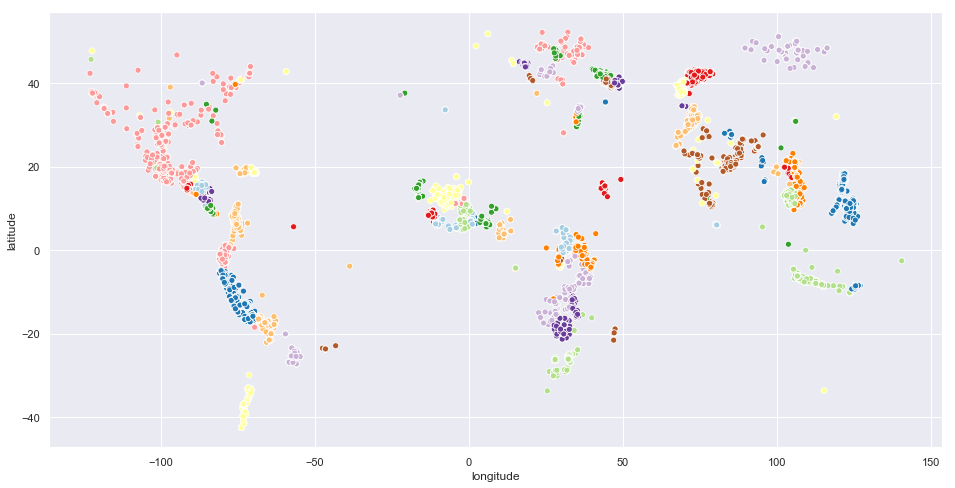

In [71]:
# Color is country-of-origin for the borrower, charted on the latitude/longitude of
# their residence when they took out the loan
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='country_code', legend=False, palette = "Paired")

The scatterplot below shows the same loans, but with color based on human development index, with the scale going from low (dark red) to high (dark blue).  As you can see, Africa and South Asia are the worst-off regions, but interestingly they're not the most common borrowers in Kiva's database.

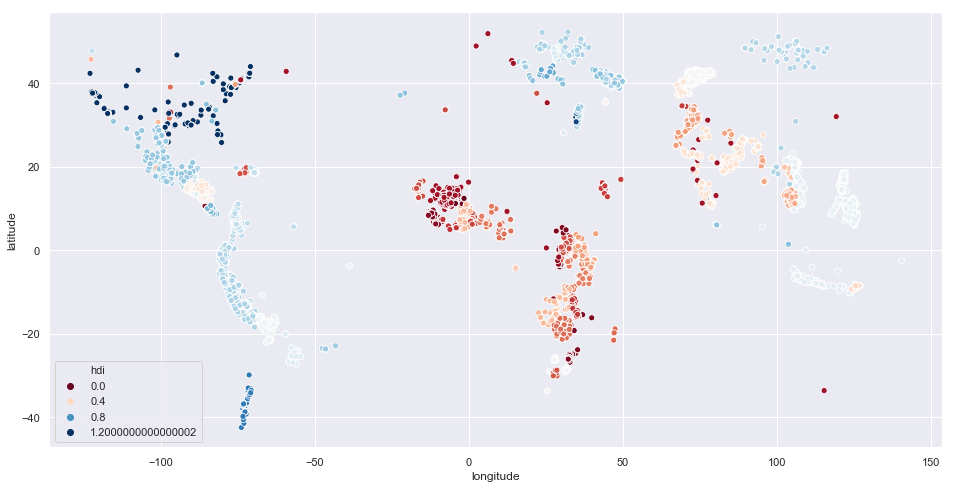

In [74]:
# Human Development Index (hdi) of the borrower's country-of-origin, 
# plotted on the geographic location of the borrower
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='hdi', legend='brief', palette="RdBu")

The barplot below shows the distribution of loans across geographic regions. South-Eastern Asia is by far the largest borrower in terms of number of loans.  Africa (divided into Easter, Western, Middle, Northern, and Southern) takes spots #2, 5, 10, 15, and 16.  Southern Asia, the other low-hdi region, is #6.  If Kiva were intending to send money to help the most-needy regions, they're not quite hitting that mark.  However, given the issues with finding worthy causes, vetting them, and distributing the loans, all while staying on the right side of the law and local officials, in some of those worse-off countries, it's not necessarily surprising that Kiva took its time getting around to those areas, and focused on places where they could still do a lot of good, like in Southeast Asia and Latin America.  

Text(0.5, 1.0, 'Distribution of loans across various regions')

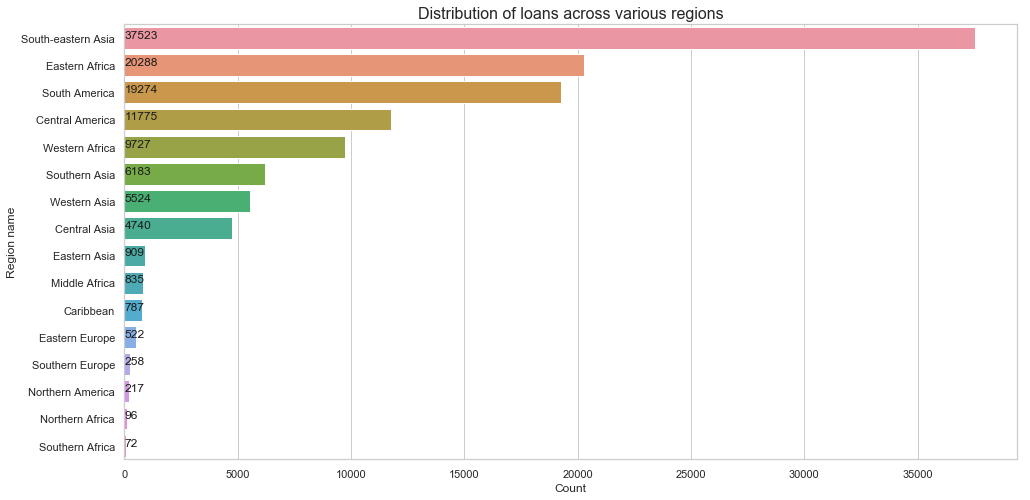

In [140]:
# Distribution of loans by world region
plt.figure(figsize=(16,8))
count = working_df['region'].value_counts()
sns.barplot(count.values, count.index, )
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Region name', fontsize=12)
plt.title("Distribution of loans across various regions", fontsize=16)

Text(0.5, 1.0, 'Most frequent countries for kiva loans')

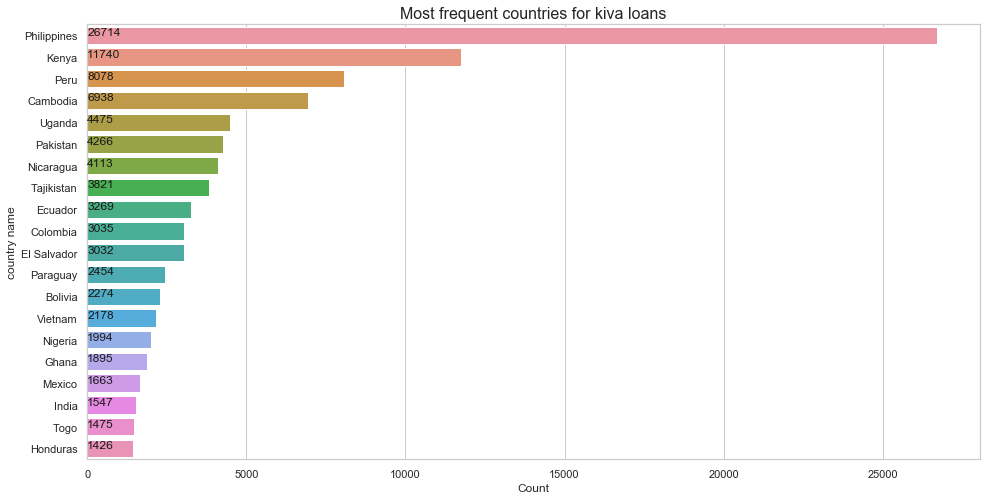

In [139]:
# Plot the most frequent countries
plt.figure(figsize=(16,8))
count = working_df['country_name_x'].value_counts().head(20)
sns.barplot(count.values, count.index, )
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('country name', fontsize=12)
plt.title("Most frequent countries for kiva loans", fontsize=16)

### Time-density of loans by region and sector
Kiva entered different regions at different points in time, and their activities have waxed and waned in specific regions as the years passed.  In a similar fashion, what people use Kiva loans *for* has changed over time, as new borrowers are brought onboard with different needs and Kiva expands what it considers "viable" philanthropic & business-related goals.

The violinplot below shows both of these trends - how many loans were made over the course of the last 14 years, to which region (on the right) and for what economic sector (on the left).  

As you can see, while most regions got more and more loans as time went by, some were late-adopters; East Asia, Northern and Southern Africa, and North America in particular had *zero* loans until a couple of years into Kiva's operational history.  (Note that each region or sector is measure *only in relation to itself* - the apparently-meteoric expansion of North African operations in the last couple of years in fact only represents 216 loans in total out of a 1/5th sample of the data.)

Similarly, the use of Kiva to fund various activities is spread out by time.  "Personal Use," for example, only started to be listed as a purpose for loans after a couple years of operations, and then has balooned dramatically in the latest two or three years.

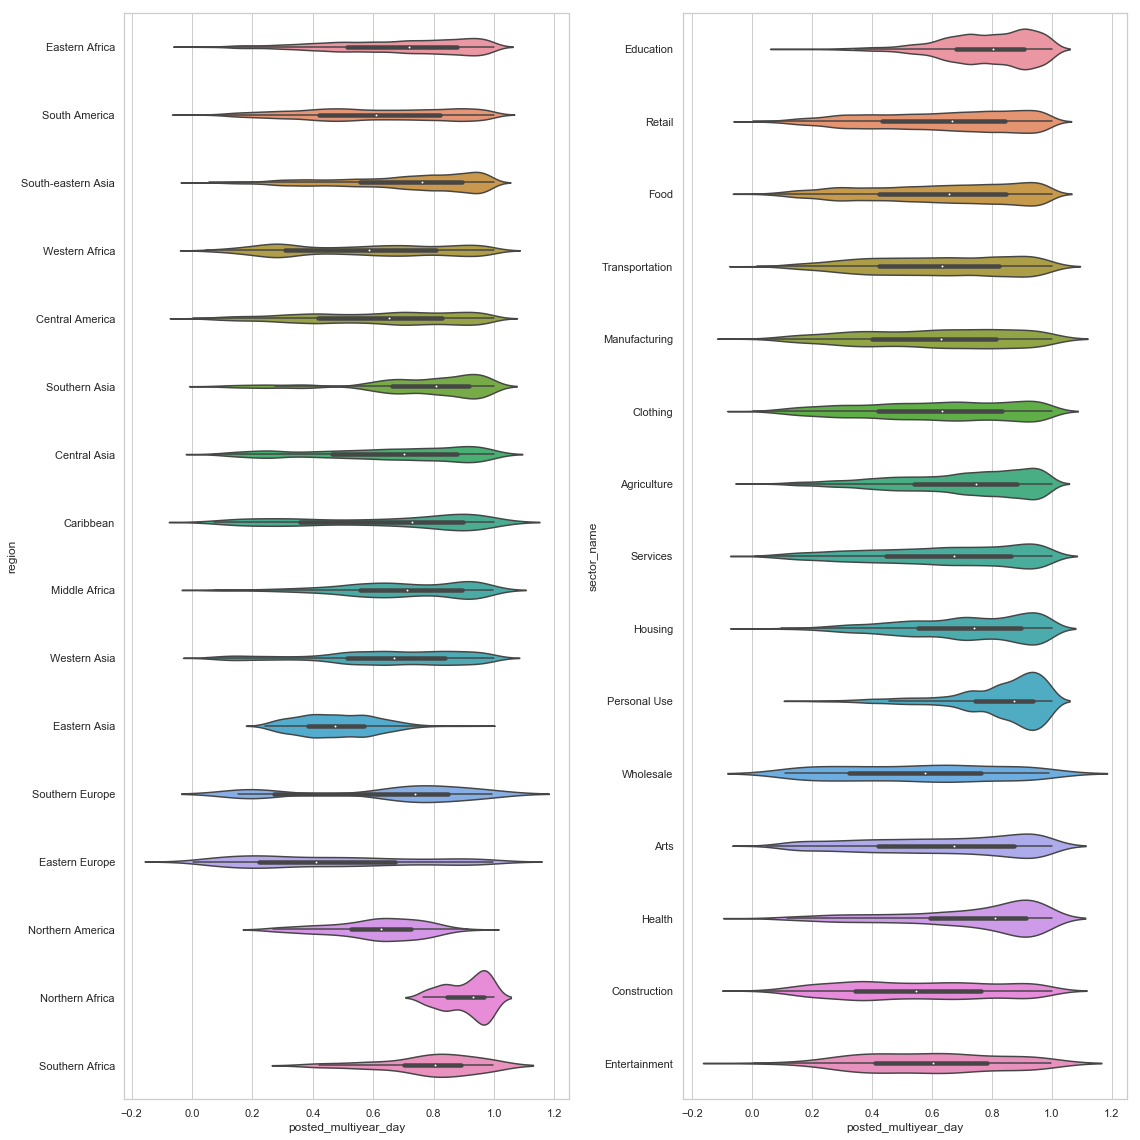

In [141]:
# 'posted_mulityear_day' is the rough time in days since January 1st, 2005, close to when Kiva began collecting data.

plt.figure(figsize=(16,16))
plt.subplot(1, 2, 1)
sns.violinplot(y="region", x="posted_multiyear_day", data=working_df)
plt.subplot(1, 2, 2)
sns.violinplot(y="sector_name", x="posted_multiyear_day", data=working_df)
plt.tight_layout()

A look at which sectors loans were for in absolute terms shows how dominant farming and mercantilism were in Kiva's loan-vetting process.  While a number of philanthropic areas (healthcare, education, transportation, housing, etc.) can easily grab the attention, the vast majority of Kiva's work was focused on ensuring that prospective business-owners (specifically in Agriculture, Food, and Retail, with Services and Clothing manufacture as honorable mentions) got a leg up on starting their enterprises.

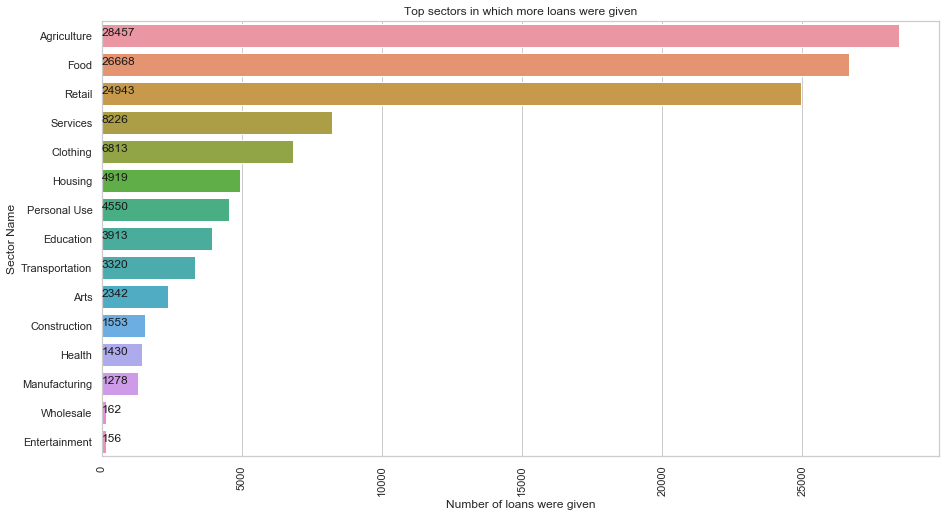

In [138]:
plt.figure(figsize=(15,8))
sector_name = working_df['sector_name'].value_counts()
sns.barplot(sector_name.values, sector_name.index)
for i, v in enumerate(sector_name.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Number of loans were given')
plt.ylabel('Sector Name')
plt.title("Top sectors in which more loans were given")
plt.show()

The deeper analysis of which specific activities got more loans holds up the previous sector-by-sector data, whith general stores, farming, retail, clothing sales, and food production & sales capturing the first five spots, and agriculture, pigs, grocery stores, fruits and vegetables taking four of the next five.

Text(0.5, 1.0, 'Top Loan Activity type')

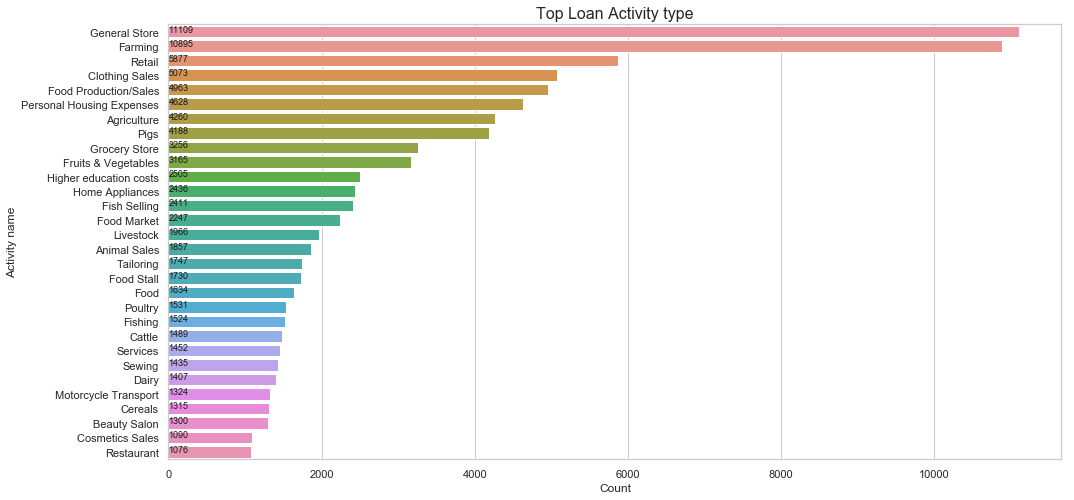

In [137]:
#Distribution of Loan Activity type

plt.figure(figsize=(16,8))
count = working_df['activity_name'].value_counts().head(30)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=9)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Activity name', fontsize=12)
plt.title("Top Loan Activity type", fontsize=16)

## Loan funding
Our target variable is whether or not a loan was funded, which can be found directly in one column and indirectly by comparing two others.  

The 'status' column describes loans as either 'funded', 'expired', or 'fundRaising'.  'funded' naturally means that it successfully funded, 'expired' means that it ran out its clock without being fully funded, and 'fundRaising' means that it was still in the process of raising funds to fill the loan when this dataset was collected.  

The 'loan_amount' and 'funded_amount' columns give us another way to determine which loans were funded or not.  A fully-funded loan has its loan_amount equal to funded_amount; if there's a discrepancy between the two features, then the loan wasn't fully-funded. 

The difference between these two measures is 9 loans out of over 1 million, and could easily be due to entry error or some other relatively minor issue; I've elected to simply remove any loans where the two disagree, resulting in - after doing some basic cleaning and removing loans listed as 'fundRaising' -  45,998 unfunded loans, and 1,141,673 funded ones, giving us 3.8% of the total remaining loans that went unfunded.

#### When?
Timeframe is an important variable in understanding business changes, and so we need to get at least a small understanding of *when* the unfunded loans were happening.

As the left violinplot below shows, there's a significant period at the beginning of Kiva's operations where there simply *aren't* any unfunded loans - presumably a period when their standards were higher, or when they simply spent the extra effort to ensure that no loan went unfunded.  Starting around day 1750, though, we start to see some unfunded loans pop up, and then they begin to explode (relative to their previous paucity) two years later.  

One of the culprits that I'd immediately though of for this complete lack of unfunded loans in the early years was that they simply didn't agree to release the money until the loan was funded.  However, the difference between the post date (when the loan goes up on the Kiva website) and the disbursal date (when the money is actually delivered to the borrower) that is shown in the scatterplot below quashed that hypothesis.  For the first two years or so Kiva did seem to hand out money starting about a week after the loan got posted.  Then, a year *before* the first unfunded loan shows up (represented by the right-hand side of the scatterplot), they switched to their current pattern of allowing their affiliates to distribute the money before the loan was posted.  Something changed after that, to allow for the unfunded loans to slip through the cracks - or perhaps for them to be recorded at all.  

What exactly happened, I don't know.  It would be worthwhile to ask Kiva, or spend more time digging into the data to find it, as that might well shine some light on the circumstances underlying our target feature's occurance.

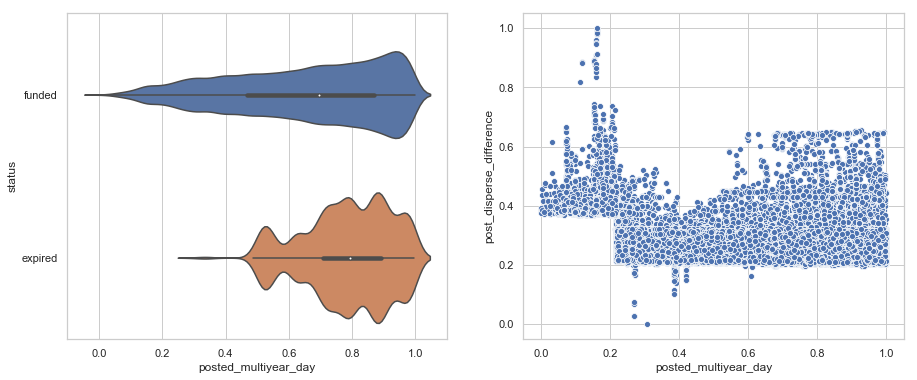

In [136]:
# time distribution of unfunded vs funded loans, and scatterplot of post-disburse difference vs time posted

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
sns.violinplot(x="posted_multiyear_day", y="status", data=working_df, orient='h')
plt.subplot(1, 2, 2)
sns.scatterplot(y="post_disperse_difference", x="posted_multiyear_day", 
                data=working_df.loc[working_df['posted_multiyear_day']<=1750])  

#### How much?
The next, fairly obvious, question on my mind when thinking about our target variable is 'how big were the loans that failed?' and 'how much did they fail by?'  The answers to both of those questions are below.

In the violinplot, we can see that, unsurprisingly, the very smallest loans are more likely to successfully fund, but the majority of unfunded loans are still below $2000.

In the distplot, we see another take on the unfunded loans, that of how far short they fell of being fully funded, with a lower number indicating that it was closer to being fully funded.  A significant portion are simply not getting *any* kind of funding, but the center of the distribution is close to .45, indicating that most are getting about halfway there before failing.

The scatterplot on the right shows the distribution of failed loans by how large they are compared to how much they failed by.  It's worth noting that the distribution of the shortfall ratio applies almost regardless of size, with large loans having nearly the same shortfall distribution as small loans.

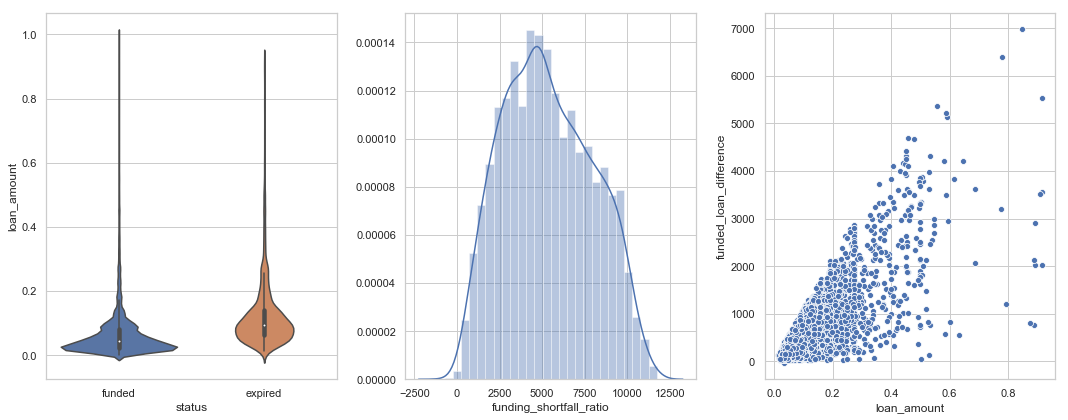

In [135]:
working_df['funding_shortfall_ratio'] = working_df.funded_loan_difference / working_df.loan_amount

plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
sns.violinplot(x="status", y="loan_amount", data=working_df, orient="v")
plt.subplot(1, 3, 2)
sns.distplot(working_df.loc[working_df['funded_status']==1]["funding_shortfall_ratio"])
plt.subplot(1, 3, 3)
sns.scatterplot(y="funded_loan_difference", x="loan_amount", 
                data=working_df.loc[working_df['funded_status']==1])
plt.tight_layout()

# 0.0.  Predicting whether a loan will be fully funded
To begin, I need to underline just how little correlation there is between any single feature that I've developed and the target of our investigation here, 'funded_status'.  The bottom line of the heatmap below is our target, and there's... not much *at all* that stands out as saying "this is a great predictor of whether a loan will be fully funded!"

So what we're dealing with is a lot of minor, fiddly features that, *in combination*, might add up to something that allows for prediction, at least to a limited extent.

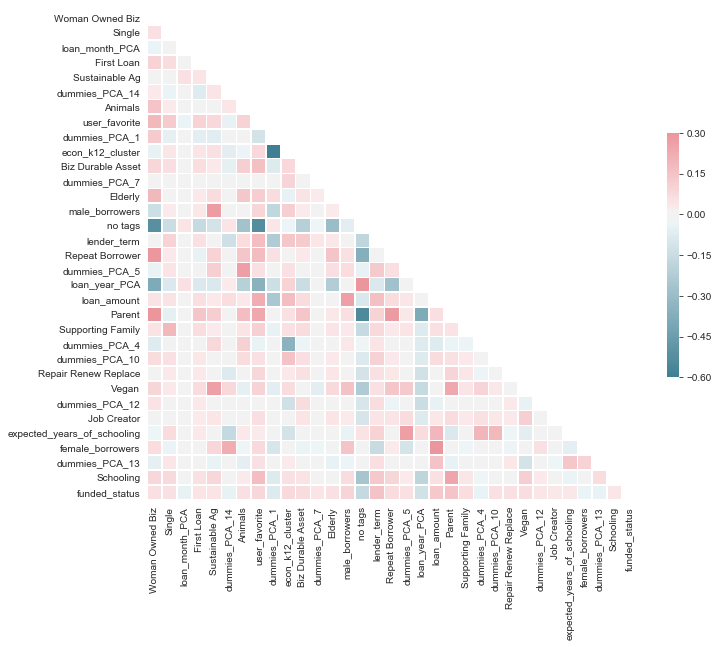

In [78]:
corr = working_df[spiral_feature_list+target_feature].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

First off, we're going to be using three datasets - the loans dataset, containing all of the loan-specific data; the country_stats dataset, containing economic data on the countries that Kiva has operations in; and loan_coords, which has latitude and longitude for every loan_id number, which can be matched to the same feature in the loans dataset.

After merging those three, we're left with a rather significant dataset:

In [20]:
print(working_df.shape)
#print(working_df.isna().sum())

(1216471, 45)


### 1.3. Cleaning
1,216,471 loans, and 45 features, right off the bat.  There are a lot of empty spaces in there, too, so let's start by cleaning the data up.  

The columns tags, loan_use, description, description_translated, and loan_name get filled in with 'no tags,' 'no description,' and so forth.  We drop 'currency_exchange_coverage_rate' because it's binary, a fifth of the entries are NaN, and it has a vanishingly small influence on the funded/unfunded feature that we're going to create.  We drop 'planned_expiration_time' because it has little impact on our target variable and a distinct disparity between time periods, in that all of it's pre-2012 values are NaN.  We drop 'raised_time' because it's the time when the loan is fully funded, and so is by definition a feature that is part of the outcome we're trying to predict, making it useless to us and with no other value we can extract.  Finally, we drop all instances where 'status' is 'fundRaising', to remove the most recent loans that haven't had a chance to finish their funding process yet.

Lastly we drop all rows that still have NaN, resulting in the loss of all loans from Kosovo, Solomon Islands, Somalia, Palestine, and Samoa , or roughly ~25k loans.

This leaves us with a dataframe shape of 1,187,680 x 42.

### 1.4 Resize sample
This is for ease of use, giving us the option of down-sampling the whole dataset so that we only have to hold a fraction of it in RAM at once.  (Which is necessary for me, given the woeful shape this dataset leaves my laptop in at full size.)


## 2.1. Feature prep, part 1

#### 2.1.1 Target feature creation
To start our creation pipeline, we take the difference between loan_amount and funded_amount and create funded_loan_difference, which we then translated into a binary feature 'funded_status' which becomes our target for prediction.  This feature is equal to 0 if there is no difference between how much was loaned and how much was funded, and 1 if there *is* such a discrepancy, meaning that not all of the loan ended up being funded by microlenders.

To ensure that this isn't leading us wrong, we compare the results with 'status', and drop the 9 (in the full >1 million sample) where the two measures disagree.

#### 2.1.2 Break down time-based features
Next we break up the posted_time into year, month, and day features, which we then combine into posted_yearfraction (the time of year it was posted in) and posted_multiyear_day which is an estimation of how long in days since January 1st, 2005, a loan was posted, giving us a rough estimate of how recently it was posted.  We do the same breakdown and creation for the disburse_time feature.  Then, to cap things off, we create a post_disburse_difference feature to see whether or not the length of time between a loan being given out to the borrower and the time the loan was posted to Kiva's website had an impact on whether a loan was funded (it didn't, that I can tell).

#### 2.1.3 Create time-based PCAs
Experimentation with SelectKBest showed that the timing of the loan had an impact on the funded_status, both the year it was made in and the time of year, so rather than have all eight related features competing for space in the final feature-set I combined them into two PCA features, loan_year_PCA for how recently/long ago the loan occurred, and loan_month_PCA for the time of year it was made during.

#### 2.1.4 Expanding on borrower_genders features
Next we take borrower_genders, which is a list of genders for individuals in the form of a comma-separated string: 'female, female, male, female'.  By converting it into a proper string and then counting the occurances of each gender in each loan's list, we can create integer features for the number of male and/or female borrowers, one for the total number of borrowers, and a binary feature for whether the borrowers are mixed-gender.

#### 2.1.5 Expanding on borrower_pictured features
Since the saying "a picture is worth a thousand words" is demonstrably true when looking at social media behavior, whether or not a loan has it's borrower's picture may well have an impact, so we need to unpack this string-based feature into its components.  The feature itself is a string of 'true' and 'false' separated by commas, so we split the mega-string into a list, just like with borrower_genders, and count how many of each are in the list.  We end up with a feature for the number of pictured borrowers, the number of unpictured borrowers, and a feature with the percentage of pictured borrowers.

#### 2.1.6 Expanding out the tags features
The 'tags' column is made up of strings containing a collection of hashtag- and comma-separated phrases.  Separating those out, we create a binary feature for each (there are only 43 in total used throughout the whole dataset, so this isn't a huge load on our RAM).

#### 2.1.7 Normalizing continuous features
For a number of algorithms, any signifiant variation away from a normal distribution throws their predictive accuracy off, so it's necessary to normalize the numbers in our continuous (non-categorical) variables.  In our case, this includes the following feature-set:

In [21]:
normalize_features = ['loan_amount', 'lender_term', 'num_lenders_total', 'num_journal_entries', 'num_bulk_entries',
                      'population', 'population_below_poverty_line', 'hdi', 'life_expectancy',
                      'expected_years_of_schooling', 'mean_years_of_schooling', 'gni', 
                      'posted_multiyear_day', 'post_disperse_difference', 
                      'male_borrowers', 'female_borrowers', 'borrower_count',
                      'pictured_borrowers', 'unpictured_borrowers', 'pictured_ratio']

#### 2.1.8 Load clustering data
Rather than re-compile all of the clustering algorithms again with every restart of the kernel, I saved the results to a csv and placed this section in to make adding the data in simpler.  Note that these clusters were calculated with the nearly-complete ~1,190,000 dataset, and merging the file with the working_df depends on using the loan_id feature in common between the created csv file and the original Kiva data.  

We're adding 9 new features:
* 'geoecon_k44_cluster', a K-Means cluster based on the geographic location as well as a variety of other country-based features.
* 'econ_k6_cluster', 'econ_k12_cluster', 'econ_k24_cluster', and 'econ_k36_cluster', which are K-Means clusters created using only national socio-economic data.
* 'econ_ms32_cluster', 'econ_ms28_cluster', 'econ_ms19_cluster', and 'econ_ms16_cluster', which are Mean-Shift clusters created using the same socio-economic data.

See section 3 Unsupervised Learning - Clustering below for more details.

## 2.2. Feature prep part 2

#### 2.2.1 Create dummy/binary features
There are a number of high-count categorical features in this feature-set, enough so that we can't depend on supervised learning algorithms to be able to take full advantage of them.  Worse yet, creating a full list of dummy-features (binary 1 or 0 values for each of their possible results) out of them will result in doubling the amount of RAM the kernel uses, which is a no-go for me, at the very least.  

#### 2.2.2 Create PCA features out of dummy feature-set
So, when confronted with too many features, what do we turn to?  PCA, of course.  We take the categorical variables 'activity_name', 'sector_name', 'currency', 'partner_id', 'econ_ms19_cluster', 'econ_ms16_cluster', 'econ_k24_cluster','econ_k36_cluster', and 'geoecon_k44_cluster' and create dummy variables from them.  This results in just shy of 800 new features (yikes).  Then we plug *all* of those new features into a PCA algorithm, and tell it to boil them down and give us 20 new features, which we then attach to our working_df.  While messy as hell, and likely losing a fair amount of information quality that we might otheriwse (maybe) be able to use, this actually still produces some quite useful features for our supervised learning algorithms.

The final shape of our dataframe is:

In [68]:
print(working_df.shape)

(1187298, 132)


# 3.0. Unsupervised Learning - Clustering


### 3.1. Geographic/Socio-Economic clusters
The first set of clusters I wanted to try experimenting with was using latitude, longitude, country_code, and the other features from the country_data dataset, to see what kind of clusters the algorithms would spit based on both physical location and socioeconomic information.

After some experimentation, a K-Means algorithm with k=44 produced a silhouette score of .8645, the highest it seems capable of going with those particular features.  The individual clusters have reasonable silhouette scores themselves, on the whole, although some are distinctly subpar, dropping as low as .55 in two cases (though this is relatively unsurprising, given the wildly disparate nature of some of the coordinate points).


### 3.2. Socio-economic clusters
For the next group of features, I used five socio-economic features from the country_data dataset ('population_below_poverty_line', 'hdi', 'life_expectancy', 'expected_years_of_schooling', and 'mean_years_of_schooling'), but this time without any country code or geographic data.  The individual countries each occupy a specific point within this five-dimensional space, meaning that the clustering algorithms should grab a country all at once, and end up clustering the countries by density of loans and their location within this 5D socio-economic landscape.

#### 3.2.1 K-Means
Silhouette scores for K-Means continued going up as k increased, reaching .97 at k=50.  however, the rate of increase slowed considerably, and given that prior experimentation had resulted in showing that low-k features had a positive impact on the prediction algorithm, I elected to select k= 6, 12, 24, and 36 for this trial.

For n_clusters =  6  The average silhouette_score is : 0.5031379704284099
For n_clusters =  12  The average silhouette_score is : 0.6252896137965863
For n_clusters =  24  The average silhouette_score is : 0.7865789782153829
For n_clusters =  36  The average silhouette_score is : 0.9092159881760116


#### 3.2.2 Mean-Shift
Mean-Shift produces some distincly lopsided clusters, with a strong taper in population for all but a few clusters and less impact on the prediction algorithms I experimented with.  However, in the interests of including multiple possible cluster distributions, I ran the sample through a battery of tests to find the most-useful meanshift bandwidths.  The results were .32, .28, .19, and .16.

For bandwidth = 0.32 there are 7 clusters and the average silhouette_score is: 0.4154247093471361
For bandwidth = 0.28 there are 11 clusters and the average silhouette_score is: 0.4570876031951729
For bandwidth = 0.19 there are 35 clusters and the average silhouette_score is: 0.785978836070225
For bandwidth = 0.16 there are 44 clusters and the average silhouette_score is: 0.8472753807353656


### 3.3. Clustering Analysis
Unfortunately, while getting high silhouette scores is all very well and good, you lose something in being able to analyze a set of clusters when there are 30+ of the things.  Moreover, a number of the clusters - especially those generated by Mean-Shift - are tiny, barely holding any loans at all, as you can see below:

<function matplotlib.pyplot.show(*args, **kw)>

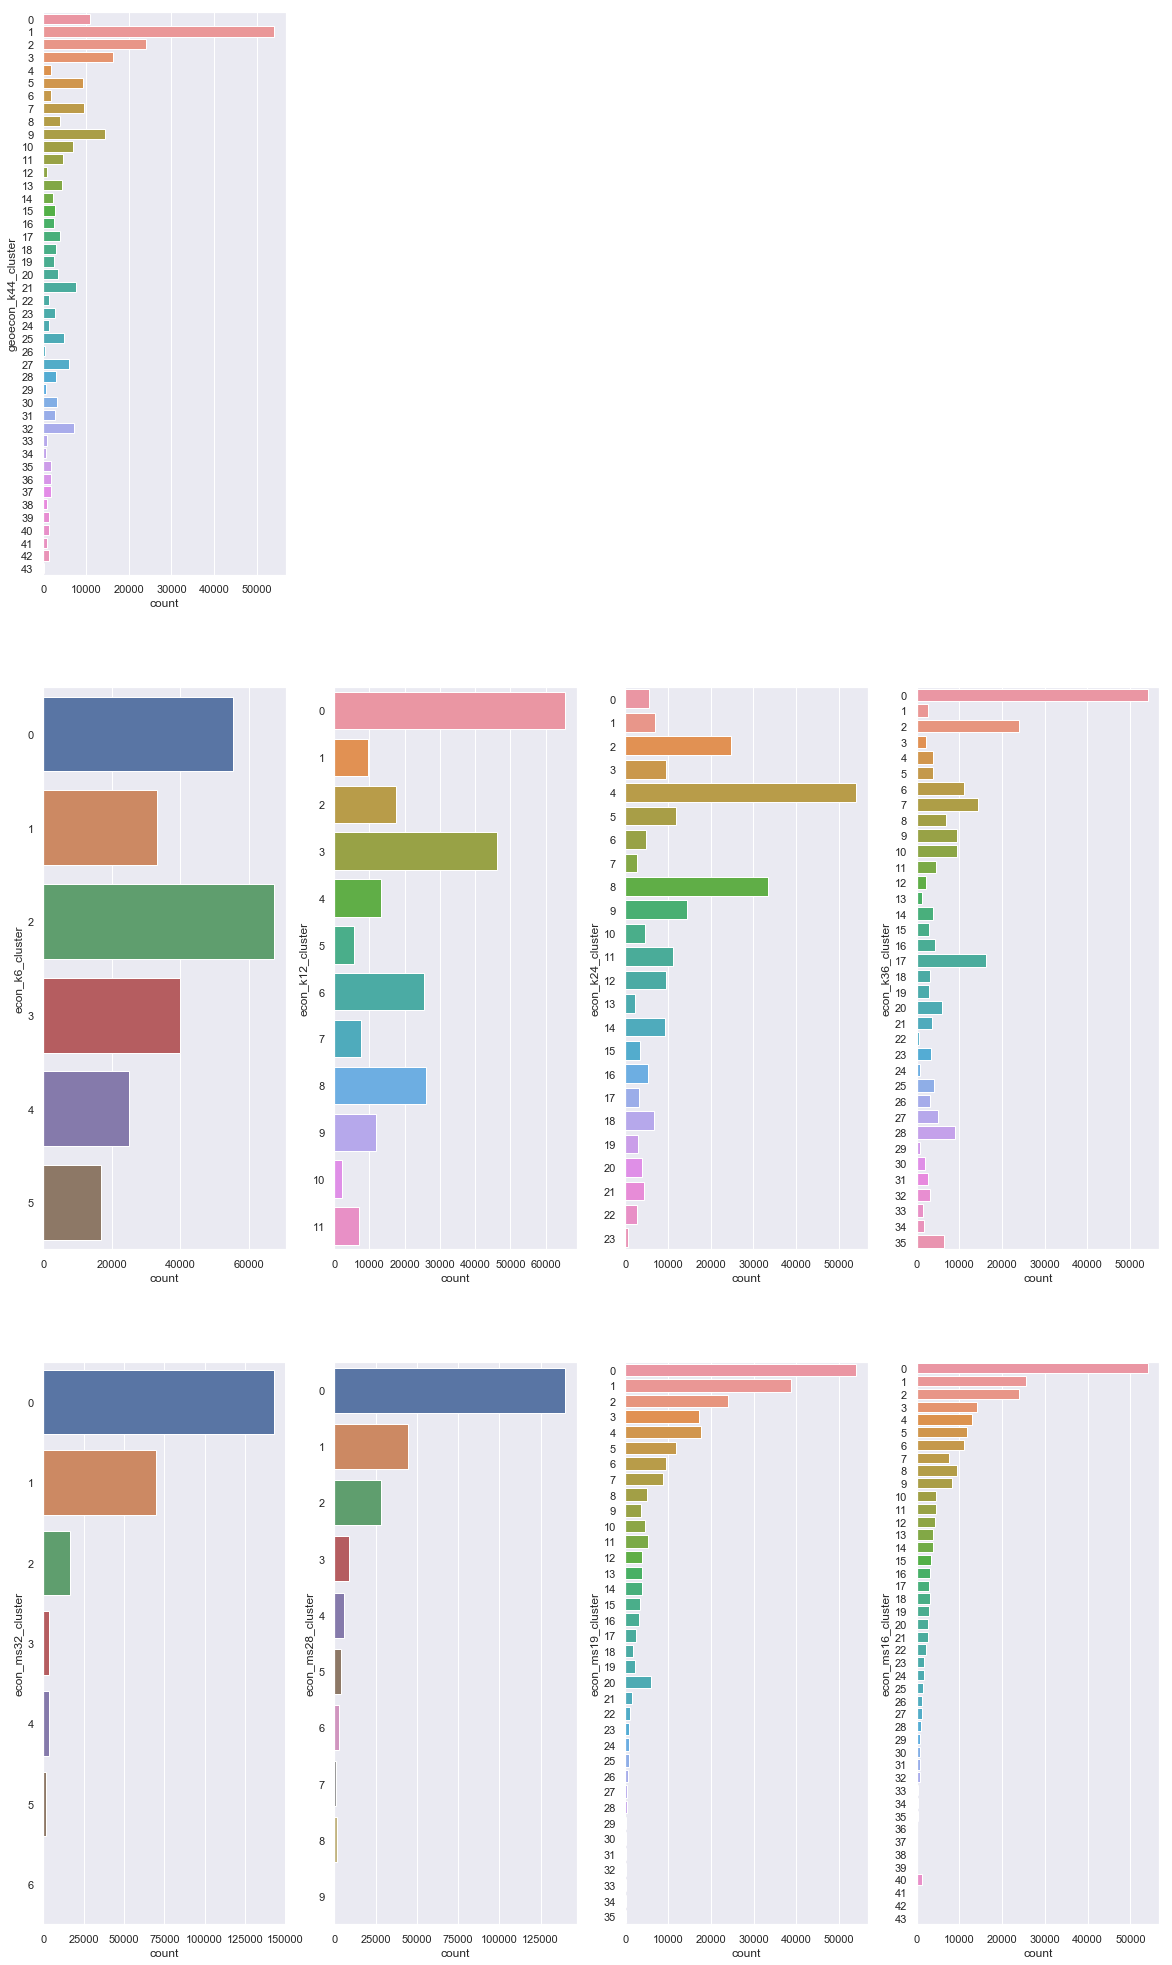

In [89]:
plt.figure(figsize=(20,60))

plt.subplot(5, 4, 1)
sns.countplot(y = working_df['geoecon_k44_cluster'])
plt.subplot(5, 4, 5)
sns.countplot(y = working_df['econ_k6_cluster'])
plt.subplot(5, 4, 6)
sns.countplot(y = working_df['econ_k12_cluster'])
plt.subplot(5, 4, 7)
sns.countplot(y = working_df['econ_k24_cluster'])
plt.subplot(5, 4, 8)
sns.countplot(y = working_df['econ_k36_cluster'])
plt.subplot(5, 4, 9)
sns.countplot(y = working_df['econ_ms32_cluster'])
plt.subplot(5, 4, 10)
sns.countplot(y = working_df['econ_ms28_cluster'])
plt.subplot(5, 4, 11)
sns.countplot(y = working_df['econ_ms19_cluster'])
plt.subplot(5, 4, 12)
sns.countplot(y = working_df['econ_ms16_cluster'])
plt.show


The very fast taper in the Mean-Shift counts implies that most of the lower-count mean-shift clusters are grabbing just a handful of loans each, if any. As such, we'll be tossing the sets with many clusters (geoecon_k44_cluster, econ_k24_cluster, econ_k36_cluster, econ_ms19_cluster, and econ_ms16_cluster) into a PCA algorithm (see 2.3.1) to reduce them down to something that supervised learning can handle more easily. The remaining four we'll keep as-is, to give the decision-tree algorithms something to chew on.

On the whole, these clusters give us reasonable groupings of poverty and geography, and prove in some cases to be demonstrably better than their component features at correlating with our target variable.  

Other plots of the clustering data and further analysis are available at the end of the notebook, under the heading **3.3. Clustering Analysis**, but in the interests of space I've not replicated them here.

# 4.0. Supervised Learning
Now we get to the fun part - whether we can *actually* predict if a loan is going to fully fund.

## 4.1. SelectKBest
First things first, we need to use SelectKBest to figure out which features have the most relevancy for our target feature.  Doing so, with all of our features having been prepped, gives us these features as our top 70, in order of decreasing importance:

In [74]:
print(ordered_top_features)

['no tags', 'lender_term', 'Parent', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'user_favorite', 'dummies_PCA_1', 'econ_k12_cluster', 'Biz Durable Asset', 'Repeat Borrower', 'Supporting Family', 'Vegan', 'country_code3', 'Repair Renew Replace', 'currency_policy', 'dummies_PCA_10', 'dummies_PCA_5', 'Elderly', 'Animals', 'Woman Owned Biz', 'Single', 'loan_month_PCA', 'First Loan', 'Sustainable Ag', 'dummies_PCA_14', 'dummies_PCA_7', 'original_language', 'dummies_PCA_4', 'dummies_PCA_12', 'Schooling', 'dummies_PCA_13', 'female_borrowers', 'expected_years_of_schooling', 'Job Creator', 'region', 'life_expectancy', 'repayment_interval', 'Low-profit FP', 'dummies_PCA_9', 'dummies_PCA_17', 'Refugee', 'dummies_PCA_11', 'Hidden Gem', 'dummies_PCA_6', 'hdi', 'Inspiring Story', 'gni', 'population', 'Trees', 'population_below_poverty_line', 'mixed_gender_borrowers', 'dummies_PCA_8', 'Unique', 'Fabrics', 'dummies_PCA_3', 'continent', 'Interesting Photo', 'Single Parent', 'econ_k6_cluster', 'd

Tags are, obviously, of critical importance, taking the first and third spots and many of the rest (there's a caveat here, but I'll get into it in the conclusion).  'lender_term', the length of time a loan is supposed to last, takes the #2 spot, followed by the size of the loan at #4, the year in which the loan was made at #5, the number of male borrowers at #6, and then an assortment of PCA and clustering features.  

### 4.1.a Spiral SelectKBest feature-set creation
The Convolutional Neural Network algorithm requires there to be *some* sort of 2D organization to the features in each instance it examines; as such, I've devised a set of functions that uses the SelectKBest score of the feature to position it in a spiral sequence that moves in descending order of correlation outwards from the 'center' of the 2D square that the CNN algorithm will be looking at.  Since this needs the square to be a *square*, I've elected to use square numbers as the length(s) of my feature set(s), regardless of algorithm.  (It's not like any of the other algorithms care what order the features are in, and this way I don't have to worry about the feature-list being in the wrong order when I get around to running CNN.)

In [108]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36


## 4.2. Choosing an algorithm
Once the SKB was through, I chose an arbitrary number of features (50, for the first tests, though in later runs I used 36 after determining that was close to the optimal number) and ran them through Naive Bayes, Logistic Regression, KNN, Decision Tree Classifier, Random Forest Classifier, and Gradient Descent Classifier.  I attempted to run it through Support Vector Machine Classifier, but aborted the run when the (1/10th size sample) test run exceeded 12 hours.

The results were... not great, frankly.

* **NB:  model accuracy = .81, f1 score for unfunded = .21** - Naive Bayes was never going to be anybody's bet for the best-performer in this lot.  It's a basic classification algorithm, and it did pretty badly, as we'd expect for data with as little clear correlation with our target variable as this dataset has.

* **LR:  model accuracy = .93, f1 score for unfunded = .29** - Logistic Regression is a fairly straightforward algorithm, albeit more discerning than NB.  Still, without clear distinctions to draw on between the two classes, it didn't perform very well in picking out the unfunded loans, though it did perform reasonably well at overall accuracy.

* **KNN:  model accuracy = .91, f1 score for unfunded = .35** - KNN shows a surprising increase in accuracy in picking out unfunded loans, though its overall accuracy is lacking compared to LR.  This is likely due to it over-doing the nearest-neighbor comparison, and associating more loans (funded and unfunded) with unfunded loans than LR does, and this increases its accuracy in picking out unfunded loans while decreasing its accuracy in identifying funded loans.

* **DTC:  model accuracy = .94, f1 score for unfunded = .44** - Decision Tree is the most basic decision tree algorithm, which comes with pros and cons.  It's not as prone to overfitting as either RFC or GBC, but it's not quite as accurate in an uncertain environment.  Thus, it performs well (compared to the previous algorithms, at least) but usually doesn't do any better than the two more complex ensemble/decision tree algorithms.  In this case, though, while it underperforms compared to RFC, it actually matches and slightly exceeds the performance of GBC, which is unusual, in my experience.  The reason may lie in just how confusing this dataset is - perhaps DTC is ignoring some noise that GBC treats as being signal, and thus manages to eke out a slightly higher model score.

* **RFC:  model accuracy = .95, f1 score for unfunded = .5** - Random Forest generates a lot of decision trees, and then takes the average result from all of them to determine its classification.  This means that, as long as there's *something* for the trees to pick out as a determinitive feature, or combination of features, it can sift through the noise of the data and find a decent signal, albeit still a weak one. 

* **GBC:  model accuracy = .93, f1 score for unfunded = .44** - Gradient Boosting generates a single, iteratively-improved-on decision tree.  This can be very powerful, as the algorithm gets better and better at predicting the outcome based on what evidence it has to base that prediction on.  However, in this case there's a *lot* of noise, and the tree it generated couldn't compete with the wisdom-of-crowds that Random Forest generates in this instance.  In fact, something about the dataset seems to have caused it to *under*perform slightly compared to DTC in its overall model accuracy - something that I found quite surprising.

#### Outcome
Of the six, Random Forest is the best at predicting whether a loan would go unfunded, even if it's not great at it.  Still, it's something, and it's not overfitting at all, so let's pursue that avenue of approach.

In [88]:
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)


Random Forest Classifier
Model score:
0.956893727476626
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    228117
           1       0.49      0.52      0.50      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.75      0.74    238086
weighted avg       0.96      0.96      0.96    238086

 
Model cross-valuation:
[0.96051913 0.96075014 0.96022429 0.95967827 0.96034946]


## 4.3. GridsearchCV
Optimizing the Random Forest for this was relatively simple; run the model a couple of times with different values in its various parameters, and see what makes a difference, then run GsCV to figure out which combination of them is best.  The results were, fortunately, just what I expected.  Recommended parameters are:

* class_weight = 'balanced_subsample'
* max_depth = None
* max_features = 'log2'
* n_estimators = 100

This bumps the unfunded f1 score of the RFC algorithm up slightly, though it's worth pointing out that it actually comes at a slight decrease in the model's average performance.

### 4.4. Selecting Feature-list length
Once we've gotten an ordered list of our top features and pinned down our likely-best algorithm, the next step is to figure out how many features gives us an optimal result.  As I've mentioned, I ran the tests using square numbers to make using CNN easier in the future.

* n = 9:  Model score = 0.951, f1 scores = .97/.49
* n = 16:  Model score = 0.953, f1 scores = .98/.51
* n = 25:  Model score = 0.955, f1 scores = .98/.52
* n = 36:  Model score = 0.955, f1 scores = .98/.53
* n = 49:  Model score = 0.954, f1 scores = .98/.52
* n = 64:  Model score = 0.955, f1 scores = .98/.53

As you can see, performance peaks sometime around n=25, and declines slowly as the number of features increases, before bumping back up between n=49 and n=64. Because n=36 is functionally equivalent and slightly faster to run than n=64, I've chosen to run my models using the lower value for the rest of the notebook.

#### 4.5. Final Supervised Learning Model

In [113]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)

Random Forest Classifier
Model score:
0.955188461312299
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.59      0.53      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086

 
Model cross-valuation:
[0.96169516 0.96207317 0.96137934 0.96091732 0.96137853]


This is, so far as I've been able to engineer it, the best predictive algorithm for this dataset.  I'll touch on the attempts I made with deep learning below, but even they didn't have as much success as this.  

Needless to say, this is not the kind of result we want.  95.5% accuracy rate is distinctly better than just picking at random, but for a class imbalance of close to 4% it's distinctly less than we need if we're to suggest Kiva start to depend on it for predictive value.  

However, with that being said, the algorithm does manage to pick out roughly half of the unfunded loans, which makes it (if we *were* to present it to Kiva as a product) at least a decent preliminary screening tool.  Moreover, from what we've learned in constructing it and figuring out the features it's sensitive to, we can provide guidance on where and how Kiva can improve its funding network and reduce the unfunded rate for its loans.

All of which I'll go into in the 7.0. Conclusions section; before that, let's cover the Deep Learning section.

# 5.0. Deep Learning
All tests in this section were run using a 3/10 sample, containing 357,140 loans.

### 5.1. Multi-Layer Perceptron
I originally expected MLP to be less-effective than Keras, given that it's a more basic form of neural network.  However, after testing multiple setups, a model with 100, 50, and 25 layers before the final output layer proved to be the highest-performer, generating a score of .92 and f1 scores of .96 and .44.  Not better than the Random Forest, but only barely worse than GBC.

I believe this less-than-stellar performance is due to the fact that there's simply so much noise, and so little signal, in the data with relation to the funded_status, that even using multiple layers of neurons the perceptron isn't able to separate out useful indicators of our target variable.

In [75]:
# Note: this was tested using the full data sample
# set up the MLP with a layer structure of 100, 50, 25, 5, and 1
mlp100_50_25_5 = MLPClassifier(hidden_layer_sizes=(100,50,25,5))
mlp100_50_25_5.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp100_50_25_5, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9243508648135548
 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    228117
           1       0.32      0.72      0.44      9969

   micro avg       0.92      0.92      0.92    238086
   macro avg       0.65      0.83      0.70    238086
weighted avg       0.96      0.92      0.94    238086




### 5.2. Keras
As I said, I expected Keras to outperform MLP, but oddly enough it has actually underperformed.  The best performance it showed was a model score of 0.94 and f1 scores of .97 and .25, which is in the same range as KNN and Naive Bayes.  I'm frankly shocked that it was so much worse than the standard decision tree/ensemble algorithms, and I intend to devote time and processor power to experimenting with Keras in the future to figure out if there's an angle of approach that I missed.

In [86]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #optimizer = RMSprop()
    return model

In [87]:
kclass = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kclass.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, kclass, 0)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
199360/199360 [==============================] - 65s 327us/step - loss: 0.3751 - acc: 0.8240
Epoch 2/5
199360/199360 [==============================] - 54s 269us/step - loss: 0.3521 - acc: 0.8311
Epoch 3/5
199360/199360 [==============================] - 62s 313us/step - loss: 0.3460 - acc: 0.8350
Epoch 4/5
199360/199360 [==============================] - 54s 272us/step - loss: 0.3427 - acc: 0.8365
Epoch 5/5
71428/71428 [==============================] - 4s 54us/step
Model score:
71428/71428 [==============================] - 7s 95us/step
0.9404435270500489
 
Classification Report:
71428/71428 [==============================] - 5s 70us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     68463
           1       0.26      0.24      0.25      2965

   micro avg       0.94      0.94      0.94     71428
   

### 5.3. Convolutional Neural Network
I frankly expected CNN to fail, here.  It's meant to be an algorithm that learns from the spatial relationships between features, like the arrangements of pixels in an image or datapoints arranged on a map in a timeseries.  While this dataset *can* be arranged spatially, via the longitude and latitude features, that doesn't provide much actual data for the algorithm to work off of, and practically none that relates to our target feature.

So, rather than throw CNN out of consideration altogether, I tried to rearrange the features into a 'picture' of their own (see 4.1.a, on making a spiral feature array).  From my understanding, the important part was to ensure that the high-importance features were near each other so that the convolution window could capture them together, and gain some idea of the importance of their co-variance in that arrangement.  If they were scattered in a random arrangement around the 'image' that the algorithm was examining, it would have found less meaning in them, and so produced worse results.  I don't think that this spiral pattern is necessarily the *optimal* way to arrange things, but I have a set amount of time and an internet search provided nothing to point me in a different direction, so it will have to do for the moment. 

And, frankly, it works better than I had expected, especially after I tinkered with the layer setup and activation functions.  The model below produces a model score of .937, and f1 scores of .97 and .27.  This isn't *good*, by any means, but it's better than Naive Bayes, which means that it's not producing pure gibberish.  In my mind, at least, this means that it was a successful attempt to turn a non-pictographic dataset into something that CNN can vaguely understand, even if it's not particularly good at deciphering it.

Again, further experimentation (and, preferably, an expert opinion on how to perform the arrangement of features) is called for, to see if better performance can be squeezed from this algorithm.

In [97]:
def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [99]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 0)

71428/71428 [==============================] - 1s 15us/step
Model score:
71428/71428 [==============================] - 1s 13us/step
0.9370694965559725
 
Classification Report:
71428/71428 [==============================] - 1s 9us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     68463
           1       0.26      0.28      0.27      2965

   micro avg       0.94      0.94      0.94     71428
   macro avg       0.61      0.62      0.62     71428
weighted avg       0.94      0.94      0.94     71428



## 6.0. Checking numeric features for outliers
I'm including this here for record-keeping purposes, not because they're a huge part of the modeling process.

# 7.0. Conclusion
There is a lot going on in this dataset, and a lot of information I still haven't cracked out of it.  The target variable that I chose to pursue, while I believe it to be valuable to Kiva's operations, is a hard target to pin down, and the data that I've extracted to pursue it hasn't been incredibly effective at predicting it so far.

## 7.1. What good is it?
First things first: what use(s) can this notebook be put to, in the real world?  I would suggest that it be used, if Kiva for some reason doesn't already have such an algorithm in place, to screen incoming loan proposals from their local affiliates, to identify any that might be problematic.  Due to the algorithm's less-than-perfect accuracy, this would have to be just one *part* of the review process, but it could still point out some loans that would otherwise be skipped over as not having any issues, and thus produce a bit of risk-reduction for Kiva.

## 7.2. What can we learn from it?
More importantly, from my point of view, is what we can learn from this about which loans get funded and which ones don't.  

### 7.2.1 The mystery of the tags
First and foremost, there's the issue of tags.  The barplots below show the top eight tags, as chosen by SelectKBest, and how many of them are found in funded and unfunded loans.  The orange bars (1) represent when that tag is present, while the blue bars (0) represent when they're absent, and the higher the bar the more unfunded loans it represents.  The violinplot below them is a time-distribution of the presence of tags.

<function matplotlib.pyplot.show(*args, **kw)>

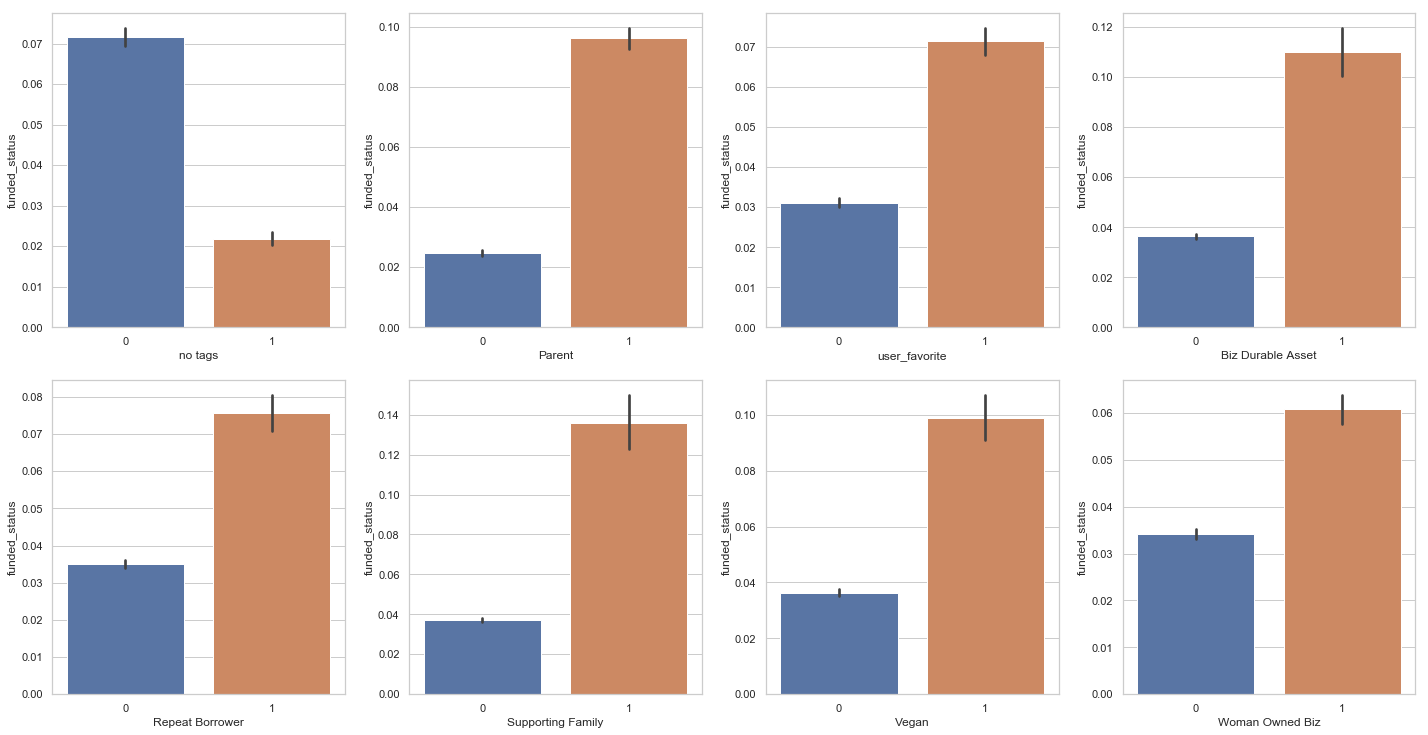

In [134]:
plt.figure(figsize=(20,15))
plt.subplot(3, 4, 1)
sns.barplot(x="no tags", y="funded_status", data=working_df.loc[working_df['posted_multiyear_day']>.5])
plt.subplot(3, 4, 2)
sns.barplot(x="Parent", y="funded_status", data=working_df)
plt.subplot(3, 4, 3)
sns.barplot(x="user_favorite", y="funded_status", data=working_df)
plt.subplot(3, 4, 4)
sns.barplot(x="Biz Durable Asset", y="funded_status", data=working_df)
plt.subplot(3, 4, 5)
sns.barplot(x="Repeat Borrower", y="funded_status", data=working_df)
plt.subplot(3, 4, 6)
sns.barplot(x="Supporting Family", y="funded_status", data=working_df)
plt.subplot(3, 4, 7)
sns.barplot(x="Vegan", y="funded_status", data=working_df)
plt.subplot(3, 4, 8)
sns.barplot(x="Woman Owned Biz", y="funded_status", data=working_df)
plt.tight_layout()
plt.show

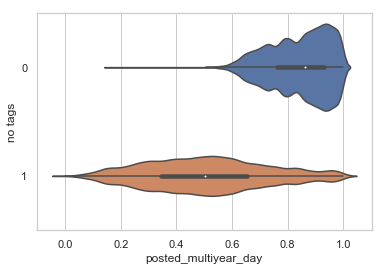

In [133]:
# time-distribution of tagged (blue/top) and untagged (orange/bottom) loan profiles
sns.violinplot(y="no tags", x="posted_multiyear_day", data=working_df, orient="h")

The presence of tags is, for whatever reason, inversely correlated with a particular loan being successfully funded: having tags means that a loan is *less* likely to fund, in complete opposition to my expectations given the nature of social media encouraging the use of categorizational tools like tags.  They are some of the most important features in the algorithm, according to SelectKBest, but the question becomes: if their presence seems to increase the odds that a loan *won't* be fully funded... are they there when the loan is first posted, and somehow reduce the odds of it funding? or are they something that Kiva has added to struggling loans, in the hope that the extra attention the tags might bring in will get the loan over the funding finish-line?

Slightly more than half the loans lack tags.  Tag usage was possible but very uncommon early on in Kiva's operations, and only really took off in the latter half of their current history. Given the similar preponderance of unfunded loans in the latter half of their operations, it's a distinct possibility that they started promoting the active use of tags by Kiva staff (or simply "strongly encouraging" borrowers to add tags on their own) as a way to help struggling loans get funding.

We can't know, though, without observing Kiva's history on this, and there aren't sufficient data points on when or why tags are added to make the answer to that clear.  Removing tags produces a slight decrease in the Random Forest model's unfunded f1 score (dropping it down from .53 to .52) but *increases* the overall model score by a small fraction of a percent (see 4.5.1).  

Essentially, this boils down to two things: 

1) If (for some strange reason) Kiva isn't already looking deeply into the impacts (positive or negative) of tags on their loans, they absolutely *should* be, as well as doing further data analysis and investigation than what this notebook contains.

2) If Kiva *is* using tags as a reaction to slow-funding loans, then the entire category needs to be removed from this model, as it effectively represents a minor cheat code for the algorithms to detect when a loan is more likely to have failed.  Given the slight effect on the model's output, though, this isn't a truly crippling adjustment.


### 7.2.2 Miscellanious lessons that can be drawn
There are a lot of variables that play into our model's performance, and it's useful to take a look at them one at a time, as well as in aggregate.  Below are some barplots representing the correlation between funding status and the top non-tag, non-PCA variables in our model.  The first 9 plots are comparing the funded and expired populations (on the x-axis) of continuous variables, while the last 3 are comparing the average funded_status values (on the y-axis) of the various classes within categorical variables.

<function matplotlib.pyplot.show(*args, **kw)>

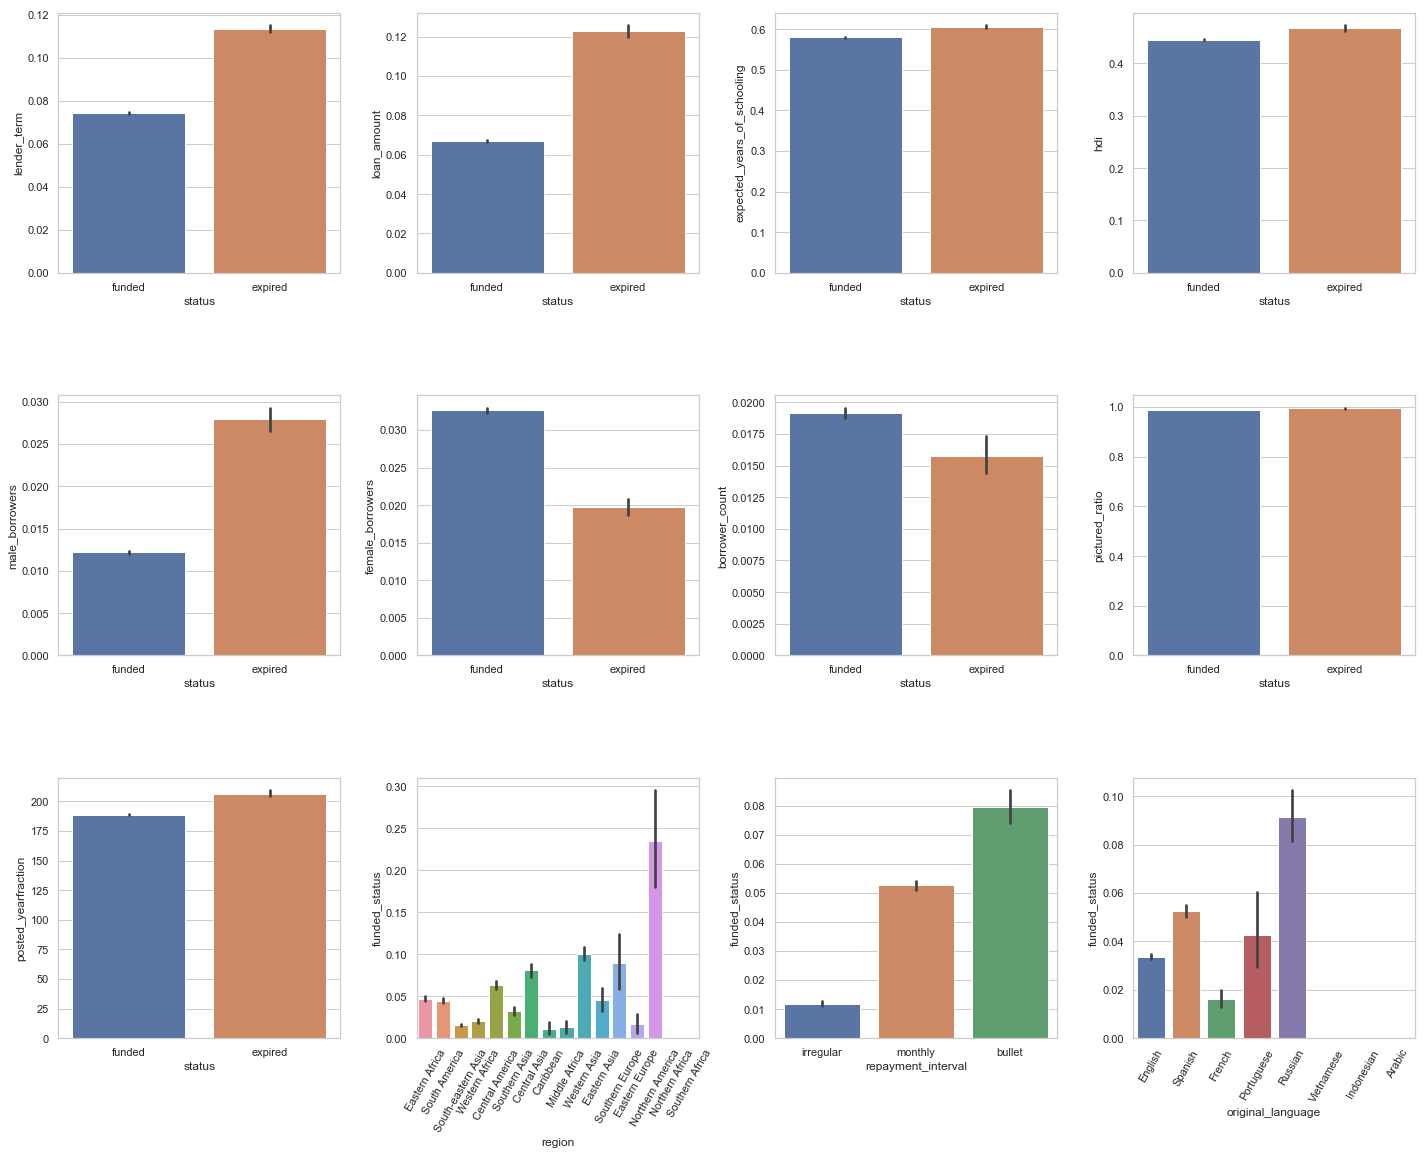

In [132]:
plt.figure(figsize=(20,20))
plt.subplot(4, 4, 1)
sns.barplot(y="lender_term", x="status", data=working_df)
plt.subplot(4, 4, 2)
sns.barplot(y="loan_amount", x="status", data=working_df)
plt.subplot(4, 4, 3)
sns.barplot(y="expected_years_of_schooling", x="status", data=working_df)
plt.subplot(4, 4, 4)
sns.barplot(y="hdi", x="status", data=working_df)
plt.subplot(4, 4, 5)
sns.barplot(y="male_borrowers", x="status", data=working_df)
plt.subplot(4, 4, 6)
sns.barplot(y="female_borrowers", x="status", data=working_df)
plt.subplot(4, 4, 7)
sns.barplot(y="borrower_count", x="status", data=working_df)
plt.subplot(4, 4, 8)
sns.barplot(y="pictured_ratio", x="status", data=working_df)  
plt.subplot(4, 4, 9)
sns.barplot(y="posted_yearfraction", x="status", data=working_df)  
plt.subplot(4, 4, 10); plt.xticks(rotation=60)
sns.barplot(x="region", y="funded_status", data=working_df)
plt.subplot(4, 4, 11)
sns.barplot(x="repayment_interval", y="funded_status", data=working_df)
plt.subplot(4, 4, 12); plt.xticks(rotation=60)
sns.barplot(x="original_language", y="funded_status", data=working_df)
plt.tight_layout()
plt.show


There's a lot going on up there, so let's start unpacking it.  

1) How long lenders are expected to wait to be paid back (lender_term) definitely, and unsurprisingly, has a negative impact on their interest in funding the loan.

2) Bigger loans are less likely to be fully funded.  Not a surprising conclusion, but worth noting.

3 & 4) Local economic indicators (expected_years_of_schooling and hdi) have only a slight impact on loans being funded, with higher-income indicators being slightly more likely to result in a loan going unfunded.  It is actually a bit surprising that the impact is so small, given the distinct preference against American borrowers (see the national funding section below), but there are likely enough other low-income countries with higher-than-average unfunded rates to water down the preference against borrowers from higher-income countries.

5 & 6) Male borrowers may be less sympathy-inducing than female borrowers - the more male borrowers there are the less likely the loan is to successfully be funded and, vice-versa, the more female borrowers there are the more likely the loan is to get funding.

7) Higher borrower_count seems to be linked in a slight way to a higher funding success rate; maybe lenders think that large groups of people are more deserving, or less likely to default.

8) There is almost *zero* appreciable difference between funded and unfunded loans based on the average number of borrowers with photos posted.  Given how important pictures are in social media, this was rather astonishing to me when I first saw it, but given the extremely high average pictured_ratio for the entire dataset (98.9%) this is really more an effect of just how few loan profiles don't have any pictures.

9) There's a slight increase in failure to fund if a loan is posted later in the year.  Odd, but perhaps something to do with seasonal variations in lender moods or borrower requests.

10) Eastern Europe is *not* a good place to be if you want to get your loan funded, apparently, though given the large variance that's possibly a result of a too-small sample from those countries.  Southern and Eastern Asia, and Western and Middle Africa are also higher-than-average in terms of regional unfunded rates.

11) A 'bullet' repayment interval is less likely to get funding than either other repayment setup, and (oddly, in my eyes) a loan with a monthly repayment interval is less likely to be fully funded than one with an irregular repayment interval.

12) Apparently fewer people trust profiles originaly written in Russian?  Also: Vietnamese, Indonesian, and Arabic speakers are a sufficiently small number of loans taken out that they have a perfect track record in terms of funding.  Spanish-language profiles are slightly more likely to go unfunded than English ones, too, which given the large number of Spanish-speaking borrowers who use Kiva, might be an issue that needs to be looked into.

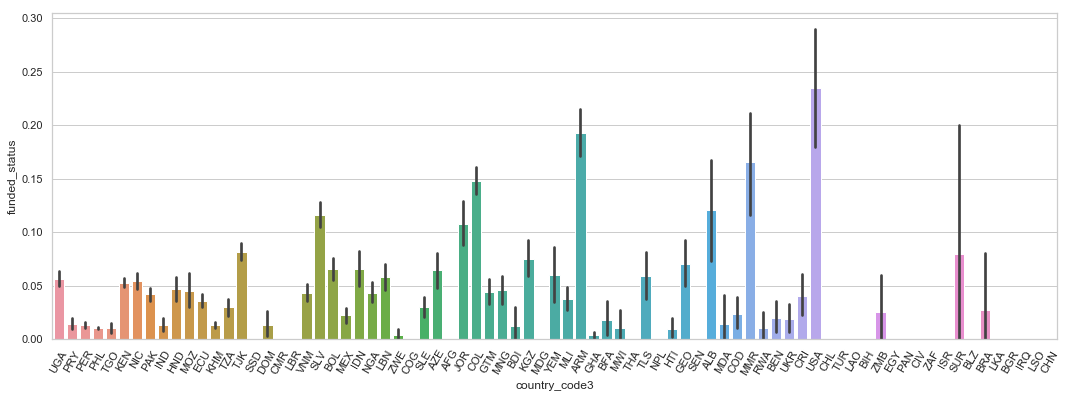

In [131]:
plt.figure(figsize=(18,6))
plt.xticks(rotation=60)
sns.barplot(x="country_code3", y="funded_status", data=working_df)

#### National distribution
The nation-level spread of unfunded loans is interesting.  The USA, unsurprisingly, leads the pack, likely due to American borrowers not triggering as much sympathy as borrowers from developing countries.  After that we have Armenia, Myanmar, Colombia, Albania, Slovakia, and Jordan as the next six highest, representing heavily from eastern Europe, and one country each from the Middle East, southeast Asia, and Latin America.  

Why these countries?  Unkown, at this point, though I'd make a guess that it has something to do with corruption, local politics, or perhaps some cultural quirk(s) that leads borrowers to create less-appealing-than-average loan profiles.

### 7.2.3 Clustering variation in funding
Below is the barplot for the geoeconomic clusters' intersection with funded_status, set above the corresponding countplot, so that you can get a sense for how many loans each individual cluster represents.

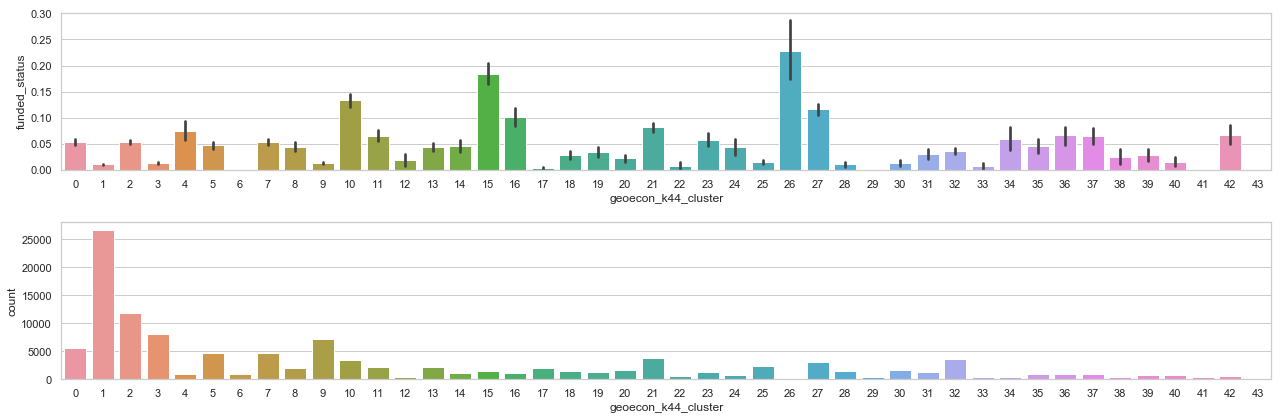

In [129]:
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
sns.barplot(x="geoecon_k44_cluster", y="funded_status", data=working_df)
plt.subplot(2, 1, 2)
sns.countplot(x="geoecon_k44_cluster", data=working_df)
plt.tight_layout()

#### Geoeconomic clusters' funding odds
The thing to look for with the above plots is intersections between high-count clusters and high or low average funded_status.  (It's also worth reminding the reader that our dataset's average unfunded percentage is 3.8%, and "high" or "low" funding status is relative to that point of reference.) 

Of particular interest are clusters 1, 3, 9, 17, and 28, which have notably lower unfunded loans than average, and 4, 10, 11, 15, 16, 21, and 27, which have notably higher unfunded loans than average.  Overall, those five lower-unfunded clusters represent 45,480 loans out of a 1/10 size sample of 118,730, while the seven higher-unfunded clusters only represent 16,039 loans.  In the latitude/longitude plots below, we can (unsurprisingly) see the countries with notably high unfunded loan rates represented fairly clearly.  The Phillipines, represented by cluster 1, has the vast majority of loans in the low-unfunded grouping, and is both the biggest single cluster as well as one of the lower-unfunded clusters.

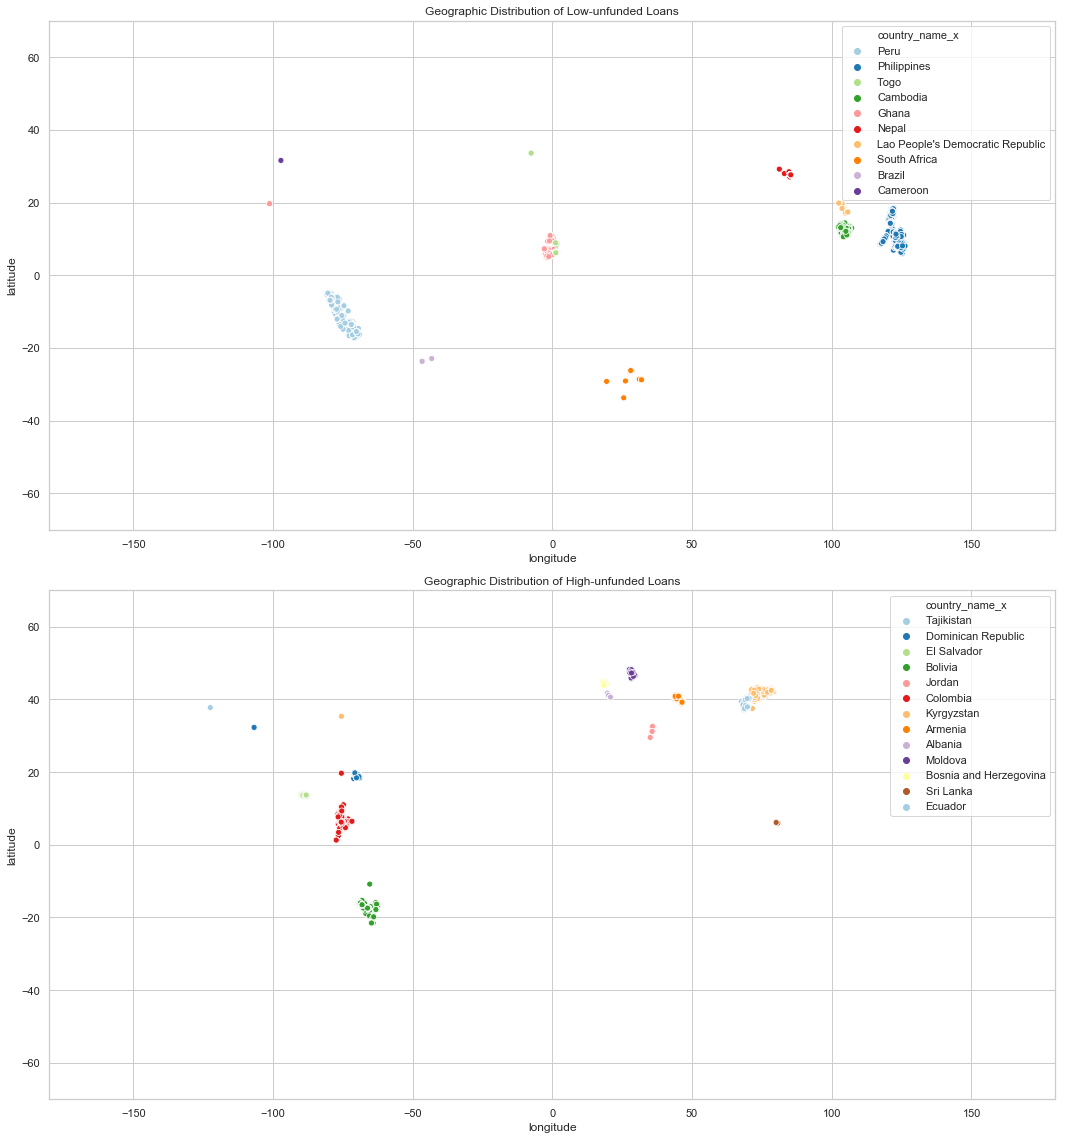

In [163]:
low_unfunded_clusters = [1,3,9,17,28]
high_unfunded_clusters = [4,10,11,15,16,21,27]

plt.figure(figsize=(15,16))
plt.subplot(2, 1, 1); plt.ylim(-70, 70); plt.xlim(-180, 180)
plt.title('Geographic Distribution of Low-unfunded Loans')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df.loc[working_df['geoecon_k44_cluster'].isin(low_unfunded_clusters)],
                hue='country_name_x', legend='full', palette = "Paired")
plt.subplot(2, 1, 2); plt.ylim(-70, 70); plt.xlim(-180, 180)
plt.title('Geographic Distribution of High-unfunded Loans')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df.loc[working_df['geoecon_k44_cluster'].isin(high_unfunded_clusters)],
                hue='country_name_x', legend='full', palette = "Paired")
plt.tight_layout()
plt.show()

#### Purely economic clusters and unfunded rates
The barplots and countplots below are the lower-count clusterings, set so that it's easy to compare the relative size and unfunded rate for each cluster.

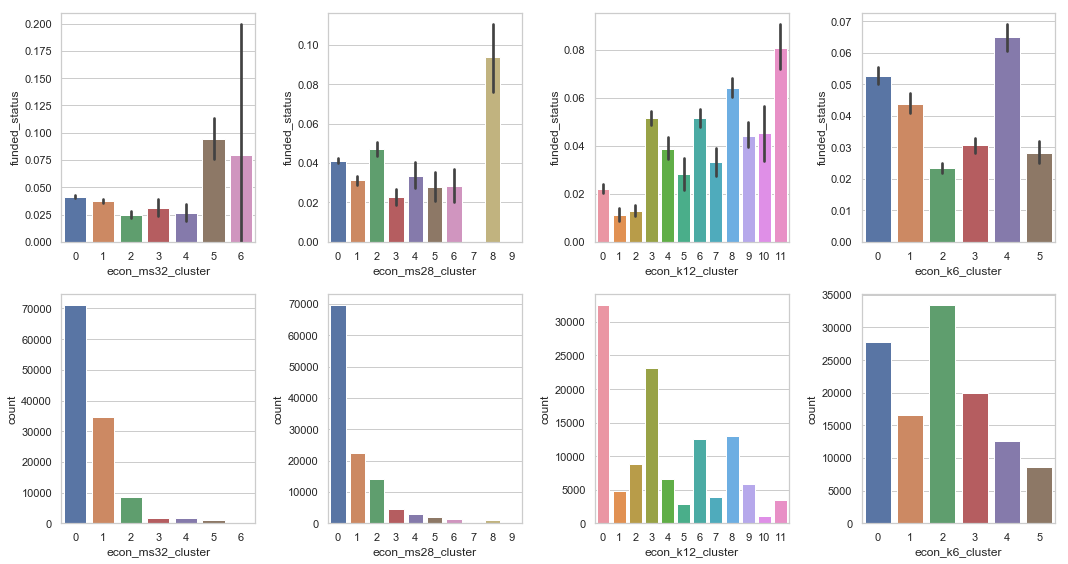

In [130]:
plt.figure(figsize=(15,8))
plt.subplot(2, 4, 1)
sns.barplot(x="econ_ms32_cluster", y="funded_status", data=working_df)
plt.subplot(2, 4, 2)
sns.barplot(x="econ_ms28_cluster", y="funded_status", data=working_df)
plt.subplot(2, 4, 3)
sns.barplot(x="econ_k12_cluster", y="funded_status", data=working_df)
plt.subplot(2, 4, 4)
sns.barplot(x="econ_k6_cluster", y="funded_status", data=working_df)
plt.subplot(2, 4, 5)
sns.countplot(x="econ_ms32_cluster", data=working_df)
plt.subplot(2, 4, 6)
sns.countplot(x="econ_ms28_cluster", data=working_df)
plt.subplot(2, 4, 7)
sns.countplot(x="econ_k12_cluster", data=working_df)
plt.subplot(2, 4, 8)
sns.countplot(x="econ_k6_cluster", data=working_df)
plt.tight_layout()

These plots bring up close the disadvantages of Mean-Shift as a clustering algorithm - it has nearly zero effective clustering impact on the funded_status, as the vast majority of the loans are in clusters that match the dataset's average funded_status, and the higher-than-average-funded_status clusters are miniscule, and don't give us much information at all.

On the other hand, K-Means does seem to offer our algorithm a slight advantage in separating funded from unfunded loans, with significant variation in both size and funded_status within both sets of clusters.  I've separated out the clusters that have significant variation from the average funded_status rate, and punched them into a geographic distribution below so that you can get a sense for their geographic spread.

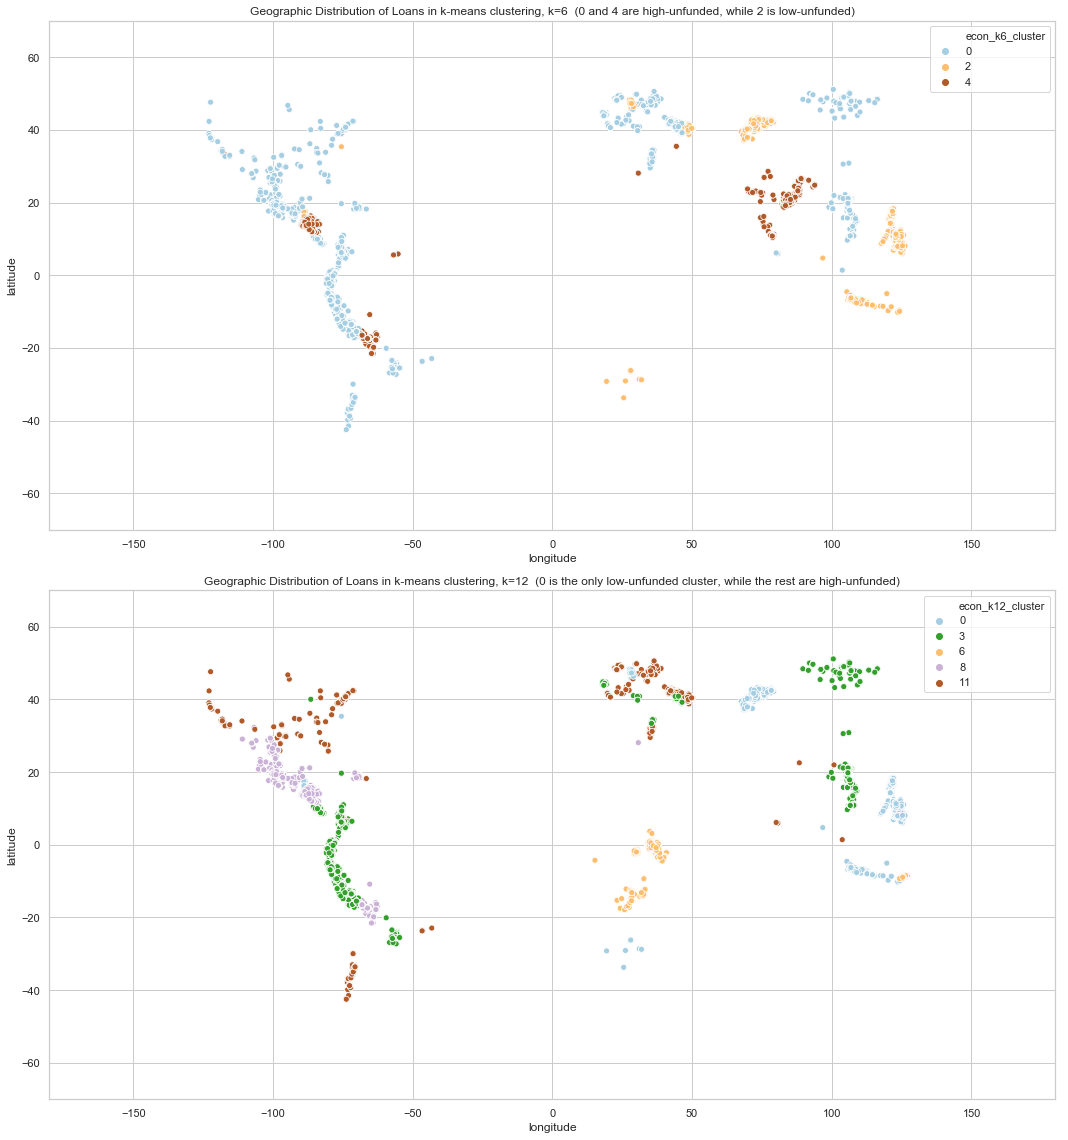

In [174]:
km_12 = [0,3,6,8,11]
km6 = [0,2,4]

plt.figure(figsize=(15,16))
plt.subplot(2, 1, 1); plt.ylim(-70, 70); plt.xlim(-180, 180)
plt.title('Geographic Distribution of Loans in k-means clustering, k=6  (0 and 4 are high-unfunded, while 2 is low-unfunded)')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df.loc[working_df['econ_k6_cluster'].isin(km6)],
                hue='econ_k6_cluster', legend='full', palette = "Paired")
plt.subplot(2, 1, 2); plt.ylim(-70, 70); plt.xlim(-180, 180)
plt.title('Geographic Distribution of Loans in k-means clustering, k=12  (0 is the only low-unfunded cluster, while the rest are high-unfunded)')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df.loc[working_df['econ_k12_cluster'].isin(km_12)],
                hue='econ_k12_cluster', legend='full', palette = "Paired")
plt.tight_layout()
plt.show()

# 8.0. Parting thoughts
By themselves, none of these variables are able to be a decisive indicator of when a loan is going to fail to fund, but added to all of the other variables we have, they provide enough for the algorithm to get a rough sense for when Kiva should be either giving a loan a closer look before accepting it, or putting effort into trying to improve its odds of successfully funding.


## 8.1. Shortcomings
No analysis is perfect, and no model is without tradeoffs.  In this case, the model's performance itself is less than stellar, and while it's thankfully not overfitting at all, the low f1 score for unfunded loans means that there's still significant room for improvement.  

Another issue with the model is what I left out in the feature-creation process, specifically the information held within the loan_use and description columns.  These are (likely) information-dense with regard to our target variable, but getting the information out in a large sample size would have fried my computer's RAM, so I was forced to leave them be.

Beyond that, I am *certain* that there are other things I've missed, overlooked, or slipped up on, but I'm drawing a blank for the moment.  Any feedback you have would be very welcome.

## 8.2. Further explorations
There are *many* different avenues that one could continue to pursue beyond what I've done here to improve upon this notebook's foundation.

1) Perform a linguistic breakdown of the 'loan_use', 'description', and 'description_translated' features, analysing which keywords in any of these columns have an impact on a loan's likelihood of being funded.

2) Further optimization of the dummy-PCA features; experimenting with which features are included in the PCA algorithm, and how many features should be extracted from the PCA for optimal performance.

3) Deeper analysis of funding by time-period; major changes have occurred throughout Kiva's operational history, and the algorithm's performance might be better served by breaking down the dataframe into operational time periods to analyze, rather than trying to look at the whole spread at once.

4) A more expansive approach to clustering.  I took a look at the national data and immediately thought that that was going to be less-than-useful, as stratified as it was, and so focused my efforts with unsupervised learning on trying to condense the national data into something more useful.  There are likely a number of other avenues for using clustering algorithms that could be productively pursued.

5) Integrating localized economic data into the model.  Some of Kiva's datasets (mpi_region_locations and themes_by_region, from their Data Science for Good page) include very localized economic data, down to the town or village level in some cases.  However, due to the sheer scale of the loan dataset involved and the poor match between the localities in the regional dataframes and the loan dataset, I decided to focus on the national data rather than spending the time needed to clean and mesh the other two into my efforts.  However, given the heterogeneity of economic situations in a given country, being able to pinpoint the economic situation of a borrower might be a worthwhile addition to the algorithm, if one has the time to add those datasets into the mix.

# 1.0.1 Import libraries

In [1]:
# basics
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
# set the default size and style of the seaborn figures
sns.set(rc={'figure.figsize':(16,8)})
sns.set(style="whitegrid")


# miscellany
import collections
import gc  # garbage emptier; removes deleted stuff from RAM
from itertools import cycle
from IPython.display import display
import os
import pydotplus
from timeit import default_timer as timer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
import sklearn

# datasets
from sklearn import datasets
from sklearn.datasets import load_digits

# exceptions
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MultiLabelBinarizer

# utils
from sklearn.utils import shuffle
from sklearn.utils import resample

In [3]:
# modeling tools
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# supervised learning algorithms
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier

# clustering algorithms
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [4]:
# Keras and Tensorflow
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD, adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Import the backend
from keras import backend as K

# import PIL
import PIL as pil
from PIL import Image

Using TensorFlow backend.


## 1.0.2 Define Functions

In [5]:
# 'encoding_function' lets us take a list of features in a dataframe, select any that aren't already numeric, 
# and encode each of their unique values as numeric values
def encoding_function(df, features_list):
    # selecting the chosen features out of the dataframe
    selected_data = df.loc[:, features_list]  
    # isolate the categorical/non-numeric features
    categorical_features = list(selected_data.select_dtypes(include=object).columns)
    for feature in categorical_features:  # run the encoder on the categorical features
        encoder = LabelEncoder()
        selected_data[feature] = encoder.fit_transform(selected_data[feature])
    # return all of the data, with the categorical features encoded, as a new dataframe
    return(selected_data) 

In [6]:
# a function to make generating a classification report easier, combined with a cross-valuation test
def accuracy_report(testing_X, testing_Y, model, cv):  
    predictions = model.predict(testing_X)
    print('Model score:')
    print(model.score(testing_X, testing_Y))
    print(" ")
    print("Classification Report:")
    y_prediction = model.predict(testing_X)
    print(classification_report(testing_Y, y_prediction))
    
    # Sometimes we don't want to spend the processor time calculating the cross-valuation, 
    # so we need a way to toggle it.
    if cv == 1:
        print(" ")
        print('Model cross-valuation:')
        print(sklearn.model_selection.cross_val_score(model, testing_X, testing_Y, cv = 5))
    return

In [7]:
# for instances where you want to test multiple different sets of features to see which combination works best
# sort of a poor-man's SelectKBest, but it does serve to reveal things that SKB keeps inside its black box
# note that list_of_feature_lists needs to be a list containing lists of strings corresponding to column titles
def multifeature_accuracy_report(X_train, X_test, y_train, y_test, list_of_feature_lists, model):
    counter = 0
    for feature_list in list_of_feature_lists:
        counter = counter + 1
        selected_X_train = X_train.loc[:, feature_list]
        selected_X_test = X_test.loc[:, feature_list]
        model.fit(selected_X_train, y_train)
        predictions = model.predict(selected_X_test)
        print('f1 score for feature list#{}: {}' .format(counter, sklearn.metrics.f1_score(y_test, predictions)))
        print('Model score for feature list #{}: {}'.format(counter, model.score(selected_X_test, y_test)))
    return

In [8]:
# a function to more easily upsample a minority class in a badly lopsided sample
# note that this can work when n classes > 2, you just need to repeat the function for each minority class
def upsample_function(df, y_name, minority_class, multiplier):
    
    df_majority = df.loc[df[str(y_name)]!=minority_class]
    df_minority = df.loc[df[str(y_name)]==minority_class]
     
    minority_size = df_minority.shape[0]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples= int(minority_size*multiplier),  
                                     random_state=123) 

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
     
    return df_upsampled

In [9]:
# a function to more easily downsample a class in a badly lopsided sample
# note that this does NOT function well when n classes > 2, as it will downsample everything but the minority_class
def downsample_function(df, y_name, minority_class, multiplier):
    
    df_majority = df.loc[df[y_name]!=minority_class]
    df_minority = df.loc[df[y_name]==minority_class]
    
    majority_size = df_majority.shape[0]
    
    # Upsample minority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples= int(majority_size*multiplier),  
                                     random_state=123) 

    # Combine majority class with upsampled minority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
     
    return df_downsampled

In [10]:
# this function takes a feature list to be modeled, the degree of upsampling and downsampling to be done,
# and the fraction of the sample to use as a training set, and prepare the dataframe for modeling, 
# separating out training and testing data sets for both X and Y features.
def dataprep_for_modeling(feature_list, df, upsample_multiplier, downsample_multiplier, training_fraction):
    
    # encode the data, just to be sure we're not giving the algorithm stuff it can't understand
    data_to_model = encoding_function(df, feature_list)
    encoder = LabelEncoder()
    
    # separate out the training and testing samples
    training_X = data_to_model.sample(frac=training_fraction, random_state=10)
    testing_X = data_to_model.drop(training_X.index)
    
    # print out the pre-up/downsampling ratio of our target variable's classes
    counter = collections.Counter(training_X['funded_status'])
    print(counter)
    
    # perform the up/downsampling
    training_X = upsample_function(training_X, 'funded_status', 1, upsample_multiplier) 
    training_X = downsample_function(training_X, 'funded_status', 1, downsample_multiplier)
    
    # print out the post-up/downsampling ratio of our target variable's classes
    counter = collections.Counter(training_X['funded_status'])
    print(counter)
    
    # separate the Y feature out into Y datasets
    training_Y = training_X['funded_status']
    testing_Y = testing_X['funded_status']

    # drop the Y feature from the X datasets so that the model isn't able to cheat
    training_X.drop('funded_status', axis=1, inplace=True)
    testing_X.drop('funded_status', axis=1, inplace=True)

    return(training_X, testing_X, training_Y, testing_Y)

In [11]:
# this function creates a 2D array featuring an incrementing value starting with 1 in the center, 
# and increasing by 1 for every step as it spirals outwards towards the edge of the array

# spiral-creation function taken from https://stackoverflow.com/questions/36834505/creating-a-spiral-array-in-python
# some modifications have been made to let it work
NORTH, S, W, E = (0, -1), (0, 1), (-1, 0), (1, 0) # directions
turn_right = {NORTH: E, E: S, S: W, W: NORTH} # old -> new direction
turn_left = {NORTH: W, E: NORTH, S: E, W: S} # old -> new direction

def spiral(width, height):
    if width < 1 or height < 1:
        raise ValueError
    if width%2 == 0:
        x, y = (width // 2) - 1, (height // 2)-1 # start near the center
    else:
        x, y = width // 2, height // 2 # start near the center
    dx, dy = NORTH # initial direction
    matrix = [[None] * width for _ in range(height)]
    count = 0
    while True:
        count += 1
        matrix[y][x] = count # visit
        # try to turn
        new_dx, new_dy = turn_right[dx,dy]
        new_x, new_y = x + new_dx, y + new_dy
        if (0 <= new_x < width and 0 <= new_y < height and
            matrix[new_y][new_x] is None): # can turn right
            x, y = new_x, new_y
            dx, dy = new_dx, new_dy
        else: # try to move straight
            x, y = x + dx, y + dy
            if not (0 <= x < width and 0 <= y < height):
                return matrix # nowhere to go


In [12]:
# this function converts the pattern of the 2D spiral array into a 1D list that can be converted *back* into
# an array for the purposes of Convolution, and then replaces the numeric values with feature names,
# creating a 1D list of feature titles that, when converted into a 2D spiral, will have the most-important
# features appearing closer the center of the spiral.
def create_spiral_features(spiral_size, feature_list):
    # flatten the 2D array into a 1D list
    spiral_skeleton = spiral(spiral_size,spiral_size)
    spiral_skeleton = np.asarray(spiral_skeleton)
    print(spiral_skeleton)
    spiral_skeleton = spiral_skeleton.flatten()
    spiral_skeleton = spiral_skeleton.tolist()

    # create a new list of features corresponding in importance to the value on the flattened spiral
    spiral_feature_list = []
    for x in range(len(spiral_skeleton)):
        spiral_feature_list.append(feature_list[spiral_skeleton[x]-1])

    print('feature list length: ' + str(len(spiral_feature_list)))
    return(spiral_feature_list)

## 1.1. Upload data

In [13]:
expanded_loans_df = pd.read_csv("additional-kiva-snapshot/loans.csv")
country_stats_df = pd.read_csv("additional-kiva-snapshot/country_stats.csv")
loan_coords_df = pd.read_csv("additional-kiva-snapshot/loan_coords.csv")
locations_df = pd.read_csv("additional-kiva-snapshot/locations.csv")
#lenders_df = pd.read_csv("additional-kiva-snapshot/lenders.csv")

#mpi_region_locations = pd.read_csv("kiva_mpi_region_locations.csv")
#kiva_loans_df = pd.read_csv("kiva_loans.csv")
#loan_theme_ids = pd.read_csv("loan_theme_ids.csv")
#themes_by_region = pd.read_csv("loan_themes_by_region.csv")

## 1.2. Merge datasets

In [14]:
# My consistent habit when writing code that I might reuse in future projects is to use a single label for
# my primary dataframe, the one that I'm actually doing operations on.  Any reference to 'working_df' is to this
# primary working dataframe.

# create the working_df by adding the loan_coords to the loans dataframe
working_df = pd.merge(expanded_loans_df, loan_coords_df, on='loan_id', how = 'inner')
working_df.shape

(1216487, 33)

In [15]:
# add in the national data so that each loan has the corresponding country's national data attached
working_df = pd.merge(working_df, country_stats_df, on='country_code', how = 'inner')
working_df.shape

(1216471, 45)

In [16]:
# delete the biggest RAM user, expanded_loans_df; we can re-upload it later if need be
del [[expanded_loans_df]]
gc.collect()
expanded_loans_df=pd.DataFrame()

In [17]:
# delete the other dataframes to clear up what little RAM they're taking up
del [[country_stats_df,loan_coords_df,locations_df]]
gc.collect()
country_stats_df=pd.DataFrame()
loan_coords_df=pd.DataFrame()
locations_df=pd.DataFrame()

In [18]:
working_df.head(1)  

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name_x,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,latitude,longitude,country_name_y,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.000,125.000,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.100,PHP,126.000,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.000,3,2,1,NaN,female,true,irregular,field_partner,8.162,123.774,Philippines,PHL,Asia,South-eastern Asia,104918090,21.600,0.682,68.340,11.733,9.327,8395.095,Philippines


In [19]:
os.system('say "all done with basic dataset prep."'); print('\a')




## 1.3. Cleaning

In [20]:
# fill in all textual features currently NaN with the appropriate variation on 'no entry'
working_df['tags'].fillna('no tags', inplace=True)
working_df['loan_use'].fillna('no loan_use given', inplace=True)
working_df['description_translated'].fillna('no translation', inplace=True)
working_df['description'].fillna('no description', inplace=True)
working_df['loan_name'].fillna('no name', inplace=True)

In [21]:
working_df.drop('currency_exchange_coverage_rate', axis=1, inplace=True)
# it's binary, a fifth of the entries are NaN, and it has a vanishingly small influence on
# the funded/unfunded feature.  Drop it.

working_df.drop('planned_expiration_time', axis=1, inplace=True)
# Remove this variable; it doesn't represent anything critical; only a small boost upwards in time frame, 
# and all NaN rows are from pre-2012, while all filled rows are from 2012 onwards

working_df.drop('raised_time', axis=1, inplace=True)
# 'raised_time' is when the loan finished being funded by crowdfunding; if it's blank, then that means the loan
# never got fully funded; this means that this feature is part of our target, and can't be included in the data

working_df.shape

(1216471, 42)

In [22]:
# drop all instances of 'status' that are 'fundRaising', as they are neither funded nor unfunded
working_df.drop(working_df.loc[working_df['status']=='fundRaising'].index, inplace=True)

In [23]:
working_df.dropna(inplace=True)
# 'population_below_poverty_line', 'gni', and 'life_expectancy' are empty in only 5 countries, 
# and all entries for those countries are missing entries for this variable.
# Removing these will remove all loans to Kosovo, Solomon Islands, Somalia, Palestine, and Samoa, ~25k loans

working_df.shape

(1187680, 42)

In [24]:
os.system('say "all done with cleaning."'); print('\a')




## 1.4. Resize sample

In [25]:
# I'm working on a computer with 8GB of RAM.  I need some way to cut the size 
# of the dataframe in order to be able to do some of the modeling with a more-manageably-sized sample.
# This will create a new df with a specified percentage of the original's rows, delete the old one, 
# and then rename the new one as the old one so there are no continuity errors.
# Note: ONLY DO THIS ONCE

sample_ratio = .1
sample_size = int(len(working_df.index) * sample_ratio)
print('New dataframe length: ' + str(sample_size))

new_working_df = working_df.sample(n=sample_size, random_state=1)

del [[working_df]]
gc.collect()
working_df=pd.DataFrame()

working_df = new_working_df

del [[new_working_df]]
gc.collect()
new_working_df=pd.DataFrame()

New dataframe length: 118768


In [26]:
working_df.shape

(118768, 42)

In [27]:
os.system('say "finished reshaping the dataframe."'); print('\a')




## 2.1. Feature prep, part 1

### 2.1.1 Target feature creation

In [28]:
# create a feature for the difference between the funding and loan amounts, and then a binary feature to 
# distinguish between funded and unfunded loans
working_df['funded_loan_difference'] = working_df['loan_amount'] - working_df['funded_amount']
working_df['funded_status'] = 0
working_df.funded_status.loc[(working_df['funded_loan_difference'] != 0)] = 1

# remove any loans where the 'funded_loan_difference' indicates a different result than 'status'
working_df.drop(working_df[(working_df['status'] == 'funded') & 
                           (working_df['funded_status'] == 1)].index, inplace=True)

working_df.drop(working_df[(working_df['status'] == 'expired') & 
                           (working_df['funded_status'] == 0)].index, inplace=True)

working_df.shape

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(118768, 44)

### 2.1.2 Break down time-based features

In [29]:
# Break the posted date into a set of integer features

working_df['posted_year'] = working_df['posted_time'].str[2:4]
working_df['posted_year'] = working_df['posted_year'].astype(int)

working_df['posted_month'] = working_df['posted_time'].str[5:7]
working_df['posted_month'] = working_df['posted_month'].astype(int)

working_df['posted_day'] = working_df['posted_time'].str[8:10]
working_df['posted_day'] = working_df['posted_day'].astype(int)

# make a variable for the rough day of the year when it was posted
working_df['posted_yearfraction'] = working_df['posted_day'] + (working_df['posted_month']-1)*30.4

# make a similar variable for the rough (not accounting for leap years) day of the dataset's collection, 
# starting with Jan 1, 2005 as the first day
working_df['posted_multiyear_day'] = working_df['posted_yearfraction'] + (working_df['posted_year']-5)*365


In [30]:
# Break the disbursed date into a set of integer features

working_df['disburse_year'] = working_df['disburse_time'].str[2:4]
working_df['disburse_year'] = working_df['disburse_year'].astype(int)

working_df['disburse_month'] = working_df['disburse_time'].str[5:7]
working_df['disburse_month'] = working_df['disburse_month'].astype(int)

working_df['disburse_day'] = working_df['disburse_time'].str[8:10]
working_df['disburse_day'] = working_df['disburse_day'].astype(int)

# make a variable for the rough day of the year when it was posted
working_df['disburse_yearfraction'] = working_df['disburse_day'] + (working_df['disburse_month']-1)*30.4

# make a similar variable for the rough (not accounting for leap years) day of the dataset's collection, 
# starting with Jan 1, 2005 as the first day
working_df['disburse_multiyear_day'] = working_df['disburse_yearfraction'] + (working_df['disburse_year']-5)*365


In [31]:
# create a feature for the difference between posting and disperse times.
# note that this can be negative, as the posting frequently happens AFTER the local agent gives the loan out;
# Kiva in this case is collecting microloans to cover the initial loan their agent made.

working_df['post_disperse_difference'] = working_df['disburse_multiyear_day'] - working_df['posted_multiyear_day']

### 2.1.3 Create time-based PCAs

In [32]:
# since the year and time of year have turned out to be important to our predictive algorithm, and 
# we have a lot of features that are highly correlated with each other, let's boil the eight most important ones
# down into two PCA-generated features

# generate the year-based PCA
pca = PCA(n_components=1)
pca_results = pca.fit_transform(working_df[['disburse_multiyear_day', 'posted_multiyear_day',
                                           'disburse_year', 'posted_year']])

# join the PCA up with the working dataframe
working_df['loan_year_PCA'] = pca_results[:,0]

# generate the month/time-of-year PCA
pca = PCA(n_components=1)
pca_results = pca.fit_transform(working_df[['posted_month', 'posted_yearfraction', 
                                           'disburse_yearfraction', 'disburse_month']])

# join the PCA up with the working dataframe
working_df['loan_month_PCA'] = pca_results[:,0]

### 2.1.4 Expanding on borrower_genders features

In [33]:
# function to split the string by commas
def genders_splitter(x):
    output = x.split(', ')
    return(output)

# function to count how many occurances of 'male' are in the list created by the split
def count_male(x):
    output = x.count('male')
    return(output)

# function to count how many occurances of 'female' are in the list created by the split
def count_female(x):
    output = x.count('female')
    return(output)

In [34]:
# use the split function to create a list for each borrower_genders, even if it's a list of n=1
working_df['borrower_gender_list'] = working_df['borrower_genders'].apply(genders_splitter)

# make features for the numbers of male/female borrowers
working_df['male_borrowers'] = working_df['borrower_gender_list'].apply(count_male)
working_df['female_borrowers'] = working_df['borrower_gender_list'].apply(count_female)

# make a binary feature to mark loans where both male & female borrowers were listed
working_df['mixed_gender_borrowers'] = 0
working_df.loc[working_df.male_borrowers > 0, 'mixed_gender_borrowers'] = 1
working_df.loc[working_df.female_borrowers == 0, 'mixed_gender_borrowers'] = 0

# make a feature to count how many borrowers total were listed for the loan
working_df['borrower_count'] = working_df['male_borrowers'] + working_df['female_borrowers']

# drop the list feature, because some functions fail when you process a list through them
working_df.drop('borrower_gender_list', axis=1, inplace=True)

### 2.1.5 Expanding on borrower_pictured features

In [35]:
# function to split the string by commas
def pictured_splitter(x):
    output = x.split(', ')
    return(output)

# function to count how many occurances of 'true' are in the list created by the split
def count_true(x):
    output = x.count('true')
    return(output)

# function to count how many occurances of 'false' are in the list created by the split
def count_false(x):
    output = x.count('false')
    return(output)

In [36]:
# use the split function to create a list for each borrower_pictured, even if it's a list of n=1
working_df['borrower_pictured_list'] = working_df['borrower_pictured'].apply(pictured_splitter)

# make features for the numbers of pictured/unpictured borrowers
working_df['pictured_borrowers'] = working_df['borrower_pictured_list'].apply(count_true)
working_df['unpictured_borrowers'] = working_df['borrower_pictured_list'].apply(count_false)

# make a feature that's the ratio of the number of pictured borrowers to total borrowers
working_df['pictured_ratio'] = working_df['pictured_borrowers']/(working_df['pictured_borrowers'] +
                                                                 working_df['unpictured_borrowers'])

# drop the list feature, because some functions fail when you process a list through them
working_df.drop('borrower_pictured_list', axis=1, inplace=True)

### 2.1.6 Expanding out the tags features

In [37]:
# make a function to split the tags into a list
# note that the tags are NOT consistently formatted; this function serves to deal with the worst formatting
# and prevent duplication, but there is still the possibility that some 
# wierdly-formatted tags fell through the cracks
def tags_splitter(x):
    x = x.replace(", #", "#")
    x = x.replace(", ","#")
    x = x.replace(",","#")
    output = x.split('#')
    output = list(dict.fromkeys(output))
    return(output)

In [38]:
mlb = MultiLabelBinarizer()

# create a new dataframe with only the tags column
tags_df = pd.DataFrame(data=working_df['tags'])
# create a new column containing the list created by the tags_splitter function
tags_df['tags_list'] = tags_df['tags'].apply(tags_splitter)

s = tags_df['tags_list']
# separate out each tag into a binary column for each of the loans
tags_df_binaries = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=tags_df.index)

# drop the empty-titled column that forms due to a '#' being in front of the tags string
tags_df_binaries.drop('', axis = 1, inplace = True)

In [39]:
# get a list of our columns; this CAN change, if the resizing is drastic enough to drop all instances of a tag
tag_features = tags_df_binaries.columns.tolist()

In [40]:
# Tack the new columns onto the working_df
working_df = pd.concat([working_df, tags_df_binaries], axis=1, join='inner')

In [41]:
# clean up the now-extraneous dataframes to clear up RAM
del [[tags_df_binaries,tags_df]]
gc.collect()
tags_df_binaries=pd.DataFrame()
tags_df=pd.DataFrame()

In [42]:
os.system('say "all done with string feature prep."'); print('\a')




In [43]:
print(working_df.shape)
#working_df.head(1)

(118768, 102)


### 2.1.7 Normalizing continuous features

In [44]:
# create a list of features that need to be normalized
normalize_features = ['loan_amount', 'lender_term', 'num_lenders_total', 'num_journal_entries', 'num_bulk_entries',
                      'population', 'population_below_poverty_line', 'hdi', 'life_expectancy',
                      'expected_years_of_schooling', 'mean_years_of_schooling', 'gni', 
                      'posted_multiyear_day', 'post_disperse_difference', 
                      'male_borrowers', 'female_borrowers', 'borrower_count',
                      'pictured_borrowers', 'unpictured_borrowers', 'pictured_ratio']

In [45]:
# Drop the most egregious outliers (see '6.0. Checking numeric features for outliers')
working_df.drop(working_df.loc[working_df['loan_amount'] > 12500].index, inplace=True)  # 184 being dropped

working_df.drop(working_df.loc[working_df['num_lenders_total'] > 2000].index, inplace=True)  # 5 being dropped

working_df.drop(working_df.loc[working_df['num_journal_entries'] > 40].index, inplace=True)  # 3 being dropped

working_df.drop(working_df.loc[working_df['post_disperse_difference'] < -300].index, inplace=True)# 186 being dropped

In [46]:
working_df.shape

(118730, 102)

In [47]:
min_max_scaler = preprocessing.MinMaxScaler()

# normalize the values of our selected features
x = working_df[normalize_features].values
x_scaled = min_max_scaler.fit_transform(x)
working_df_temp = pd.DataFrame(x_scaled, columns=normalize_features, index = working_df.index)
working_df[normalize_features] = working_df_temp
#working_df[normalize_features].head(2)

In [48]:
# clean up the now-extraneous dataframe to clear up RAM
del [[working_df_temp]]
gc.collect()
working_df_temp=pd.DataFrame()

In [49]:
working_df.shape

(118730, 102)

In [50]:
#working_df.isna().sum()

In [51]:
os.system('say "all done with normalizing features."'); print('\a')




### 2.1.8 Load clustering data

In [52]:
# I'd already generated clustering data, and saved it as a csv 
# (code below, see '3 Unsupervised Learning - Clustering')
geoeconomic_clusters = pd.read_csv("geocluster_data.csv")
print(geoeconomic_clusters.shape)
print(geoeconomic_clusters.columns)

(1190428, 11)
Index(['Unnamed: 0', 'loan_id', 'geoecon_k44_cluster', 'econ_k6_cluster',
       'econ_k12_cluster', 'econ_k24_cluster', 'econ_k36_cluster',
       'econ_ms32_cluster', 'econ_ms28_cluster', 'econ_ms19_cluster',
       'econ_ms16_cluster'],
      dtype='object')


In [53]:
# join the clustering data with the working_df based on the loan_id
# note that this is not dependent on the index being the same, just the loan_id column being present
working_df = working_df.join(geoeconomic_clusters.set_index('loan_id'), on='loan_id')
working_df.drop('Unnamed: 0', axis=1, inplace=True)
print(working_df.shape)

(118730, 111)


In [54]:
#working_df.head(2)

In [55]:
#working_df.isna().sum()

In [56]:
# clean up the now-extraneous dataframes to clear up RAM
del [[geoeconomic_clusters]]
gc.collect()
geoeconomic_clusters=pd.DataFrame()

In [57]:
os.system('say "all done adding clustering data."'); print('\a')




## 2.2. Feature prep part 2

### 2.2.1 Create dummy/binary features

In [58]:
# create a list of features that we want to break down into their binary dummy components
dummyable_features = ['activity_name', 'sector_name', 'currency', 'partner_id',
                      'econ_ms19_cluster', 'econ_ms16_cluster', 'econ_k24_cluster','econ_k36_cluster', 
                      'geoecon_k44_cluster']

In [59]:
# create a dataframe to contain the dummy features - note that this step takes a lot of memory
dummies_df=pd.DataFrame()
for feature in dummyable_features:
    dummies_df = pd.concat([dummies_df, pd.get_dummies(working_df[feature])], axis=1)
    print(str(feature) + ' dummy-ing complete; cumulative added features = ' + str(len(dummies_df.columns)))
    
dummy_columns = dummies_df.columns
dummy_columns = dummy_columns.tolist()

activity_name dummy-ing complete; cumulative added features = 157
sector_name dummy-ing complete; cumulative added features = 172
currency dummy-ing complete; cumulative added features = 240
partner_id dummy-ing complete; cumulative added features = 589
econ_ms19_cluster dummy-ing complete; cumulative added features = 625
econ_ms16_cluster dummy-ing complete; cumulative added features = 669
econ_k24_cluster dummy-ing complete; cumulative added features = 693
econ_k36_cluster dummy-ing complete; cumulative added features = 729
geoecon_k44_cluster dummy-ing complete; cumulative added features = 773


### 2.2.2 Create PCA features out of dummy feature-set

In [60]:
# we need to cut the variables down, otherwise my computer won't be able to cope.

# calculate PCA 
pca = PCA(n_components=20)
pca_results = pca.fit_transform(dummies_df)

# join the PCAs up with the working dataframe
working_df['dummies_PCA_1'] = pca_results[:,0]
working_df['dummies_PCA_2'] = pca_results[:,1]
working_df['dummies_PCA_3'] = pca_results[:,2]
working_df['dummies_PCA_4'] = pca_results[:,3]
working_df['dummies_PCA_5'] = pca_results[:,4]
working_df['dummies_PCA_6'] = pca_results[:,5]
working_df['dummies_PCA_7'] = pca_results[:,6]
working_df['dummies_PCA_8'] = pca_results[:,7]
working_df['dummies_PCA_9'] = pca_results[:,8]
working_df['dummies_PCA_10'] = pca_results[:,9]
working_df['dummies_PCA_11'] = pca_results[:,10]
working_df['dummies_PCA_12'] = pca_results[:,11]
working_df['dummies_PCA_13'] = pca_results[:,12]
working_df['dummies_PCA_14'] = pca_results[:,13]
working_df['dummies_PCA_15'] = pca_results[:,14]
working_df['dummies_PCA_16'] = pca_results[:,15]
working_df['dummies_PCA_17'] = pca_results[:,16]
working_df['dummies_PCA_18'] = pca_results[:,17]
working_df['dummies_PCA_19'] = pca_results[:,18]
working_df['dummies_PCA_20'] = pca_results[:,19]


In [61]:
# check that the merge didn't screw up
#working_df[['dummies_PCA_1','dummies_PCA_20']].head(10)

In [62]:
# clean up the now-extraneous dataframe to clear up RAM
del [[dummies_df]]
gc.collect()
dummies_df=pd.DataFrame()

In [63]:
os.system('say "all done with dummy features."'); print('\a')




## 2.3. Creating lists of features for ease of use

In [64]:
# note that we're not DOING anything with these lists yet, just labeling them so that we can more easily 
# grab them for operations in the future

discard_features = ['loan_id', 'loan_name', 'town_name', 'description', 'description_translated', 'loan_use',
                    'tags', 'borrower_genders', 'latitude', 'longitude', 'country_name_y', 'posted_time', 
                    'disburse_time', 'distribution_model']

preloan_features = ['original_language','loan_amount',  
                    'currency_policy', 'lender_term', 'repayment_interval']

postloan_features = ['num_lenders_total', 'num_journal_entries', 'num_bulk_entries']

cheat_features = ['funded_amount', 'status', 'funded_loan_difference', 'funded_status']
target_feature = ['funded_status']

national_features = ['country_code3', 'continent', 'region', 'population',
                     'population_below_poverty_line', 'hdi', 'life_expectancy',
                     'expected_years_of_schooling', 'mean_years_of_schooling', 'gni']

time_features = ['posted_year', 'posted_month', 'posted_day', 'posted_yearfraction',
                 'posted_multiyear_day', 'disburse_year', 'disburse_month',
                 'disburse_day', 'disburse_yearfraction', 'disburse_multiyear_day',
                 'post_disperse_difference']

time_PCA_features = ['loan_year_PCA', 'loan_month_PCA']

borrower_gender_features = ['male_borrowers', 'female_borrowers', 'mixed_gender_borrowers', 'borrower_count']

borrower_pictured_features = ['pictured_borrowers', 'unpictured_borrowers', 'pictured_ratio']

PCA_dummy_features = ['dummies_PCA_1', 'dummies_PCA_2', 'dummies_PCA_3', 'dummies_PCA_4', 'dummies_PCA_5',
                      'dummies_PCA_6', 'dummies_PCA_7', 'dummies_PCA_8', 'dummies_PCA_9', 'dummies_PCA_10',
                      'dummies_PCA_11', 'dummies_PCA_12', 'dummies_PCA_13', 'dummies_PCA_14', 'dummies_PCA_15',
                      'dummies_PCA_16', 'dummies_PCA_17', 'dummies_PCA_18', 'dummies_PCA_19', 'dummies_PCA_20']

# the dummy'd features
unbinarized_features = ['activity_name', 'sector_name', 'currency', 'partner_id',
                        'econ_ms19_cluster', 'econ_ms16_cluster', 'econ_k24_cluster','econ_k36_cluster', 
                        'geoecon_k44_cluster']

geoeconomic_cluster_features = ['econ_k6_cluster', 'econ_k12_cluster', 'econ_ms32_cluster', 'econ_ms28_cluster']

# combinations
basic_featureset = (preloan_features + national_features + time_PCA_features + borrower_gender_features + 
                    borrower_pictured_features + tag_features + PCA_dummy_features + geoeconomic_cluster_features)

basic_featureset_notags = (preloan_features + national_features + time_PCA_features + borrower_gender_features + 
                           borrower_pictured_features + PCA_dummy_features + geoeconomic_cluster_features)

basic_featureset_notime = (preloan_features + national_features + borrower_gender_features + tag_features + 
                           borrower_pictured_features + PCA_dummy_features + geoeconomic_cluster_features)

featureset_notags_notime = (preloan_features + national_features + borrower_gender_features + PCA_dummy_features + 
                            borrower_pictured_features  + geoeconomic_cluster_features)

basic_featureset_tagsyesno = (preloan_features + national_features + time_PCA_features + borrower_gender_features + 
                              borrower_pictured_features + PCA_dummy_features + geoeconomic_cluster_features + 
                              ['no tags'])

featureset_notime_tagsyesno = (preloan_features + national_features + borrower_gender_features + ['no tags'] +
                               borrower_pictured_features + PCA_dummy_features + geoeconomic_cluster_features)

In [65]:
os.system('say "all done setting up the data."'); print('\a')




In [67]:
working_df.head(1)

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name_x,town_name,currency_policy,currency,partner_id,posted_time,disburse_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model,latitude,longitude,country_name_y,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name,funded_loan_difference,funded_status,posted_year,posted_month,posted_day,posted_yearfraction,posted_multiyear_day,disburse_year,disburse_month,disburse_day,disburse_yearfraction,disburse_multiyear_day,post_disperse_difference,loan_year_PCA,loan_month_PCA,male_borrowers,female_borrowers,mixed_gender_borrowers,borrower_count,pictured_borrowers,unpictured_borrowers,pictured_ratio,Animals,Biz Durable Asset,Eco-friendly,Elderly,Fabrics,Female Education,First Loan,Health and Sanitation,Hidden Gem,Inspiring Story,Interesting Photo,Job Creator,Low-profit FP,Married,Orphan,Parent,Post-disbursed,Powerful Story,Refugee,Repair Renew Replace,Repeat Borrower,Schooling,Single,Single Parent,Supporting Family,Sustainable Ag,Team Guys Holding Fish,Technology,Tourism,Trees,Unique,Vegan,Widowed,Woman Owned Biz,no tags,user_favorite,user_like,volunteer_like,volunteer_pick,geoecon_k44_cluster,econ_k6_cluster,econ_k12_cluster,econ_k24_cluster,econ_k36_cluster,econ_ms32_cluster,econ_ms28_cluster,econ_ms19_cluster,econ_ms16_cluster,dummies_PCA_1,dummies_PCA_2,dummies_PCA_3,dummies_PCA_4,dummies_PCA_5,dummies_PCA_6,dummies_PCA_7,dummies_PCA_8,dummies_PCA_9,dummies_PCA_10,dummies_PCA_11,dummies_PCA_12,dummies_PCA_13,dummies_PCA_14,dummies_PCA_15,dummies_PCA_16,dummies_PCA_17,dummies_PCA_18,dummies_PCA_19,dummies_PCA_20
736221,922503,Sumaya Girls School,English,Greetings from Uganda! This is Yusuf. He is th...,Greetings from Uganda! This is Yusuf. He is th...,925.000,0.072,funded,Education provider,Education,to purchase a water filtration system to provi...,UG,Uganda,Wakiso,shared,UGX,329.000,2015-07-24 07:39:58.000 +0000,2015-07-03 07:00:00.000 +0000,0.128,0.063,0.027,0.000,"user_favorite, #Health and Sanitation, #School...",male,true,irregular,field_partner,0.063,32.447,Uganda,UGA,Africa,Eastern Africa,0.030,0.238,0.176,0.281,0.441,0.358,0.019,Uganda,0.000,0,15,7,24,206.400,0.790,15,7,3,185.400,3835.400,0.243,-792.754,-11.623,0.026,0.000,0,0.000,0.000,0.000,1.000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,3,4,3,9,1,1,7,8,-0.530,-0.158,-0.512,-0.606,-0.140,0.364,-0.338,1.909,-0.929,-0.007,-0.391,0.344,0.333,-0.147,0.046,-0.064,-0.059,0.025,-0.024,0.005


In [68]:
print(working_df.shape)
print(' ')
#print(working_df.isna().sum())

(1187298, 132)
 


# 3.0. Unsupervised Learning - Clustering

In [46]:
# take the person-centric features from the country_stats data, and create a feature-list
national_id_features = ['population_below_poverty_line',  # measured as a percentage of population
                        'hdi', # human development index, a measure of national poverty
                        'life_expectancy', # average life expectancy 
                        'expected_years_of_schooling',
                        'mean_years_of_schooling',
                        'longitude','latitude'] # the borrower's location when they asked for the loan

In [ ]:
# normalize the values of longitude and latitude

min_max_scaler = preprocessing.MinMaxScaler()

column_names_to_normalize = ['longitude','latitude']
x = working_df[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
loan_locations_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = working_df.index)
working_df[column_names_to_normalize] = loan_locations_temp
#working_df.head(10)

### 3.1. Geographic/Socio-Economic clusters

In [55]:
# run a wide range of numbers to see what gets the better silhouette score
range_n_clusters = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[national_id_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[national_id_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  5  The average silhouette_score is : 0.5419297639049154
For n_clusters =  10  The average silhouette_score is : 0.6001626650295389
For n_clusters =  20  The average silhouette_score is : 0.6994738602691727
For n_clusters =  30  The average silhouette_score is : 0.7908961175238101
For n_clusters =  40  The average silhouette_score is : 0.8456372023285514
For n_clusters =  50  The average silhouette_score is : 0.8353792556031662
For n_clusters =  60  The average silhouette_score is : 0.8526882328106776
For n_clusters =  70  The average silhouette_score is : 0.7905170304739996
For n_clusters =  80  The average silhouette_score is : 0.7933907059023725
For n_clusters =  90  The average silhouette_score is : 0.7774586372003837
For n_clusters =  100  The average silhouette_score is : 0.762157042821134


In [58]:
# narrow down the search...
range_n_clusters = [35, 40, 45, 50, 55, 60, 65]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[national_id_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[national_id_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  35  The average silhouette_score is : 0.8175188498354992
For n_clusters =  40  The average silhouette_score is : 0.8456372023285514
For n_clusters =  45  The average silhouette_score is : 0.8644679622446892
For n_clusters =  50  The average silhouette_score is : 0.8353792556031662
For n_clusters =  55  The average silhouette_score is : 0.8457854409572942
For n_clusters =  60  The average silhouette_score is : 0.8526882328106776
For n_clusters =  65  The average silhouette_score is : 0.8592210607714922


In [61]:
# narrow it even further...
range_n_clusters = [41,42,43,44,45,46,47,48,49]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[national_id_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[national_id_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  41  The average silhouette_score is : 0.8477566262124491
For n_clusters =  42  The average silhouette_score is : 0.8559392597307378
For n_clusters =  43  The average silhouette_score is : 0.8443635876461125
For n_clusters =  44  The average silhouette_score is : 0.8655329079272372
For n_clusters =  45  The average silhouette_score is : 0.8644679622446892
For n_clusters =  46  The average silhouette_score is : 0.8258663927910592
For n_clusters =  47  The average silhouette_score is : 0.8289245612031534
For n_clusters =  48  The average silhouette_score is : 0.8357110605257712
For n_clusters =  49  The average silhouette_score is : 0.8348614184533882


In [62]:
# Time to test out the individual silhouette scores, to see how much variation there is behind that average
clusterer = KMeans(n_clusters=44, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[national_id_features])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(working_df[national_id_features], cluster_labels)

In [78]:
# note that these columns will not be part of the final dataframe, they're just here for the clustering
# segment of the notebook
working_df['kmeans_k44_cluster'] = cluster_labels
working_df['kmeans_k44_silhouette'] = sample_silhouette_values

In [79]:
working_df.groupby('kmeans_k44_cluster', as_index=False)['kmeans_k44_silhouette'].mean()

,kmeans_k44_cluster,kmeans_k44_silhouette
0,0,0.897
1,1,0.716
2,2,0.922
3,3,0.901
4,4,0.982
5,5,0.905
6,6,0.792
7,7,0.875
8,8,0.982
9,9,0.966


#### Clustering the entire sample

In [51]:
# this was used for a clustering run on the entire >1 million sample
clusterer = KMeans(n_clusters=44, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[national_id_features])
working_df['kmeans_k44_cluster'] = cluster_labels

### 3.2. Socio-economic clusters

In [53]:
# specify socio-economic indicators
economic_indicator_features = ['population_below_poverty_line','hdi','life_expectancy',
                               'expected_years_of_schooling','mean_years_of_schooling']


#### 3.2.1 K-Means

In [84]:
# test out a range of sizes for the best silhouette scores
range_n_clusters = [3,4,5,6,7,8,9,10,12,14,16,18,20]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  3  The average silhouette_score is : 0.48726193212422475
For n_clusters =  4  The average silhouette_score is : 0.44936608183824417
For n_clusters =  5  The average silhouette_score is : 0.46370202156808105
For n_clusters =  6  The average silhouette_score is : 0.5031379704284099
For n_clusters =  7  The average silhouette_score is : 0.5246949513817161
For n_clusters =  8  The average silhouette_score is : 0.5451727219916994
For n_clusters =  9  The average silhouette_score is : 0.5755608837239767
For n_clusters =  10  The average silhouette_score is : 0.5839082128215107
For n_clusters =  12  The average silhouette_score is : 0.6252896137965863
For n_clusters =  14  The average silhouette_score is : 0.6460281251282216
For n_clusters =  16  The average silhouette_score is : 0.6919378257737211
For n_clusters =  18  The average silhouette_score is : 0.7245955786978365
For n_clusters =  20  The average silhouette_score is : 0.7526954107615036


In [86]:
# expand the search...
range_n_clusters = [23,26,29,32,35,38,41,44,47,50]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  23  The average silhouette_score is : 0.7908452983316582
For n_clusters =  26  The average silhouette_score is : 0.7976381005291076
For n_clusters =  29  The average silhouette_score is : 0.8403762001327871
For n_clusters =  32  The average silhouette_score is : 0.8753989310079926
For n_clusters =  35  The average silhouette_score is : 0.8959352780030981
For n_clusters =  38  The average silhouette_score is : 0.9166445652229434
For n_clusters =  41  The average silhouette_score is : 0.9408426952707951
For n_clusters =  44  The average silhouette_score is : 0.9492358661224564
For n_clusters =  47  The average silhouette_score is : 0.962932608997042
For n_clusters =  50  The average silhouette_score is : 0.9710201768123649


Prior experimentation showed that k of 5, 10, and 15, *in that order*, were actually quite useful for the supervised learning algorithm, so we will be using k = 6, 12, 24, and 36 for this feature-set.

In [89]:
# pick out our finalists
range_n_clusters = [6,12,24,36]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print("For n_clusters = ", n_clusters,
          " The average silhouette_score is :", silhouette_avg)

For n_clusters =  6  The average silhouette_score is : 0.5031379704284099
For n_clusters =  12  The average silhouette_score is : 0.6252896137965863
For n_clusters =  24  The average silhouette_score is : 0.7865789782153829
For n_clusters =  36  The average silhouette_score is : 0.9092159881760116


In [54]:
# run the finalists through on the full sample
clusterer = KMeans(n_clusters=6, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
working_df['econ_k6_cluster'] = cluster_labels

In [55]:
clusterer = KMeans(n_clusters=12, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
working_df['econ_k12_cluster'] = cluster_labels

In [56]:
clusterer = KMeans(n_clusters=24, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
working_df['econ_k24_cluster'] = cluster_labels

In [57]:
clusterer = KMeans(n_clusters=36, random_state=42)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
working_df['econ_k36_cluster'] = cluster_labels

### 3.2.2 Mean-Shift

In [100]:
# pick a range of bandwidths to test out, to isolate the best/better silhouette scores
range_bandwidth = [.07,.1,.13,.16,.19,.22,.25,.28,.31]

for bandwidth in range_bandwidth:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    n_clusters_ = len(np.unique(cluster_labels))
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print('For bandwidth =', bandwidth, 'there are', n_clusters_, 
          'clusters and the average silhouette_score is:', silhouette_avg)

For bandwidth = 0.07 there are 73 clusters and the average silhouette_score is: 0.971615244044428
For bandwidth = 0.1 there are 67 clusters and the average silhouette_score is: 0.958944917948578
For bandwidth = 0.13 there are 58 clusters and the average silhouette_score is: 0.8981662745891383
For bandwidth = 0.16 there are 44 clusters and the average silhouette_score is: 0.8472753807353656
For bandwidth = 0.19 there are 35 clusters and the average silhouette_score is: 0.785978836070225
For bandwidth = 0.22 there are 19 clusters and the average silhouette_score is: 0.48016671507989067
For bandwidth = 0.25 there are 15 clusters and the average silhouette_score is: 0.40729110667372387
For bandwidth = 0.28 there are 11 clusters and the average silhouette_score is: 0.4570876031951729
For bandwidth = 0.31 there are 7 clusters and the average silhouette_score is: 0.4148237709533924


In [102]:
# refine the search...
range_bandwidth = [.32,.31,.30,.29,.28,.27,.26]

for bandwidth in range_bandwidth:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    n_clusters_ = len(np.unique(cluster_labels))
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print('For bandwidth =', bandwidth, 'there are', n_clusters_, 
          'clusters and the average silhouette_score is:', silhouette_avg)

For bandwidth = 0.32 there are 7 clusters and the average silhouette_score is: 0.4154247093471361
For bandwidth = 0.31 there are 7 clusters and the average silhouette_score is: 0.4148237709533924
For bandwidth = 0.3 there are 8 clusters and the average silhouette_score is: 0.38964905433801184
For bandwidth = 0.29 there are 8 clusters and the average silhouette_score is: 0.40668847960355675
For bandwidth = 0.28 there are 11 clusters and the average silhouette_score is: 0.4570876031951729
For bandwidth = 0.27 there are 11 clusters and the average silhouette_score is: 0.41444415318996997
For bandwidth = 0.26 there are 13 clusters and the average silhouette_score is: 0.37135639178430613


Judging by past experimentation with SelectKBest, none of the MS clusters are going to be particularly effective for predicting funded_status, but we'll include some in the tests anyway, specifically bandwidth = .32, .28, .19, .16

In [104]:
# pick out our finalists
range_bandwidth = [.32, .28, .19, .16]

for bandwidth in range_bandwidth:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
    n_clusters_ = len(np.unique(cluster_labels))
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(working_df[economic_indicator_features], cluster_labels)
    print('For bandwidth =', bandwidth, 'there are', n_clusters_, 
          'clusters and the average silhouette_score is:', silhouette_avg)

For bandwidth = 0.32 there are 7 clusters and the average silhouette_score is: 0.4154247093471361
For bandwidth = 0.28 there are 11 clusters and the average silhouette_score is: 0.4570876031951729
For bandwidth = 0.19 there are 35 clusters and the average silhouette_score is: 0.785978836070225
For bandwidth = 0.16 there are 44 clusters and the average silhouette_score is: 0.8472753807353656


Now let's apply those bandwidths to the entire sample, and create features for each of them.

In [60]:
bandwidth = .32
clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
n_clusters_ = len(np.unique(cluster_labels))
print('For bandwidth =', bandwidth, 'there are', n_clusters_, 'clusters')

For bandwidth = .32 there are 7 clusters


In [61]:
working_df['econ_ms32_cluster'] = cluster_labels

In [62]:
bandwidth = .28
clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
n_clusters_ = len(np.unique(cluster_labels))
print('For bandwidth =', bandwidth, 'there are', n_clusters_, 'clusters')

For bandwidth = 0.28 there are 10 clusters


In [63]:
working_df['econ_ms28_cluster'] = cluster_labels

In [64]:
bandwidth = .19
clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
n_clusters_ = len(np.unique(cluster_labels))
print('For bandwidth =', bandwidth, 'there are', n_clusters_, 'clusters')

For bandwidth = 0.19 there are 36 clusters


In [65]:
working_df['econ_ms19_cluster'] = cluster_labels

In [66]:
bandwidth = .16
clusterer = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_labels = clusterer.fit_predict(working_df[economic_indicator_features])
n_clusters_ = len(np.unique(cluster_labels))
print('For bandwidth =', bandwidth, 'there are', n_clusters_, 'clusters')

For bandwidth = 0.16 there are 46 clusters


In [67]:
working_df['econ_ms16_cluster'] = cluster_labels

#### wrapping up clustering operations...

In [90]:
#working_df.head(100)

In [80]:
# create a list of our chosen features
geoeconomic_cluster_features = ['geoecon_k44_cluster', 'econ_k6_cluster', 'econ_k12_cluster', 'econ_k24_cluster',
                                'econ_k36_cluster', 'econ_ms32_cluster', 'econ_ms28_cluster', 'econ_ms19_cluster',
                                'econ_ms16_cluster']


In [86]:
# aaaand just to be sure I don't have to recompile all this again...
loan_id = ['loan_id']
save_list = loan_id + geoeconomic_cluster_features
working_df[save_list].to_csv("geocluster_data.csv")

# 4.0. Supervised Learning

## 4.1. SelectKBest
#### Round 1

In [68]:
# create our list of features to test
skb_test_features = (tag_features + borrower_gender_features + borrower_pictured_features + 
                     PCA_dummy_features + unbinarized_features + time_features + preloan_features + 
                     national_features + postloan_features)

# encode everything, to make sure nothing clogs the algorithm
skb_data = encoding_function(working_df, skb_test_features)

In [69]:
x = 50  # set how many features to go through in creating our list
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top50_features = []

for n in range(x):
    # for every n in x, we perform SKB
    selector = SelectKBest(f_classif, k=n)
    selector.fit(skb_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = skb_data.columns[mask]
    new_top_features = new_features.values.tolist()
    # for each n, we take the new feature that gets added to our top_features list, that wasn't there at n-1
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    # and add it to the ordered_top_features list, which gives us our top-performing features in order by the end
    ordered_top50_features = ordered_top50_features + most_recent_top
    # and then we reset the new_top_features to be the old_top_features, and do the whole thing over again
    old_top_features = new_top_features

In [70]:
print(str(x) + ' most important features, in order:')
print(ordered_top50_features)

50 most important features, in order:
['no tags', 'Parent', 'lender_term', 'loan_amount', 'disburse_multiyear_day', 'posted_multiyear_day', 'disburse_year', 'posted_year', 'num_journal_entries', 'male_borrowers', 'user_favorite', 'dummies_PCA_1', 'Biz Durable Asset', 'Vegan', 'Supporting Family', 'econ_k24_cluster', 'Repeat Borrower', 'dummies_PCA_10', 'dummies_PCA_5', 'country_code3', 'Repair Renew Replace', 'currency_policy', 'Woman Owned Biz', 'num_bulk_entries', 'currency', 'Single', 'Elderly', 'Animals', 'First Loan', 'original_language', 'partner_id', 'dummies_PCA_14', 'Schooling', 'dummies_PCA_13', 'expected_years_of_schooling', 'geoecon_k44_cluster', 'region', 'dummies_PCA_12', 'Sustainable Ag', 'dummies_PCA_4', 'female_borrowers', 'dummies_PCA_20', 'life_expectancy', 'dummies_PCA_7', 'Job Creator', 'repayment_interval', 'Low-profit FP', 'posted_month', 'posted_yearfraction']


#### Round 2
Obviously tags are critical, and the year in which the loan was posted is also super important; let's remove those and see which features float to the top without them to obscure.  The nation-level data is, again, important, though the fact that the nation-code itself is the most critical feature from that group implies that the rest are mostly there due to correlation with the nation-code; let's take those out.  The post-loan data wouldn't be available to Kiva before the loan was made, though, so despite its importance we should remove those features and see what the algorithm spits out.

In [71]:
skb_testset_round2 = (borrower_gender_features + PCA_dummy_features +
                      unbinarized_features + preloan_features + borrower_pictured_features)

In [72]:
x = 25
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top25_features_round2 = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(skb_data[skb_testset_round2], working_df['funded_status'])
    mask = selector.get_support()
    new_features = skb_data[skb_testset_round2].columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top25_features_round2 = ordered_top25_features_round2 + most_recent_top
    old_top_features = new_top_features

In [73]:
print(str(x) + ' most important features, in order:')
print(ordered_top25_features_round2)

25 most important features, in order:
['lender_term', 'loan_amount', 'male_borrowers', 'dummies_PCA_1', 'econ_k24_cluster', 'dummies_PCA_10', 'dummies_PCA_5', 'currency_policy', 'currency', 'original_language', 'partner_id', 'dummies_PCA_14', 'dummies_PCA_13', 'geoecon_k44_cluster', 'dummies_PCA_12', 'dummies_PCA_4', 'female_borrowers', 'dummies_PCA_20', 'dummies_PCA_7', 'repayment_interval', 'dummies_PCA_9', 'econ_ms16_cluster', 'econ_k36_cluster', 'dummies_PCA_11']


#### Round 3
After redoing the clustering algorithm to account for silhouette scores and doing some extensive testing with Random Forest, I need to re-test the SKB just to ensure I haven't accidentally *lost* fidelity with my tinkering.  Note that this does NOT include the tag features, as those are not going to lose their relevancy.

In [74]:
skb_features = (preloan_features + national_features + time_PCA_features + PCA_dummy_features + 
                borrower_gender_features + geoeconomic_cluster_features + borrower_pictured_features )

skb_data = encoding_function(working_df, skb_features)
print(len(skb_features))

48


In [75]:
x = 49
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top50_features = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(skb_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = skb_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top50_features = ordered_top50_features + most_recent_top
    old_top_features = new_top_features

In [76]:
print(str(x) + ' most important features, in order:')
print(ordered_top50_features)

49 most important features, in order:
['lender_term', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'dummies_PCA_1', 'econ_k12_cluster', 'dummies_PCA_10', 'dummies_PCA_5', 'country_code3', 'currency_policy', 'original_language', 'dummies_PCA_14', 'dummies_PCA_13', 'expected_years_of_schooling', 'region', 'dummies_PCA_12', 'dummies_PCA_4', 'female_borrowers', 'dummies_PCA_20', 'life_expectancy', 'dummies_PCA_7', 'repayment_interval', 'loan_month_PCA', 'dummies_PCA_9', 'population', 'hdi', 'gni', 'dummies_PCA_11', 'dummies_PCA_18', 'dummies_PCA_8', 'dummies_PCA_17', 'population_below_poverty_line', 'continent', 'dummies_PCA_6', 'econ_k6_cluster', 'unpictured_borrowers', 'pictured_ratio', 'mixed_gender_borrowers', 'mean_years_of_schooling', 'dummies_PCA_16', 'dummies_PCA_2', 'dummies_PCA_3', 'borrower_count', 'econ_ms32_cluster', 'dummies_PCA_15', 'pictured_borrowers', 'econ_ms28_cluster', 'dummies_PCA_19']


Looks like everything's still mostly working as it used to.  The new geo-economic clusters are in slightly different positions than the old ones, but overall everything looks good.

In [77]:
os.system('say "Done with Select Kay Best"'); print('\a')




## 4.1.a Spiral SelectKBest feature-set creation
The Convolutional Neural Network requires there to be *some* sort of 2D organization to the features in each instance it examines; as such, I've devised a set of functions that uses the SelectKBest score of the feature to position it in a spiral sequence that moves in descending order of correlation outwards from the 'center' of the 2D square that the CNN algorithm will be looking at.  Since this needs the square to be a *square*, I've elected to use square numbers as the length(s) of my feature set(s).

In [78]:
spiral_features = (preloan_features + national_features + time_PCA_features + PCA_dummy_features + 
                   borrower_gender_features + borrower_pictured_features + 
                   geoeconomic_cluster_features + tag_features)

spiral_data = encoding_function(working_df, spiral_features)
print(len(spiral_features))

87


In [79]:
x = 70 
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top_features = []

for n in range(x): 
    selector = SelectKBest(f_classif, k=n)
    selector.fit(spiral_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = spiral_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top_features = ordered_top_features + most_recent_top
    old_top_features = new_top_features

In [80]:
print(ordered_top_features)

['no tags', 'Parent', 'lender_term', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'user_favorite', 'dummies_PCA_1', 'econ_k12_cluster', 'Biz Durable Asset', 'Vegan', 'Supporting Family', 'Repeat Borrower', 'dummies_PCA_10', 'dummies_PCA_5', 'country_code3', 'Repair Renew Replace', 'currency_policy', 'Woman Owned Biz', 'Single', 'Elderly', 'Animals', 'First Loan', 'original_language', 'dummies_PCA_14', 'Schooling', 'dummies_PCA_13', 'expected_years_of_schooling', 'region', 'dummies_PCA_12', 'Sustainable Ag', 'dummies_PCA_4', 'female_borrowers', 'dummies_PCA_20', 'life_expectancy', 'dummies_PCA_7', 'Job Creator', 'repayment_interval', 'Low-profit FP', 'loan_month_PCA', 'dummies_PCA_9', 'Inspiring Story', 'Hidden Gem', 'population', 'hdi', 'Trees', 'gni', 'dummies_PCA_11', 'dummies_PCA_18', 'dummies_PCA_8', 'Unique', 'Refugee', 'dummies_PCA_17', 'population_below_poverty_line', 'Interesting Photo', 'continent', 'dummies_PCA_6', 'econ_k6_cluster', 'unpictured_borrowers', 'pictured_rat

In [81]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36


In [82]:
print(spiral_feature_list)

['Elderly', 'Animals', 'First Loan', 'original_language', 'dummies_PCA_14', 'Schooling', 'Single', 'user_favorite', 'dummies_PCA_1', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_13', 'Woman Owned Biz', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'expected_years_of_schooling', 'currency_policy', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Supporting Family', 'region', 'Repair Renew Replace', 'country_code3', 'dummies_PCA_5', 'dummies_PCA_10', 'Repeat Borrower', 'dummies_PCA_12', 'dummies_PCA_7', 'life_expectancy', 'dummies_PCA_20', 'female_borrowers', 'dummies_PCA_4', 'Sustainable Ag']


# 4.2. Choosing an algorithm
Where we run the data through un-optimised supervised learning algorithms to pick which one seems to be the best-performing.  We'll be looking at both the overall performance and - much more importantly, given the class imbalance we're dealing with - the f1 and recall scores for the two classes of our Y variable.

In [83]:
# set up our testing data
select_features_prep = spiral_feature_list + target_feature
training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(select_features_prep, working_df, 3, .6, .8)

Counter({0: 273881, 1: 11068})
Counter({0: 164328, 1: 33204})


In [84]:
# prep all the algorithms
logr = LogisticRegression()
bnb = BernoulliNB()
neighbors = KNeighborsClassifier()
dtree = tree.DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
# Screw SVC, it never cares about deadlines.  Maybe when I own a supercomputer...
svm = SVC()

In [85]:
print('Naive Bayes')
bnb.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, bnb, 1)

Naive Bayes
Model score:
0.8160787231354493
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.90     68411
           1       0.13      0.61      0.21      2826

   micro avg       0.82      0.82      0.82     71237
   macro avg       0.55      0.72      0.55     71237
weighted avg       0.95      0.82      0.87     71237

 
Model cross-valuation:
[0.89809811 0.89752229 0.89752229 0.89787324 0.89331087]


In [86]:
print('Logistic Regression')
logr.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, logr, 1)

Logistic Regression
Model score:
0.9387958504709631
 
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     68411
           1       0.27      0.32      0.29      2826

   micro avg       0.94      0.94      0.94     71237
   macro avg       0.62      0.64      0.63     71237
weighted avg       0.94      0.94      0.94     71237

 
Model cross-valuation:
[0.95929539 0.95823682 0.96006177 0.95971082 0.95971082]


In [86]:
print('KNN')
neighbors.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, neighbors, 1)

KNN
Model score:
0.9113807615735491
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    228117
           1       0.25      0.58      0.35      9969

   micro avg       0.91      0.91      0.91    238086
   macro avg       0.62      0.75      0.65    238086
weighted avg       0.95      0.91      0.93    238086

 
Model cross-valuation:
[0.954555   0.95505901 0.95472205 0.95476405 0.95547715]


In [87]:
print('Decision Tree Classifier')
dtree.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, dtree, 1)

Decision Tree Classifier
Model score:
0.9411011147232513
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    228117
           1       0.37      0.55      0.44      9969

   micro avg       0.94      0.94      0.94    238086
   macro avg       0.67      0.75      0.70    238086
weighted avg       0.95      0.94      0.95    238086

 
Model cross-valuation:
[0.94506279 0.94583981 0.94594368 0.94466262 0.94453545]


In [88]:
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)


Random Forest Classifier
Model score:
0.956893727476626
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    228117
           1       0.49      0.52      0.50      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.75      0.74    238086
weighted avg       0.96      0.96      0.96    238086

 
Model cross-valuation:
[0.96051913 0.96075014 0.96022429 0.95967827 0.96034946]


In [89]:
print('Gradient Boosting Classifier')
gbc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, gbc, 1)

Gradient Boosting Classifier
Model score:
0.9384424115655687
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    228117
           1       0.36      0.59      0.44      9969

   micro avg       0.94      0.94      0.94    238086
   macro avg       0.67      0.77      0.71    238086
weighted avg       0.96      0.94      0.95    238086

 
Model cross-valuation:
[0.96024613 0.96009912 0.96077031 0.96060231 0.95997144]


In [90]:
os.system('say "all done with algorithm testing."'); print('\a')




# 4.3. GridsearchCV
From that test run and *extensive* experimentation (which I've elected to excise from the final notebook for readability purposes), Random Forest is the higher-performer by a small margin, and is noteably faster than the next-runner-up, GBC.   

In [70]:
# Gridsearch CV for the RFC algorithm

grid_param_RFC = {
    'max_features': [.7,'sqrt','log2',None],
    'max_depth': [5, 15, 25, None],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators' : [100,200,300]
}

grid_search_RFC = GridSearchCV(estimator = rfc,  
                              param_grid = grid_param_RFC,
                              scoring = 'neg_mean_squared_error',
                              cv = 5)

grid_search_RFC.fit(training_X, training_Y)
print('RFC recommended parameters:')
print(grid_search_RFC.best_params_)

os.system('say "all done."'); print('\a')  # this is going to take a while, let me know when it's done

RFC recommended parameters:
{'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}



Recommended parameters are:
    * class_weight = 'balanced_subsample'
    * max_depth = None
    * max_features = 'log2'
    * n_estimators = 100
    
About what my own experimentation had pointed to, although I hadn't twigged to max_features being best at log2.  Regardless, this gives us a (relatively) fast, well-fitted algorithm, though it doesn't particularly improve the  performance of the model at predicting whether a loan will go unfunded.

In [91]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)


Random Forest Classifier
Model score:
0.955188461312299
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.59      0.53      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086

 
Model cross-valuation:
[0.96169516 0.96207317 0.96137934 0.96091732 0.96137853]


# 4.4. Selecting Feature-list length
This is a basic multiple-run test to see how many of the top features can boost performance.  As I've stated earlier, we'll be using square numbers to make use of the same features in CNN viable.

In [92]:
spiral_feature_list = create_spiral_features(3, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[7 8 9]
 [6 1 2]
 [5 4 3]]
feature list length: 9
['dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'male_borrowers', 'no tags', 'Parent', 'loan_year_PCA', 'loan_amount', 'lender_term', 'funded_status']
Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [93]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)


Random Forest Classifier
Model score:
0.9513201112203153
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    228117
           1       0.44      0.56      0.49      9969

   micro avg       0.95      0.95      0.95    238086
   macro avg       0.71      0.77      0.73    238086
weighted avg       0.96      0.95      0.95    238086



In [94]:
spiral_feature_list = create_spiral_features(4, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[ 7  8  9 10]
 [ 6  1  2 11]
 [ 5  4  3 12]
 [16 15 14 13]]
feature list length: 16
['dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'funded_status']
Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [95]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)


Random Forest Classifier
Model score:
0.9536932032962879
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.46      0.58      0.51      9969

   micro avg       0.95      0.95      0.95    238086
   macro avg       0.72      0.77      0.74    238086
weighted avg       0.96      0.95      0.96    238086

 
Model cross-valuation:
[0.96156915 0.96114915 0.96127433 0.96089632 0.9624496 ]


In [96]:
spiral_feature_list = create_spiral_features(5, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[21 22 23 24 25]
 [20  7  8  9 10]
 [19  6  1  2 11]
 [18  5  4  3 12]
 [17 16 15 14 13]]
feature list length: 25
['Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'funded_status']
Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [97]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)


Random Forest Classifier
Model score:
0.9552514637567938
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.58      0.52      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086



In [98]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36
['Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_12', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_13', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'Schooling', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'dummies_PCA_4', 'dummies_PCA_7', 'expected_years_of_schooling', 'female_borrowers', 'region', 'dummies_PCA_14', 'dummies_PCA_20', 'funded_status']
Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [99]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)


Random Forest Classifier
Model score:
0.955188461312299
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.59      0.53      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086



In [100]:
spiral_feature_list = create_spiral_features(7, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[43 44 45 46 47 48 49]
 [42 21 22 23 24 25 26]
 [41 20  7  8  9 10 27]
 [40 19  6  1  2 11 28]
 [39 18  5  4  3 12 29]
 [38 17 16 15 14 13 30]
 [37 36 35 34 33 32 31]]
feature list length: 49
['Trees', 'dummies_PCA_11', 'population', 'Hidden Gem', 'dummies_PCA_18', 'dummies_PCA_17', 'hdi', 'dummies_PCA_9', 'Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'Refugee', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_12', 'Low-profit FP', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_13', 'life_expectancy', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'Schooling', 'repayment_interval', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'dummies_PCA_4', 'Job Creator', 'dummies_PCA_7', 'expected_years_of_schooling', 'female_borrowers', 'region', 'dummies_PCA_14', 'dummies_PCA_20', 

In [101]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)


Random Forest Classifier
Model score:
0.9549616525121175
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.59      0.52      9969

   micro avg       0.95      0.95      0.95    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.95      0.96    238086



In [104]:
spiral_feature_list = create_spiral_features(8, ordered_top_features)

features_prep = spiral_feature_list + ['funded_status']
print(features_prep)

training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(features_prep, working_df, 3, .6, .8)

[[43 44 45 46 47 48 49 50]
 [42 21 22 23 24 25 26 51]
 [41 20  7  8  9 10 27 52]
 [40 19  6  1  2 11 28 53]
 [39 18  5  4  3 12 29 54]
 [38 17 16 15 14 13 30 55]
 [37 36 35 34 33 32 31 56]
 [64 63 62 61 60 59 58 57]]
feature list length: 64
['Trees', 'dummies_PCA_11', 'population', 'Hidden Gem', 'dummies_PCA_18', 'dummies_PCA_17', 'hdi', 'gni', 'dummies_PCA_9', 'Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'population_below_poverty_line', 'Refugee', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_12', 'Inspiring Story', 'Low-profit FP', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_13', 'continent', 'life_expectancy', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'Schooling', 'mixed_gender_borrowers', 'repayment_interval', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 

In [105]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)


Random Forest Classifier
Model score:
0.9551338591937367
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.60      0.53      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086



#### Conclusion
Feature-sets of length 36 and 64 achieved the highest model score and unfunded f1 score.  Higher feature-count slows down the algorithm processing speed, so we'll be using a count of 36 going forward.

# 4.5. Final supervised learning model 

In [106]:
spiral_features = (preloan_features + national_features + time_PCA_features + PCA_dummy_features + 
                   borrower_gender_features +  tag_features + geoeconomic_cluster_features)

spiral_data = encoding_function(working_df, spiral_features)
print(len(spiral_features))

84


In [115]:
#spiral_data.isna().sum()

In [108]:
x = 70
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top_features = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(spiral_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = spiral_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top_features = ordered_top_features + most_recent_top
    old_top_features = new_top_features

In [109]:
print(ordered_top_features)

['no tags', 'Parent', 'lender_term', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'Vegan', 'Repeat Borrower', 'Supporting Family', 'dummies_PCA_10', 'Repair Renew Replace', 'country_code3', 'currency_policy', 'dummies_PCA_5', 'Single', 'Elderly', 'Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'dummies_PCA_12', 'dummies_PCA_13', 'Schooling', 'dummies_PCA_4', 'dummies_PCA_20', 'dummies_PCA_14', 'region', 'female_borrowers', 'expected_years_of_schooling', 'dummies_PCA_7', 'Job Creator', 'repayment_interval', 'life_expectancy', 'Low-profit FP', 'Refugee', 'dummies_PCA_9', 'Trees', 'dummies_PCA_11', 'population', 'Hidden Gem', 'dummies_PCA_18', 'dummies_PCA_17', 'hdi', 'gni', 'population_below_poverty_line', 'Inspiring Story', 'continent', 'mixed_gender_borrowers', 'dummies_PCA_8', 'Unique', 'econ_k6_cluster', 'Interesting Photo', 'Single Parent', 'dummies_PC

In [110]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36


In [111]:
print(spiral_feature_list)

['Woman Owned Biz', 'Animals', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_12', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_13', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'Schooling', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'dummies_PCA_4', 'dummies_PCA_7', 'expected_years_of_schooling', 'female_borrowers', 'region', 'dummies_PCA_14', 'dummies_PCA_20']


In [112]:
select_features_prep = spiral_feature_list + target_feature
training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(select_features_prep, working_df, 3, .6, .8)

Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [113]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 1)

Random Forest Classifier
Model score:
0.955188461312299
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228117
           1       0.47      0.59      0.53      9969

   micro avg       0.96      0.96      0.96    238086
   macro avg       0.73      0.78      0.75    238086
weighted avg       0.96      0.96      0.96    238086

 
Model cross-valuation:
[0.96169516 0.96207317 0.96137934 0.96091732 0.96137853]


In [114]:
os.system('say "all done with random forest."'); print('\a')




### 4.5.1 No tags
Because of how wonky the tags have proven to be in terms of reverse-of-expected correlation with our target variable, let's run the final version and just leave out the whole category to see what happens.

In [69]:
spiral_features = basic_featureset_notags
spiral_data = encoding_function(working_df, spiral_features)
print(len(spiral_features))

48


In [70]:
x = 40
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top_features = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(spiral_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = spiral_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top_features = ordered_top_features + most_recent_top
    old_top_features = new_top_features

In [71]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36


In [72]:
select_features_prep = spiral_feature_list + target_feature
training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(select_features_prep, working_df, 3, .6, .8)

Counter({0: 913056, 1: 36782})
Counter({0: 547833, 1: 110346})


In [73]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample',
                             max_depth = None,
                             max_features = None,
                             n_estimators = 100,
                             random_state = 100,
                             verbose = 0)
print('Random Forest Classifier')
rfc.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, rfc, 0)

Random Forest Classifier
Model score:
0.9562831634801651
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    228250
           1       0.45      0.60      0.52      9210

   micro avg       0.96      0.96      0.96    237460
   macro avg       0.72      0.79      0.75    237460
weighted avg       0.96      0.96      0.96    237460



In [74]:
os.system('say "all done with random forest."'); print('\a')




# 5.0. Deep Learning
Note that all tests done here were performed with a 3/10 size sample, containing 357,140 loans.

### 5.0.1 Setting up data for Deep Learning
(Just in case we haven't already done so, or have done so in an odd way and need to reset things.)

In [67]:
spiral_features = (preloan_features + national_features + time_PCA_features + PCA_dummy_features + 
                   borrower_gender_features + borrower_pictured_features + 
                   geoeconomic_cluster_features + tag_features)

spiral_data = encoding_function(working_df, spiral_features)
print(len(spiral_features))

87


In [68]:
#spiral_data.isna().sum()

In [69]:
x = 82
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top_features = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(spiral_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = spiral_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top_features = ordered_top_features + most_recent_top
    old_top_features = new_top_features

In [70]:
print(ordered_top_features)

['no tags', 'Parent', 'lender_term', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'Vegan', 'Repeat Borrower', 'Supporting Family', 'dummies_PCA_10', 'Repair Renew Replace', 'country_code3', 'currency_policy', 'dummies_PCA_5', 'Single', 'Elderly', 'Woman Owned Biz', 'Animals', 'First Loan', 'dummies_PCA_20', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'dummies_PCA_12', 'dummies_PCA_13', 'Schooling', 'dummies_PCA_4', 'dummies_PCA_14', 'region', 'female_borrowers', 'expected_years_of_schooling', 'dummies_PCA_7', 'Job Creator', 'repayment_interval', 'life_expectancy', 'Low-profit FP', 'Refugee', 'dummies_PCA_9', 'Trees', 'dummies_PCA_11', 'population', 'Hidden Gem', 'dummies_PCA_18', 'hdi', 'dummies_PCA_17', 'gni', 'population_below_poverty_line', 'Inspiring Story', 'continent', 'mixed_gender_borrowers', 'dummies_PCA_8', 'unpictured_borrowers', 'pictured_ratio', 'Unique', 'econ_k6_cluster', 'Intere

In [71]:
spiral_feature_list = create_spiral_features(6, ordered_top_features)

[[21 22 23 24 25 26]
 [20  7  8  9 10 27]
 [19  6  1  2 11 28]
 [18  5  4  3 12 29]
 [17 16 15 14 13 30]
 [36 35 34 33 32 31]]
feature list length: 36


In [72]:
print(spiral_feature_list)

['Woman Owned Biz', 'Animals', 'First Loan', 'dummies_PCA_20', 'loan_month_PCA', 'Sustainable Ag', 'Elderly', 'dummies_PCA_1', 'user_favorite', 'econ_k12_cluster', 'Biz Durable Asset', 'original_language', 'Single', 'male_borrowers', 'no tags', 'Parent', 'Vegan', 'dummies_PCA_12', 'dummies_PCA_5', 'loan_year_PCA', 'loan_amount', 'lender_term', 'Repeat Borrower', 'dummies_PCA_13', 'currency_policy', 'country_code3', 'Repair Renew Replace', 'dummies_PCA_10', 'Supporting Family', 'Schooling', 'dummies_PCA_7', 'expected_years_of_schooling', 'female_borrowers', 'region', 'dummies_PCA_14', 'dummies_PCA_4']


In [73]:
select_features_prep = spiral_feature_list + target_feature
training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(select_features_prep, working_df, 3, .6, .8)

Counter({0: 913191, 1: 39151})
Counter({0: 547914, 1: 117453})


In [74]:
os.system('say "ready to model."'); print('\a')




## 5.1. Multi-Layer Perceptron

In [75]:
# set up the MLP with a layer structure of 10, 20, 10, and 1
mlp10_20_10 = MLPClassifier(hidden_layer_sizes=(10,20,10))
mlp10_20_10.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp10_20_10, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

model has been fitted
 
Model score:
0.9330934647477179
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     68463
           1       0.30      0.47      0.37      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.64      0.71      0.67     71428
weighted avg       0.95      0.93      0.94     71428




In [76]:
# set up the MLP with a layer structure of 50, 5, and 1
mlp50_5 = MLPClassifier(hidden_layer_sizes=(50,5))
mlp50_5.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp50_5, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9255754046032368
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68463
           1       0.30      0.60      0.40      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.64      0.77      0.68     71428
weighted avg       0.95      0.93      0.94     71428




In [77]:
# set up the MLP with a layer structure of 500, 50, 5, and 1
mlp500_50_5 = MLPClassifier(hidden_layer_sizes=(500,50,5))
mlp500_50_5.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp500_50_5, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9277734221873775
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68463
           1       0.31      0.63      0.42      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.65      0.79      0.69     71428
weighted avg       0.96      0.93      0.94     71428




In [78]:
# set up the MLP with a layer structure of 100, 50, 25, and 1
mlp100_50_25 = MLPClassifier(hidden_layer_sizes=(100,50,25))
mlp100_50_25.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp100_50_25, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9120512964103713
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     68463
           1       0.27      0.66      0.38      2965

   micro avg       0.91      0.91      0.91     71428
   macro avg       0.63      0.79      0.67     71428
weighted avg       0.95      0.91      0.93     71428




In [79]:
# set up the MLP with a layer structure of 100, 50, 25, 5, and 1
mlp100_50_25_5 = MLPClassifier(hidden_layer_sizes=(100,50,25,5))
mlp100_50_25_5.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp100_50_25_5, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9287954303634429
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68463
           1       0.31      0.60      0.41      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.65      0.77      0.69     71428
weighted avg       0.95      0.93      0.94     71428




In [80]:
# set up the MLP with a layer structure of 25, 25, 25, 25, and 1
mlp25_25_25_25 = MLPClassifier(hidden_layer_sizes=(25,25,25,25))
mlp25_25_25_25.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp25_25_25_25, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

model has been fitted
 
Model score:
0.9280674245393963
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68463
           1       0.31      0.58      0.40      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.64      0.76      0.68     71428
weighted avg       0.95      0.93      0.94     71428




In [81]:
# set up the MLP with a layer structure of 100, 25, 25, 25, and 1
mlp100_25_25_25 = MLPClassifier(hidden_layer_sizes=(100,25,25,25))
mlp100_25_25_25.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp100_25_25_25, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

model has been fitted
 
Model score:
0.9137313098504788
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     68463
           1       0.27      0.64      0.38      2965

   micro avg       0.91      0.91      0.91     71428
   macro avg       0.63      0.79      0.67     71428
weighted avg       0.95      0.91      0.93     71428




In [82]:
# set up the MLP with a layer structure of 5, 25, 50, 25, and 1
mlp5_25_50_25 = MLPClassifier(hidden_layer_sizes=(5,25,50,25))
mlp5_25_50_25.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp5_25_50_25, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9254774038192306
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     68463
           1       0.29      0.53      0.37      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.63      0.74      0.67     71428
weighted avg       0.95      0.93      0.94     71428




#### Highest-performing MLP, run with full sample

In [75]:
# Note: this was tested using the full data sample
# set up the MLP with a layer structure of 100, 50, 25, 5, and 1
mlp100_50_25_5 = MLPClassifier(hidden_layer_sizes=(100,50,25,5))
mlp100_50_25_5.fit(training_X, training_Y)
os.system('say "model has been fitted"'); print('model has been fitted')
print(' ')
accuracy_report(testing_X, testing_Y, mlp100_50_25_5, 0)
os.system('say "all done."'); print('\a')  # this could take a while, let me know when it's done

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


model has been fitted
 
Model score:
0.9243508648135548
 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    228117
           1       0.32      0.72      0.44      9969

   micro avg       0.92      0.92      0.92    238086
   macro avg       0.65      0.83      0.70    238086
weighted avg       0.96      0.92      0.94    238086




In [76]:
os.system('say "Done with Perceptron."'); print('\a')




## 5.2. Keras

In [83]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
# adding these here because for some reason it didn't 
# recognize that I'd loaded them at the beginning of the notebook...

In [84]:
# boil down the size of the input arrays for the model
input_shape = str(training_X.shape)
input_shape = input_shape.replace('(',''); input_shape = input_shape.replace(')','')
input_shape = input_shape.replace(',','')
input_shape = input_shape[6:]
input_shape = int(input_shape)
print(input_shape)

36


In [85]:
early_stopping_monitor = EarlyStopping(patience=3)

In [86]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #optimizer = RMSprop()
    return model

In [87]:
kclass = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kclass.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, kclass, 0)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
199360/199360 [==============================] - 65s 327us/step - loss: 0.3751 - acc: 0.8240
Epoch 2/5
199360/199360 [==============================] - 54s 269us/step - loss: 0.3521 - acc: 0.8311
Epoch 3/5
199360/199360 [==============================] - 62s 313us/step - loss: 0.3460 - acc: 0.8350
Epoch 4/5
199360/199360 [==============================] - 54s 272us/step - loss: 0.3427 - acc: 0.8365
Epoch 5/5
71428/71428 [==============================] - 4s 54us/step
Model score:
71428/71428 [==============================] - 7s 95us/step
0.9404435270500489
 
Classification Report:
71428/71428 [==============================] - 5s 70us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     68463
           1       0.26      0.24      0.25      2965

   micro avg       0.94      0.94      0.94     71428
   

In [88]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #optimizer = RMSprop()
    return model

In [89]:
kclass = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kclass.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, kclass, 0)


Epoch 1/5
199360/199360 [==============================] - 64s 322us/step - loss: 0.3792 - acc: 0.8235
Epoch 2/5
199360/199360 [==============================] - 71s 354us/step - loss: 0.3547 - acc: 0.8269
Epoch 3/5
199360/199360 [==============================] - 69s 347us/step - loss: 0.3772 - acc: 0.8196
Epoch 4/5
199360/199360 [==============================] - 63s 318us/step - loss: 0.3481 - acc: 0.8292
Epoch 5/5
71428/71428 [==============================] - 6s 88us/step
Model score:
71428/71428 [==============================] - 9s 130us/step
0.9306854495347153
 
Classification Report:
71428/71428 [==============================] - 4s 63us/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     68463
           1       0.21      0.24      0.23      2965

   micro avg       0.93      0.93      0.93     71428
   macro avg       0.59      0.60      0.60     71428
weighted avg       0.94      0.93      0.93     71428



In [90]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #optimizer = RMSprop()
    return model

In [91]:
kclass = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kclass.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, kclass, 0)


Epoch 1/5
199360/199360 [==============================] - 79s 399us/step - loss: 0.3795 - acc: 0.8237
Epoch 2/5
199360/199360 [==============================] - 75s 376us/step - loss: 0.3543 - acc: 0.8256
Epoch 3/5
199360/199360 [==============================] - 74s 369us/step - loss: 0.3493 - acc: 0.8299
Epoch 4/5
199360/199360 [==============================] - 71s 358us/step - loss: 0.3449 - acc: 0.8336
Epoch 5/5
71428/71428 [==============================] - 6s 86us/step
Model score:
71428/71428 [==============================] - 10s 144us/step
0.862154904835791
 
Classification Report:
71428/71428 [==============================] - 7s 93us/step
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     68463
           1       0.17      0.58      0.26      2965

   micro avg       0.86      0.86      0.86     71428
   macro avg       0.57      0.73      0.59     71428
weighted avg       0.95      0.86      0.90     71428



In [92]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #optimizer = RMSprop()
    return model

In [93]:
kclass = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kclass.fit(training_X, training_Y)
accuracy_report(testing_X, testing_Y, kclass, 0)


Epoch 1/5
199360/199360 [==============================] - 71s 354us/step - loss: 0.3816 - acc: 0.8239
Epoch 2/5
199360/199360 [==============================] - 69s 345us/step - loss: 0.3534 - acc: 0.8301
Epoch 3/5
199360/199360 [==============================] - 67s 335us/step - loss: 0.3494 - acc: 0.83181s -
Epoch 4/5
199360/199360 [==============================] - 72s 360us/step - loss: 0.3486 - acc: 0.8322
Epoch 5/5
71428/71428 [==============================] - 9s 124us/step
Model score:
71428/71428 [==============================] - 8s 115us/step
0.9435655518432908
 
Classification Report:
71428/71428 [==============================] - 6s 85us/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     68463
           1       0.25      0.18      0.21      2965

   micro avg       0.94      0.94      0.94     71428
   macro avg       0.61      0.58      0.59     71428
weighted avg       0.94      0.94      0.94     71428



In [94]:
os.system('say "all done with keras."'); print('\a')




## 5.3. Convolutional Neural Network

In [95]:
cnn_training_array = np.array(training_X)  # converts the training dataframe into an array
cnn_training_shape = cnn_training_array.shape  # get the 2D shape of the training dataframe
cnn_training_len = cnn_training_shape[0]  # gets the number of loans
cnn_training_side = int(cnn_training_shape[1]**.5)  # gets the square root of the number of features
                                                # which is the same as the side length of our square arrays

# reshape each loan into an NxN square, and the array as a whole into a 4D array for use in CNN
cnn_training_array = np.reshape(cnn_training_array, (cnn_training_len,cnn_training_side,cnn_training_side,1))
print('training array shape:', cnn_training_array.shape)

training array shape: (199360, 6, 6, 1)


In [96]:
cnn_testing_array = np.array(testing_X)  # converts the testing dataframe into an array
cnn_testing_shape = cnn_testing_array.shape  # get the 2D shape of the testing dataframe
cnn_testing_len = cnn_testing_shape[0]  # gets the number of loans
cnn_testing_side = int(cnn_testing_shape[1]**.5)  # gets the square root of the number of features
                                                # which is the same as the side length of our square arrays

# reshape each loan into an NxN square, and the array as a whole into a 4D array for use in CNN
cnn_testing_array = np.reshape(cnn_testing_array, (cnn_testing_len,cnn_testing_side,cnn_testing_side,1))
print('testing array shape:', cnn_testing_array.shape)

testing array shape: (71428, 6, 6, 1)


In [97]:
def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#    model.add(Dropout(0.01))
    model.add(Dense(128, activation='relu'))
#    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [98]:
cnn_class = KerasClassifier(build_fn=cnn_model, batch_size = 128, epochs = 10, verbose = 1,)
cnn_class.fit(cnn_training_array, training_Y)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/10
199360/199360 [==============================] - 13s 65us/step - loss: 0.4850 - acc: 0.8160
Epoch 2/10
199360/199360 [==============================] - 11s 54us/step - loss: 0.3918 - acc: 0.8249
Epoch 3/10
199360/199360 [==============================] - 11s 55us/step - loss: 0.3811 - acc: 0.8252
Epoch 4/10
199360/199360 [==============================] - 9s 44us/step - loss: 0.3656 - acc: 0.8263
Epoch 5/10
199360/199360 [==============================] - 9s 47us/step - loss: 0.3532 - acc: 0.8285
Epoch 6/10
199360/199360 [==============================] - 10s 48us/step - loss: 0.3449 - acc: 0.8328
Epoch 7/10
199360/199360 [==============================] - 7s 37us/step - loss: 0.3398 - acc: 0.8350
Epoch 8/10
199360/199360 [==============================] - 11s 53us/step - loss: 0.3334 - acc: 0.8376
Epoch 9/10
199360/199360 [==============================] - 8s 4

In [99]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 0)

71428/71428 [==============================] - 1s 15us/step
Model score:
71428/71428 [==============================] - 1s 13us/step
0.9370694965559725
 
Classification Report:
71428/71428 [==============================] - 1s 9us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     68463
           1       0.26      0.28      0.27      2965

   micro avg       0.94      0.94      0.94     71428
   macro avg       0.61      0.62      0.62     71428
weighted avg       0.94      0.94      0.94     71428



In [100]:
# running with 'relu' as the activation function for the final layer instead of sigmoid

def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#    model.add(Dropout(0.01))
    model.add(Dense(128, activation='relu'))
#    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='relu'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [101]:
cnn_class = KerasClassifier(build_fn=cnn_model, batch_size = 128, epochs = 10, verbose = 1,)
cnn_class.fit(cnn_training_array, training_Y)

Epoch 1/10
199360/199360 [==============================] - 9s 46us/step - loss: 2.8271 - acc: 0.8244
Epoch 2/10
199360/199360 [==============================] - 7s 35us/step - loss: 2.9602 - acc: 0.8148
Epoch 3/10
199360/199360 [==============================] - 8s 42us/step - loss: 2.8205 - acc: 0.8249
Epoch 4/10
199360/199360 [==============================] - 9s 43us/step - loss: 2.8212 - acc: 0.8249
Epoch 5/10
199360/199360 [==============================] - 8s 40us/step - loss: 2.8206 - acc: 0.8249
Epoch 6/10
199360/199360 [==============================] - 10s 52us/step - loss: 2.8205 - acc: 0.8249
Epoch 7/10
199360/199360 [==============================] - 8s 42us/step - loss: 2.8202 - acc: 0.8249
Epoch 8/10
199360/199360 [==============================] - 8s 39us/step - loss: 2.8319 - acc: 0.8241
Epoch 9/10
199360/199360 [==============================] - 8s 42us/step - loss: 2.8199 - acc: 0.8249
Epoch 10/10
199360/199360 [==============================] - 9s 45us/step - loss:

In [102]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 0)

71428/71428 [==============================] - 1s 13us/step
Model score:
71428/71428 [==============================] - 1s 16us/step
0.9583636669093353
 
Classification Report:
71428/71428 [==============================] - 1s 9us/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     68463
           1       0.29      0.00      0.00      2965

   micro avg       0.96      0.96      0.96     71428
   macro avg       0.63      0.50      0.49     71428
weighted avg       0.93      0.96      0.94     71428



In [103]:
def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='sigmoid',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(32, (3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
#    model.add(Dropout(0.01))
    model.add(Dense(128, activation='sigmoid'))
#    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [104]:
cnn_class = KerasClassifier(build_fn=cnn_model, batch_size = 128, epochs = 10, verbose = 1,)
cnn_class.fit(cnn_training_array, training_Y)

Epoch 1/10
199360/199360 [==============================] - 11s 54us/step - loss: 0.4277 - acc: 0.8248
Epoch 2/10
199360/199360 [==============================] - 9s 47us/step - loss: 0.3789 - acc: 0.8229
Epoch 3/10
199360/199360 [==============================] - 10s 48us/step - loss: 0.3592 - acc: 0.8246
Epoch 4/10
199360/199360 [==============================] - 9s 46us/step - loss: 0.3473 - acc: 0.8285
Epoch 5/10
199360/199360 [==============================] - 8s 42us/step - loss: 0.3398 - acc: 0.8321
Epoch 6/10
199360/199360 [==============================] - 9s 45us/step - loss: 0.3324 - acc: 0.8359
Epoch 7/10
199360/199360 [==============================] - 11s 53us/step - loss: 0.3267 - acc: 0.8394
Epoch 8/10
199360/199360 [==============================] - 9s 44us/step - loss: 0.3208 - acc: 0.8429
Epoch 9/10
199360/199360 [==============================] - 8s 41us/step - loss: 0.3158 - acc: 0.8450
Epoch 10/10
199360/199360 [==============================] - 8s 39us/step - los

In [105]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 0)

71428/71428 [==============================] - 1s 18us/step
Model score:
71428/71428 [==============================] - 2s 26us/step
0.9533796270370163
 
Classification Report:
71428/71428 [==============================] - 1s 14us/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     68463
           1       0.33      0.12      0.18      2965

   micro avg       0.95      0.95      0.95     71428
   macro avg       0.65      0.56      0.58     71428
weighted avg       0.94      0.95      0.94     71428



In [106]:
def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='sigmoid',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(128, (3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
#    model.add(Dropout(0.01))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [107]:
cnn_class = KerasClassifier(build_fn=cnn_model, batch_size = 128, epochs = 10, verbose = 1,)
cnn_class.fit(cnn_training_array, training_Y)

Epoch 1/10
199360/199360 [==============================] - 13s 64us/step - loss: 0.4238 - acc: 0.8243
Epoch 2/10
199360/199360 [==============================] - 12s 61us/step - loss: 0.3763 - acc: 0.8239
Epoch 3/10
199360/199360 [==============================] - 13s 68us/step - loss: 0.3580 - acc: 0.8255
Epoch 4/10
199360/199360 [==============================] - 11s 57us/step - loss: 0.3477 - acc: 0.8276
Epoch 5/10
199360/199360 [==============================] - 14s 69us/step - loss: 0.3409 - acc: 0.8302
Epoch 6/10
199360/199360 [==============================] - 14s 72us/step - loss: 0.3344 - acc: 0.8343
Epoch 7/10
199360/199360 [==============================] - 13s 67us/step - loss: 0.3283 - acc: 0.8369
Epoch 8/10
199360/199360 [==============================] - 13s 66us/step - loss: 0.3228 - acc: 0.8415
Epoch 9/10
199360/199360 [==============================] - 13s 64us/step - loss: 0.3174 - acc: 0.8445
Epoch 10/10
199360/199360 [==============================] - 15s 75us/ste

In [108]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 0)

71428/71428 [==============================] - 2s 26us/step
Model score:
71428/71428 [==============================] - 3s 35us/step
0.9526656213249706
 
Classification Report:
71428/71428 [==============================] - 1s 19us/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     68463
           1       0.32      0.13      0.19      2965

   micro avg       0.95      0.95      0.95     71428
   macro avg       0.64      0.56      0.58     71428
weighted avg       0.94      0.95      0.94     71428



In [109]:
x = 82
old_top_features = []
new_top_features = []
most_recent_top = []
ordered_top_features = []

for n in range(x):
    selector = SelectKBest(f_classif, k=n)
    selector.fit(spiral_data, working_df['funded_status'])
    mask = selector.get_support()
    new_features = spiral_data.columns[mask]
    new_top_features = new_features.values.tolist()
    most_recent_top = [z for z in new_top_features if z not in old_top_features]
    ordered_top_features = ordered_top_features + most_recent_top
    old_top_features = new_top_features

In [110]:
print(ordered_top_features)

['no tags', 'lender_term', 'Parent', 'loan_amount', 'loan_year_PCA', 'male_borrowers', 'user_favorite', 'dummies_PCA_1', 'econ_k12_cluster', 'Biz Durable Asset', 'Vegan', 'Repeat Borrower', 'Supporting Family', 'Repair Renew Replace', 'currency_policy', 'dummies_PCA_5', 'dummies_PCA_10', 'country_code3', 'Elderly', 'Animals', 'Single', 'Woman Owned Biz', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'dummies_PCA_13', 'dummies_PCA_14', 'Schooling', 'dummies_PCA_12', 'dummies_PCA_4', 'dummies_PCA_7', 'region', 'female_borrowers', 'expected_years_of_schooling', 'Job Creator', 'life_expectancy', 'repayment_interval', 'Low-profit FP', 'Refugee', 'dummies_PCA_9', 'dummies_PCA_11', 'Hidden Gem', 'Trees', 'dummies_PCA_17', 'dummies_PCA_18', 'population', 'hdi', 'population_below_poverty_line', 'mixed_gender_borrowers', 'unpictured_borrowers', 'dummies_PCA_8', 'pictured_ratio', 'gni', 'dummies_PCA_6', 'Inspiring Story', 'continent', 'Unique', 'dummies_PCA_3', 'Single Pa

In [111]:
spiral_feature_list = create_spiral_features(9, ordered_top_features)

[[73 74 75 76 77 78 79 80 81]
 [72 43 44 45 46 47 48 49 50]
 [71 42 21 22 23 24 25 26 51]
 [70 41 20  7  8  9 10 27 52]
 [69 40 19  6  1  2 11 28 53]
 [68 39 18  5  4  3 12 29 54]
 [67 38 17 16 15 14 13 30 55]
 [66 37 36 35 34 33 32 31 56]
 [65 64 63 62 61 60 59 58 57]]
feature list length: 81


In [112]:
print(spiral_feature_list)

['Post-disbursed', 'econ_ms32_cluster', 'volunteer_like', 'Health and Sanitation', 'volunteer_pick', 'dummies_PCA_19', 'borrower_count', 'Team Guys Holding Fish', 'Eco-friendly', 'Tourism', 'Hidden Gem', 'Trees', 'dummies_PCA_17', 'dummies_PCA_18', 'population', 'hdi', 'population_below_poverty_line', 'mixed_gender_borrowers', 'dummies_PCA_15', 'dummies_PCA_11', 'Single', 'Woman Owned Biz', 'First Loan', 'loan_month_PCA', 'Sustainable Ag', 'original_language', 'unpictured_borrowers', 'Married', 'dummies_PCA_9', 'Animals', 'user_favorite', 'dummies_PCA_1', 'econ_k12_cluster', 'Biz Durable Asset', 'dummies_PCA_13', 'dummies_PCA_8', 'mean_years_of_schooling', 'Refugee', 'Elderly', 'male_borrowers', 'no tags', 'lender_term', 'Vegan', 'dummies_PCA_14', 'pictured_ratio', 'dummies_PCA_20', 'Low-profit FP', 'country_code3', 'loan_year_PCA', 'loan_amount', 'Parent', 'Repeat Borrower', 'Schooling', 'gni', 'Female Education', 'repayment_interval', 'dummies_PCA_10', 'dummies_PCA_5', 'currency_poli

In [113]:
select_features_prep = spiral_feature_list + target_feature
training_X, testing_X, training_Y, testing_Y = dataprep_for_modeling(select_features_prep, working_df, 3, .6, .8)

Counter({0: 274073, 1: 11639})
Counter({0: 164443, 1: 34917})


In [114]:
os.system('say "ready to model."'); print('\a')




In [115]:
def cnn_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=cnn_training_array[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#    model.add(Dropout(0.01))
    model.add(Dense(128, activation='relu'))
#    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = keras.losses.binary_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    return model

In [116]:
cnn_class = KerasClassifier(build_fn=cnn_model, batch_size = 128, epochs = 10, verbose = 1,)
cnn_class.fit(cnn_training_array, training_Y)

Epoch 1/10
199360/199360 [==============================] - 10s 51us/step - loss: 0.5480 - acc: 0.8197
Epoch 2/10
199360/199360 [==============================] - 9s 43us/step - loss: 0.3867 - acc: 0.8246
Epoch 3/10
199360/199360 [==============================] - 8s 42us/step - loss: 0.3724 - acc: 0.8257
Epoch 4/10
199360/199360 [==============================] - 9s 47us/step - loss: 0.3604 - acc: 0.8262
Epoch 5/10
199360/199360 [==============================] - 10s 52us/step - loss: 0.3507 - acc: 0.8272
Epoch 6/10
199360/199360 [==============================] - 8s 42us/step - loss: 0.3443 - acc: 0.8300
Epoch 7/10
199360/199360 [==============================] - 8s 39us/step - loss: 0.3392 - acc: 0.8328
Epoch 8/10
199360/199360 [==============================] - 8s 42us/step - loss: 0.3348 - acc: 0.8340
Epoch 9/10
199360/199360 [==============================] - 7s 36us/step - loss: 0.3311 - acc: 0.8357
Epoch 10/10
199360/199360 [==============================] - 7s 36us/step - loss

In [117]:
accuracy_report(cnn_testing_array, testing_Y, cnn_class, 1)

71428/71428 [==============================] - 1s 18us/step
Model score:
71428/71428 [==============================] - 1s 17us/step
0.9049252394019152
 
Classification Report:
71428/71428 [==============================] - 1s 10us/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     68463
           1       0.19      0.40      0.26      2965

   micro avg       0.90      0.90      0.90     71428
   macro avg       0.58      0.66      0.60     71428
weighted avg       0.94      0.90      0.92     71428

 
Model cross-valuation:
Epoch 1/10
57142/57142 [==============================] - 4s 69us/step - loss: 0.4766 - acc: 0.9464
Epoch 2/10
57142/57142 [==============================] - 2s 39us/step - loss: 0.1828 - acc: 0.9579
Epoch 3/10
57142/57142 [==============================] - 2s 39us/step - loss: 0.1702 - acc: 0.9588
Epoch 4/10
57142/57142 [==============================] - 2s 39us/step - loss: 0.1621 - acc: 0.9587
Epoch 5/10


In [118]:
os.system('say "all done with convolution."'); print('\a')




## 3.3. Clustering Analysis
The clustering efforts of 3.0. and onwards are, primarily, intended to better-model the variations of economic and geographic distribution throughout the dataset than relying entirely on the country-code or the individual economic indicators.  As such, much of the analysis of these clusters really boils down to "is the algorithm properly grouping like with like?" and "what surprises does it have in store for us, if any?"  Spoilers: the answers are "yes," and, "not really."

So, to start off this analysis, we're going to go on a whirlwind tour through the geographic distribution of our clusters, starting off with the only one that takes latitude and longitude into account, our geoecon_k44_cluster.

In [186]:
sns.set_style("darkgrid")

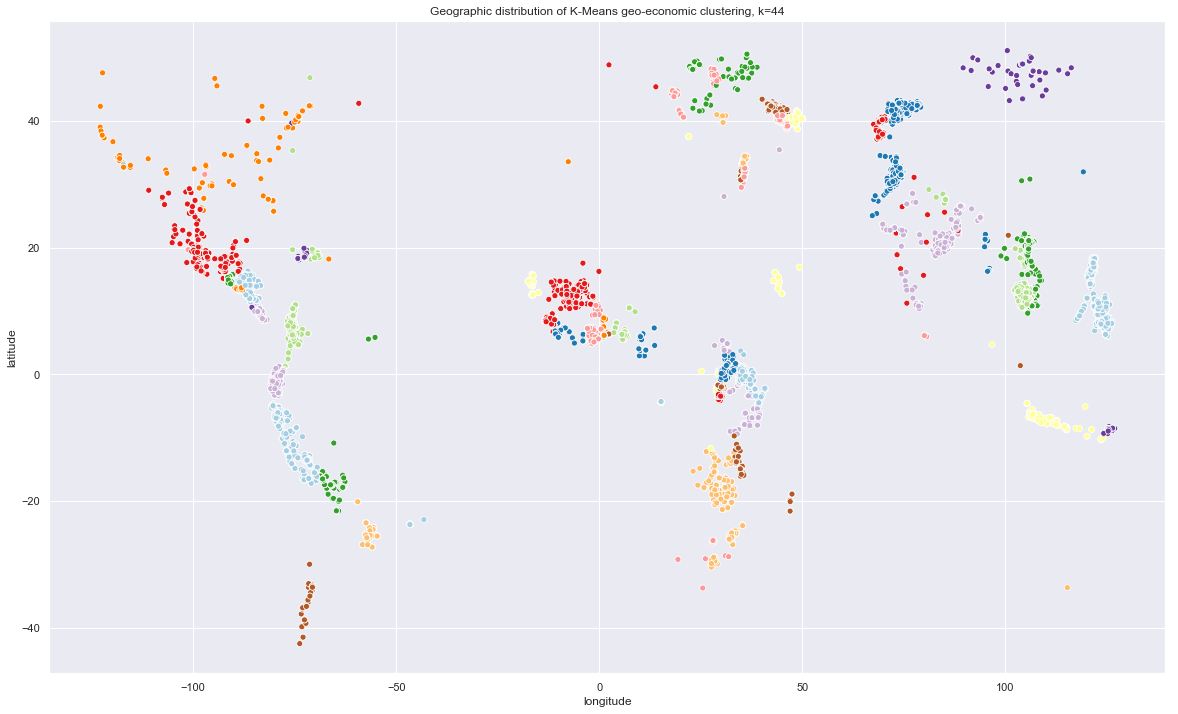

In [197]:
plt.figure(figsize=(20,12))
plt.title('Geographic distribution of K-Means geo-economic clustering, k=44')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='geoecon_k44_cluster', legend=False, palette = "Paired")

As you can see, it mostly breaks clusters apart by country, though there are a few spots where geographic proximity and economic similarity lead it to merge multiple countries into a single cluster.

Moving on, we're going to take a look at the economic clusters, starting with the K-Means clusters.

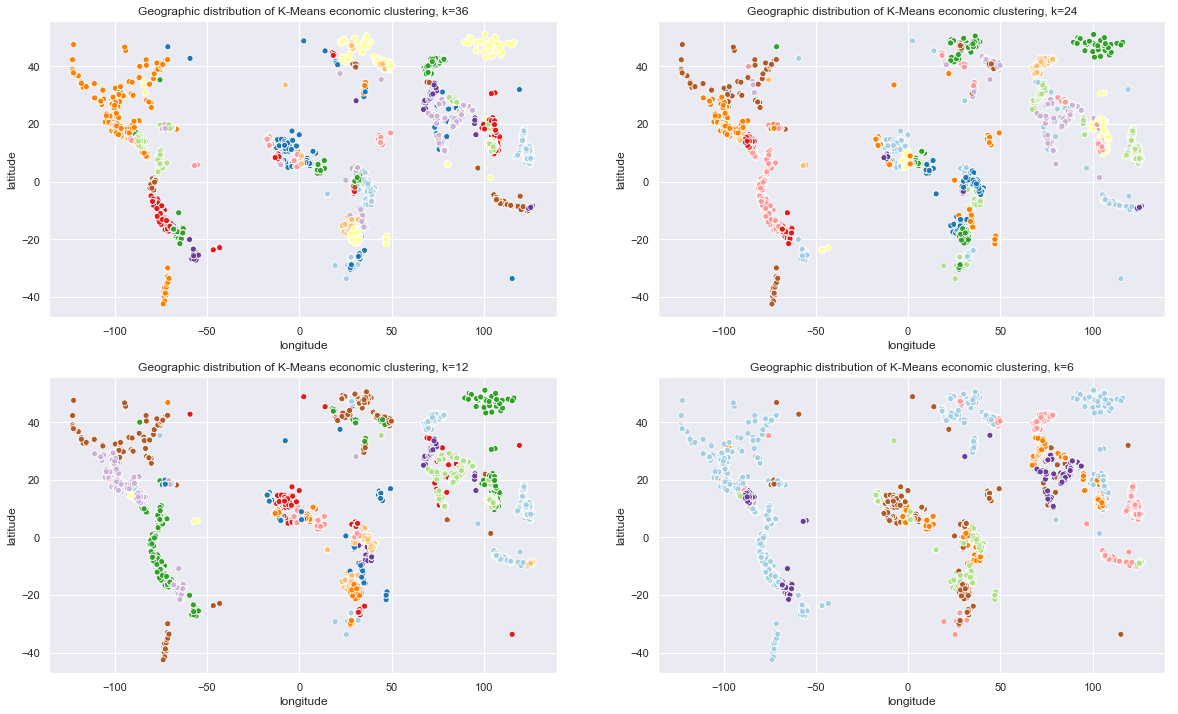

In [199]:
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.title('Geographic distribution of K-Means economic clustering, k=36')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_k36_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 2)
plt.title('Geographic distribution of K-Means economic clustering, k=24')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_k24_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 3)
plt.title('Geographic distribution of K-Means economic clustering, k=12')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_k12_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 4)
plt.title('Geographic distribution of K-Means economic clustering, k=6')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_k6_cluster', legend=False, palette = "Paired")

Again, many of the obvious divisions are along national borders, but now, due to the decreasing size of our k, we're starting to see more and more countries clumped together.  What's most interesting here, to the naked eye at least, is where clusters cross large gaps between countries, such as the green cluster in k=12 occupying points in Europe, Russia, Southeast Asia, and Latin America.  Obviously, such clusters are representive of common economic factors, and this will (hopefully) assist our predictive models in figuring out which loans are likely to fail to fund.

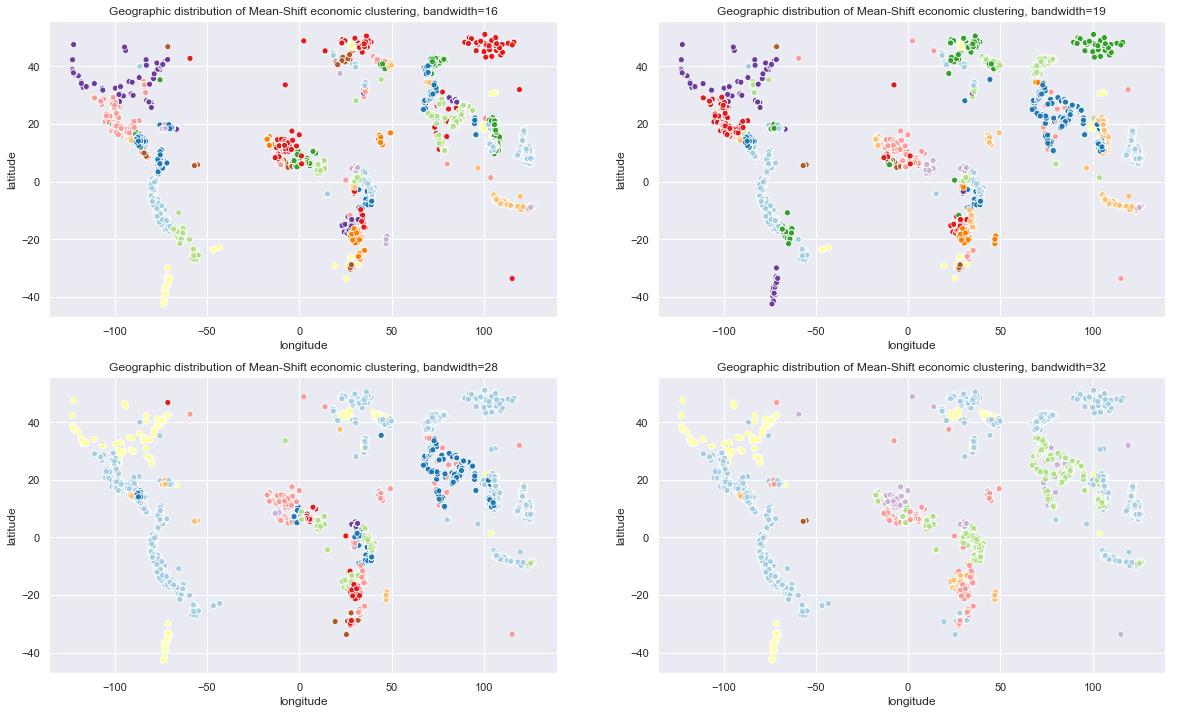

In [200]:
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.title('Geographic distribution of Mean-Shift economic clustering, bandwidth=16')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_ms16_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 2)
plt.title('Geographic distribution of Mean-Shift economic clustering, bandwidth=19')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_ms19_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 3)
plt.title('Geographic distribution of Mean-Shift economic clustering, bandwidth=28')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_ms28_cluster', legend=False, palette = "Paired")
plt.subplot(2, 2, 4)
plt.title('Geographic distribution of Mean-Shift economic clustering, bandwidth=32')
sns.scatterplot(x="longitude", 
                y="latitude",
                data=working_df, hue='econ_ms32_cluster', legend=False, palette = "Paired")

Mean-Shift produces similar results on the map, although its results in the predictive modeling process are less-than-helpful. 

<function matplotlib.pyplot.show(*args, **kw)>

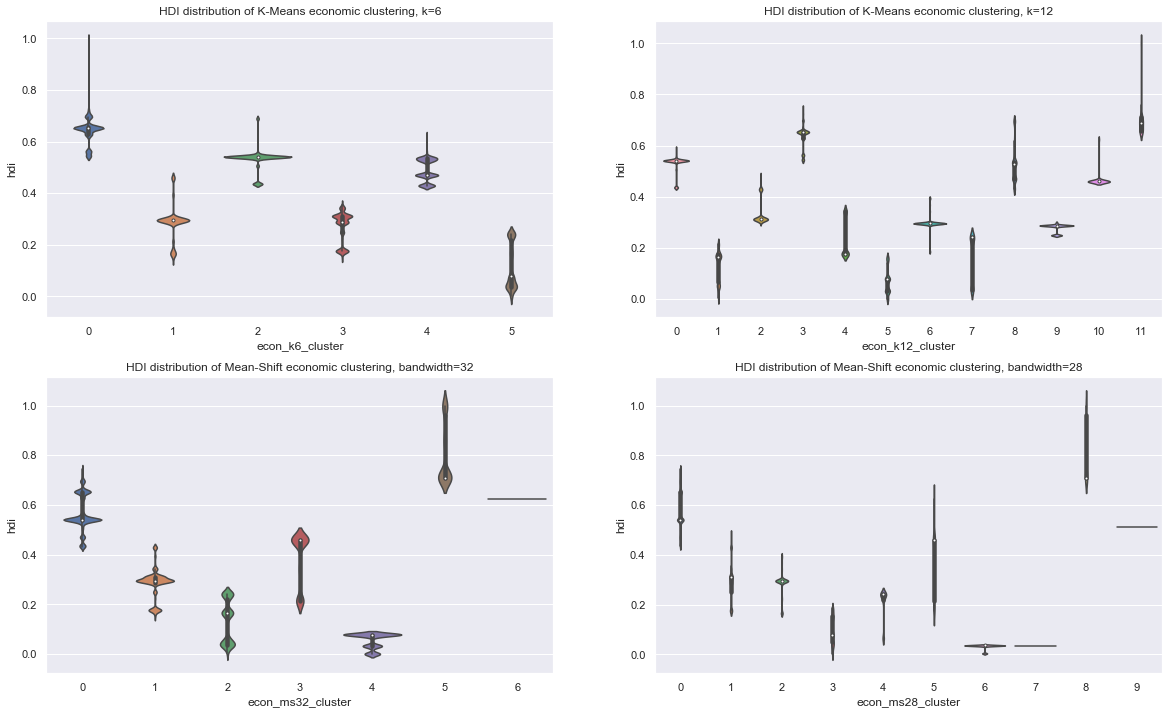

In [201]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
plt.title('HDI distribution of K-Means economic clustering, k=6')
sns.violinplot(x="econ_k6_cluster", y="hdi", data=working_df)
plt.subplot(2, 2, 2)
plt.title('HDI distribution of K-Means economic clustering, k=12')
sns.violinplot(x="econ_k12_cluster", y="hdi", data=working_df)
plt.subplot(2, 2, 3)
plt.title('HDI distribution of Mean-Shift economic clustering, bandwidth=32')
sns.violinplot(x="econ_ms32_cluster", y="hdi", data=working_df)
plt.subplot(2, 2, 4)
plt.title('HDI distribution of Mean-Shift economic clustering, bandwidth=28')
sns.violinplot(x="econ_ms28_cluster", y="hdi", data=working_df)
plt.show

Here we start comparing the economic indicators that these clusters were based on, and we see - to nobody's surprise - that they are in relatively uniform clumps, separated from each other for the most part so that each cluster grabs a separate economic group.  

This set of plots also illustrates one of the drawbacks of Mean-Shift, in that three of the clusters in our two Mean-Shift groupings have a single country in them, making them less-than-useful for our purposes.

<function matplotlib.pyplot.show(*args, **kw)>

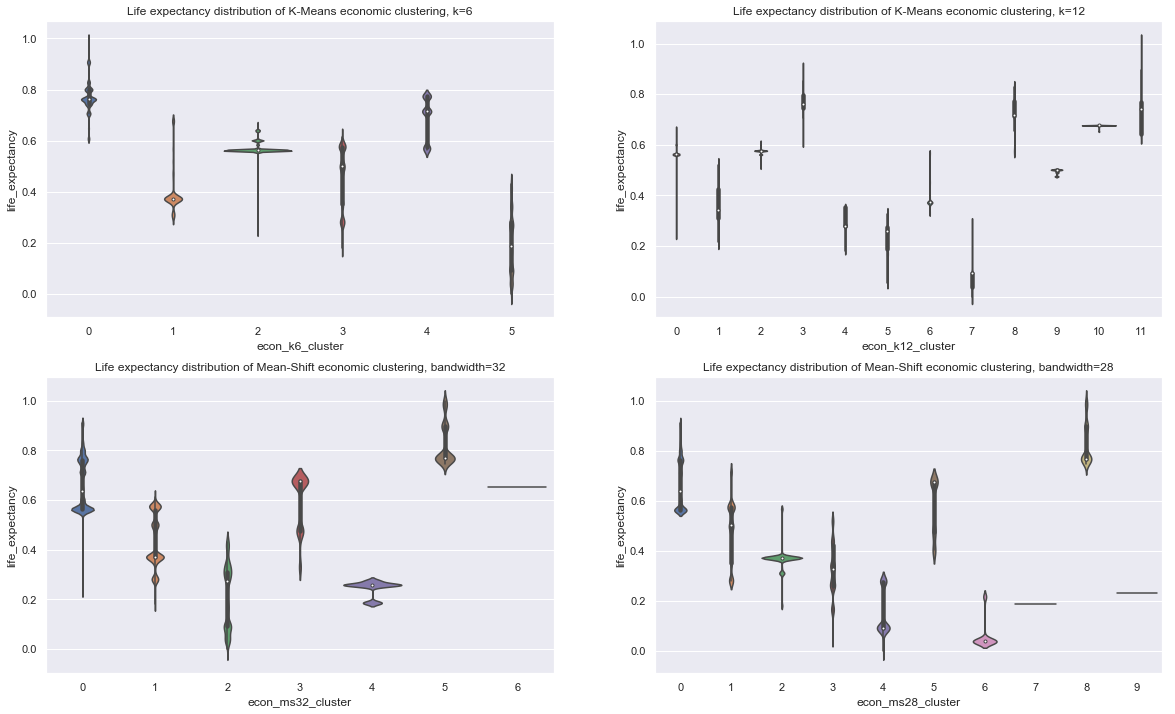

In [202]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
plt.title('Life expectancy distribution of K-Means economic clustering, k=6')
sns.violinplot(x="econ_k6_cluster", y="life_expectancy", data=working_df)
plt.subplot(2, 2, 2)
plt.title('Life expectancy distribution of K-Means economic clustering, k=12')
sns.violinplot(x="econ_k12_cluster", y="life_expectancy", data=working_df)
plt.subplot(2, 2, 3)
plt.title('Life expectancy distribution of Mean-Shift economic clustering, bandwidth=32')
sns.violinplot(x="econ_ms32_cluster", y="life_expectancy", data=working_df)
plt.subplot(2, 2, 4)
plt.title('Life expectancy distribution of Mean-Shift economic clustering, bandwidth=28')
sns.violinplot(x="econ_ms28_cluster", y="life_expectancy", data=working_df)
plt.show

With life expectancy we start to see more overlap between clusters, indicating that this measure has more tightly grouped overall distribution.  Still, it demonstrates that we have a functional separation between countries in different economic situations, and so for our purposes these clusters should prove functional.

<function matplotlib.pyplot.show(*args, **kw)>

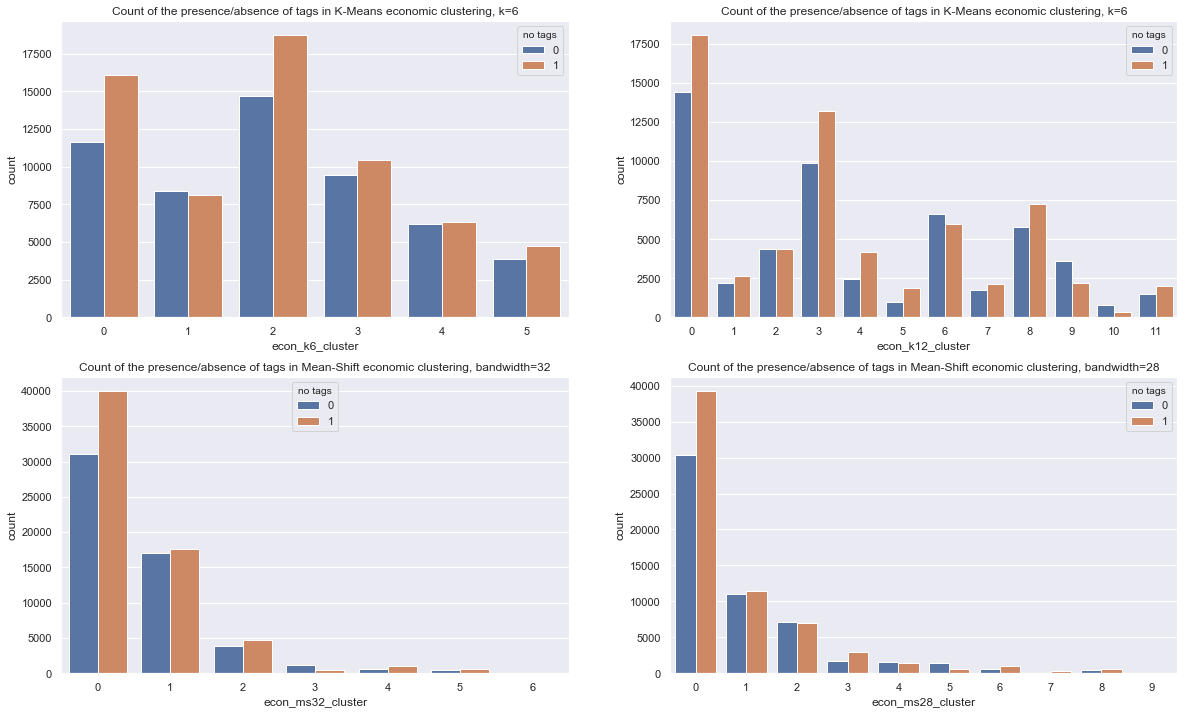

In [203]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
plt.title('Count of the presence/absence of tags in K-Means economic clustering, k=6')
sns.countplot(x="econ_k6_cluster", hue="no tags", data=working_df)
plt.subplot(2, 2, 2)
plt.title('Count of the presence/absence of tags in K-Means economic clustering, k=6')
sns.countplot(x="econ_k12_cluster", hue="no tags", data=working_df)
plt.subplot(2, 2, 3)
plt.title('Count of the presence/absence of tags in Mean-Shift economic clustering, bandwidth=32')
sns.countplot(x="econ_ms32_cluster", hue="no tags", data=working_df)
plt.subplot(2, 2, 4)
plt.title('Count of the presence/absence of tags in Mean-Shift economic clustering, bandwidth=28')
sns.countplot(x="econ_ms28_cluster", hue="no tags", data=working_df)
plt.show

This was just for fun, to see if there was a meaningful difference in the tag usage between clusters.  Interestingly enough, there does seem to be, at least to a small extent.

## 6.0. Checking numeric features for outliers

<function matplotlib.pyplot.show(*args, **kw)>

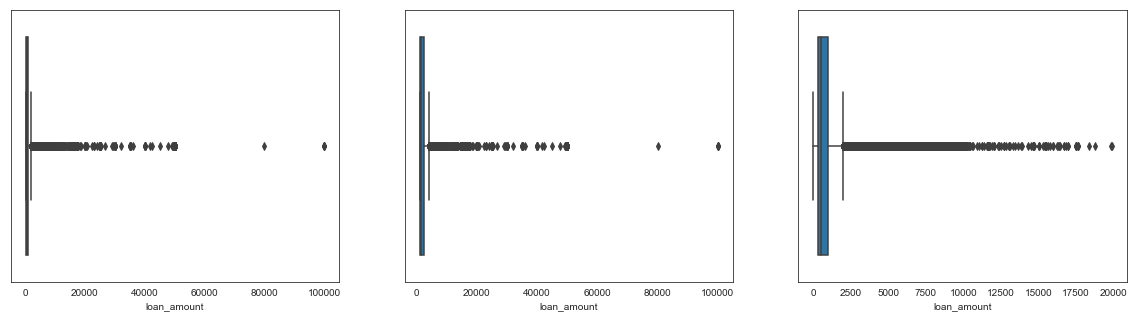

In [116]:
feature = 'loan_amount'
x1 = 100 ; x2 = 1000 ; x3 = 20000
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] < x3][feature])
plt.show

# reasonable cutoff looks like 7500-10k; everything else is a massive outlier

<function matplotlib.pyplot.show(*args, **kw)>

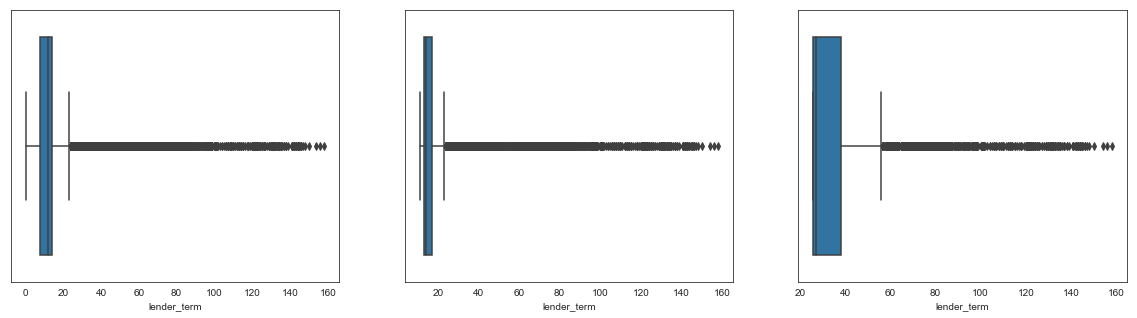

In [117]:
feature = 'lender_term'
x1 = 0 ; x2 = 10 ; x3 = 25
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# outlier cutoff looks like 60-80, if it's to be used at all

<function matplotlib.pyplot.show(*args, **kw)>

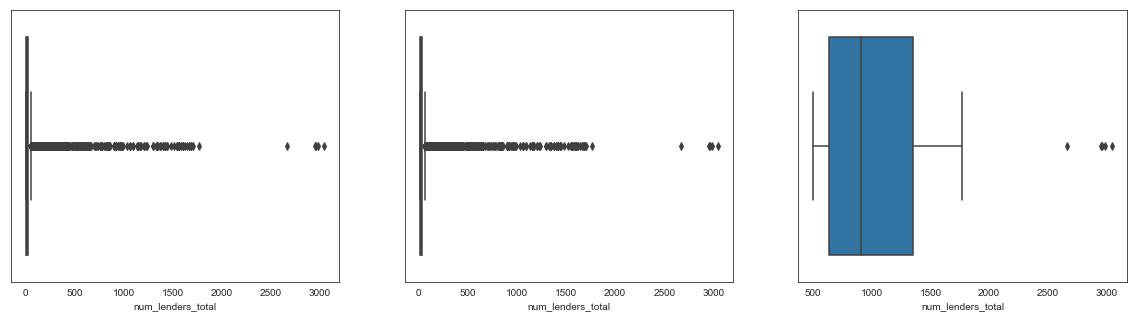

In [118]:
feature = 'num_lenders_total'
x1 = 0 ; x2 = 10 ; x3 = 500
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# outliers are >2000

<function matplotlib.pyplot.show(*args, **kw)>

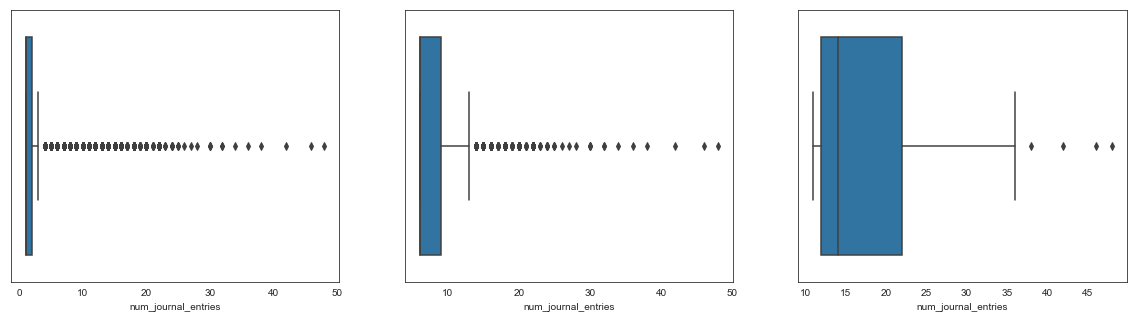

In [119]:
feature = 'num_journal_entries'
x1 = 0 ; x2 = 5 ; x3 = 10
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# outliers are >40

<function matplotlib.pyplot.show(*args, **kw)>

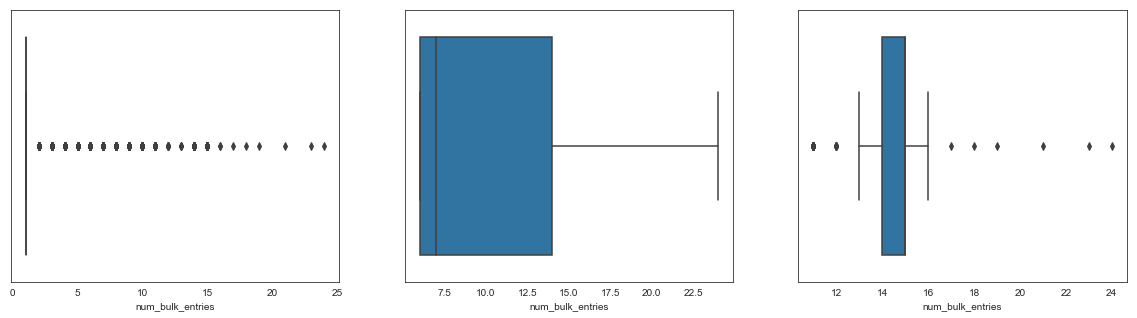

In [120]:
feature = 'num_bulk_entries'
x1 = 0 ; x2 = 5 ; x3 = 10
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# no significant outliers

<function matplotlib.pyplot.show(*args, **kw)>

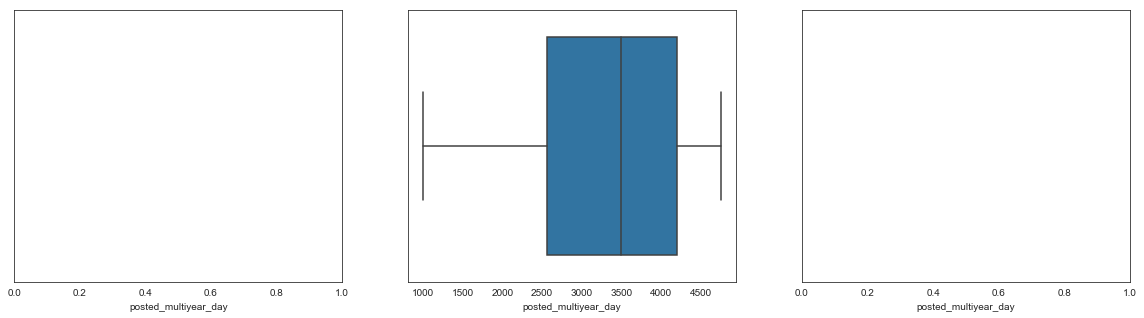

In [121]:
feature = 'posted_multiyear_day'
x1 = 0 ; x2 = 1000 ; x3 = 5000
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
# need to check that there aren't any incorrectly-entered entries that are prior to 2005
sns.boxplot(working_df.loc[working_df[feature] < x1][feature]) 
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# no stupidly-obvious outliers in this feature

<function matplotlib.pyplot.show(*args, **kw)>

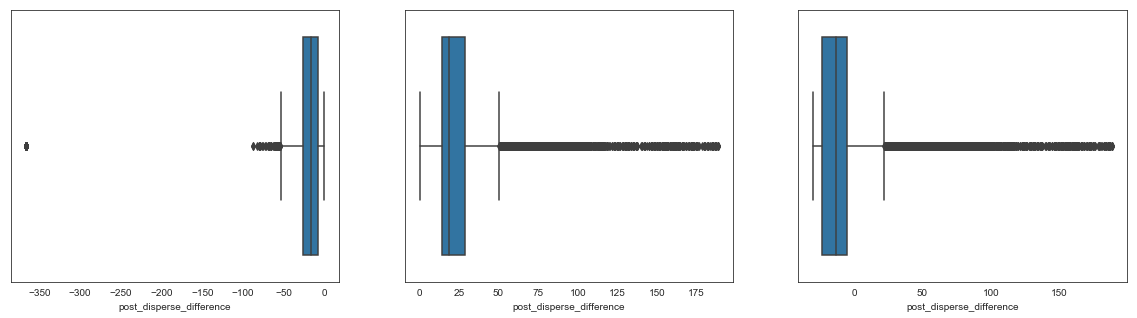

In [122]:
feature = 'post_disperse_difference'
x1 = 0 ; x2 = 0 ; x3 = -30
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] < x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# outlier at < -350; other than that, there seems to be a thick spectrum of outliers above 50

<function matplotlib.pyplot.show(*args, **kw)>

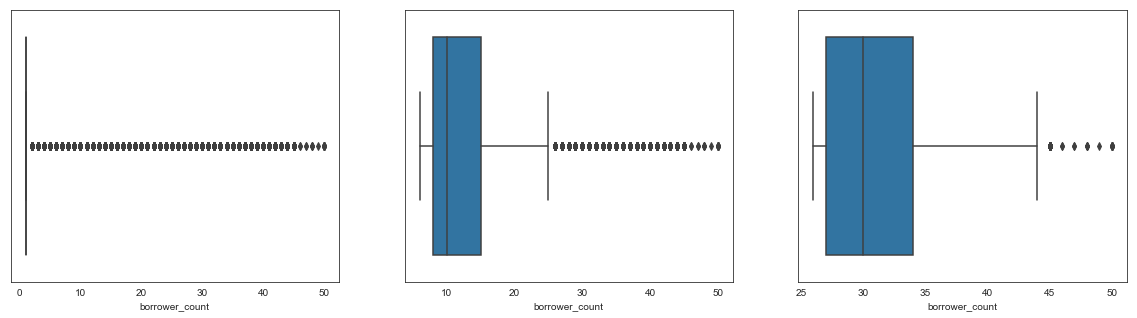

In [124]:
feature = 'borrower_count'
x1 = 0 ; x2 = 5 ; x3 = 25
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.boxplot(working_df.loc[working_df[feature] > x1][feature])
plt.subplot(1, 3, 2)
sns.boxplot(working_df.loc[working_df[feature] > x2][feature])
plt.subplot(1, 3, 3)
sns.boxplot(working_df.loc[working_df[feature] > x3][feature])
plt.show

# could likely count anything over 40 as an outlier